In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

In [2]:
pd.options.plotting.backend = "matplotlib"
plt.rcParams["figure.figsize"] = (20, 4)
plt.rcParams["axes.grid"] = True

# Поиск ближайших "товаров"

Имеется 4 датасета:
- Base - некая база в которой будем искать похожие товары.
- Train - набор данных, на которых можно учиться и экспериментировать.
- Validation - набор данных для которых нужно будет найти похожие.
- Validation_answer - Правильные ответы для validation

!!!!!   Ячейки, работающие дольше двух минут закоментированы, но не перезапущены, что бы сохранить результат.   !!!!!

!!!!!     Ячеек работающих меньше двух минут тоже не мало. Рекомендую сначала посмотреть и определиться что именно нужно запустить.     !!!!!

# Загрузка датасетов

## Base

In [3]:
base = pd.read_csv("datasets/base.csv", index_col=0)
base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.42676,-118.88089,216.482440,-104.69806,-469.070588,44.348083,120.915344,181.44970,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.93361,115.26919,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.78761,-166.53348,57.680607,-86.09837,-85.076666,-35.637436,119.718636,195.23419,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.93793,116.83400,-84.888941,-59.524610


In [4]:
base.shape

(2918139, 72)

## Train

In [5]:
train = pd.read_csv("datasets/train.csv", index_col=0)
train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.91590,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base


In [6]:
train. shape

(100000, 73)

## Validation

In [7]:
valid = pd.read_csv("datasets/validation.csv", index_col=0)
valid.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.07936
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.00932


In [8]:
valid. shape

(100000, 72)

## Validation_answer

In [9]:
pd_target = pd.read_csv("datasets/validation_answer.csv", index_col=0)
pd_target.head(2)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base


In [10]:
pd_target. shape

(100000, 1)

# EDA

Взглянем на данные в целом

## Base

In [68]:
base. columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [69]:
base. index

Index(['0-base', '1-base', '2-base', '3-base', '4-base', '5-base', '6-base',
       '7-base', '8-base', '9-base',
       ...
       '4744747-base', '4744748-base', '4744749-base', '4744753-base',
       '4744754-base', '4744755-base', '4744759-base', '4744762-base',
       '4744763-base', '4744766-base'],
      dtype='object', name='Id', length=2918139)

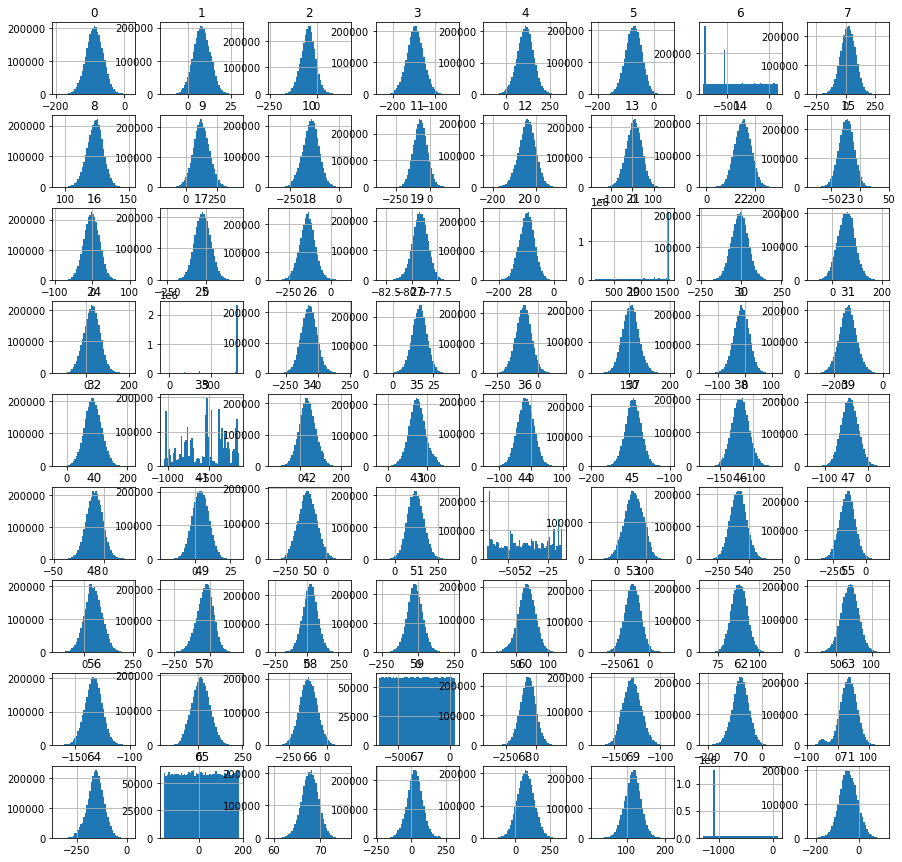

In [70]:
base. hist(figsize=(15,15), bins=50);

---------- 0 ----------


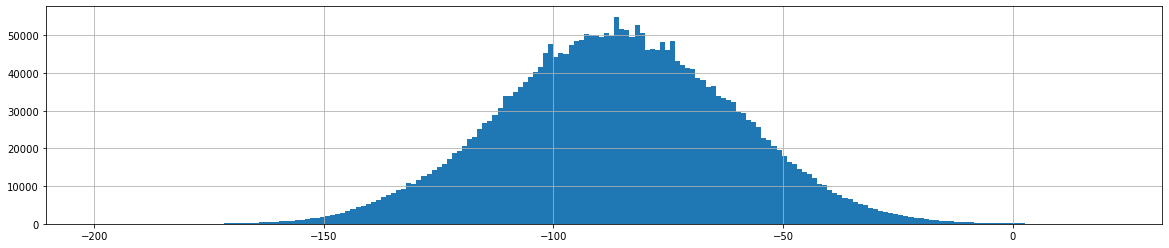

---------- 1 ----------


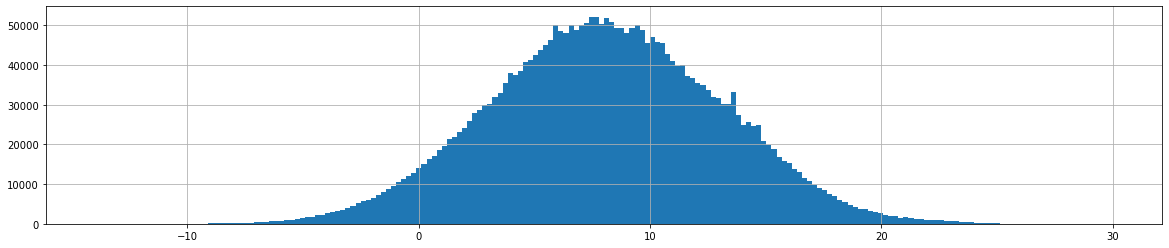

---------- 2 ----------


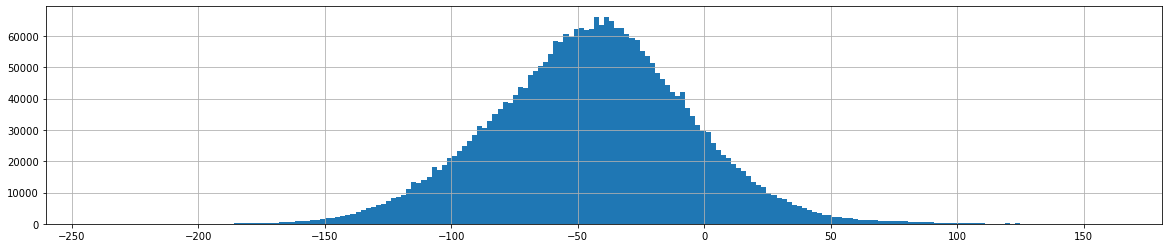

---------- 3 ----------


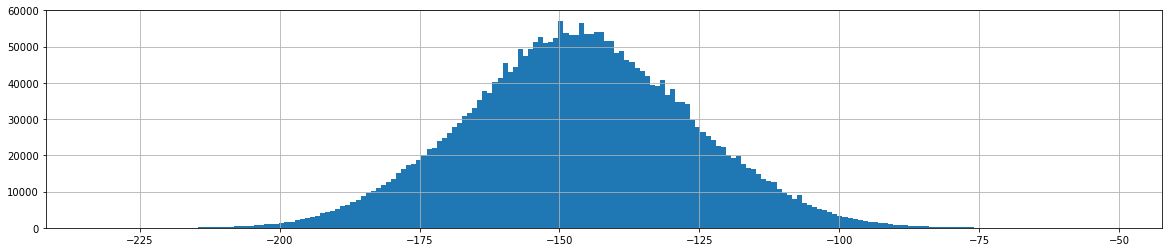

---------- 4 ----------


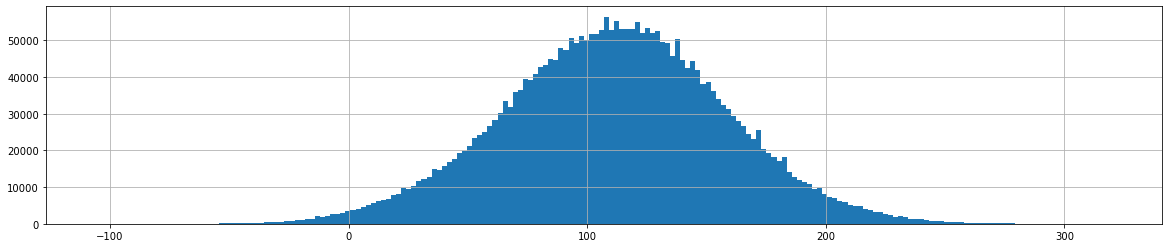

---------- 5 ----------


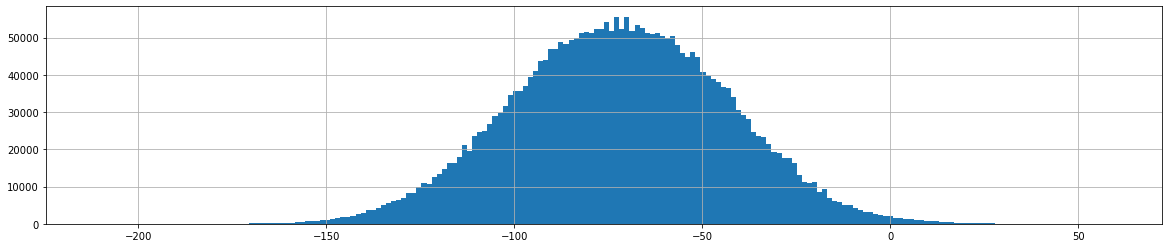

---------- 6 ----------


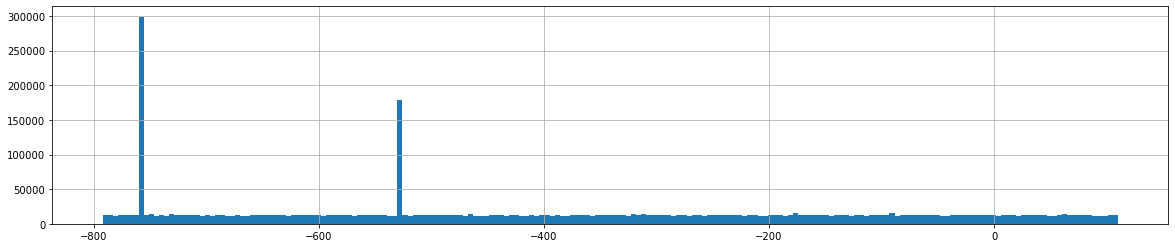

---------- 7 ----------


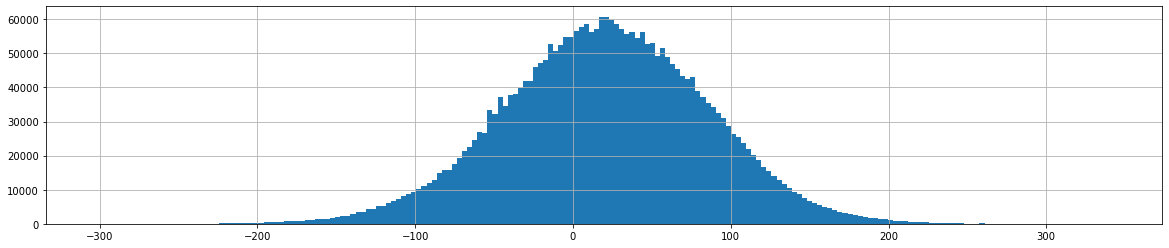

---------- 8 ----------


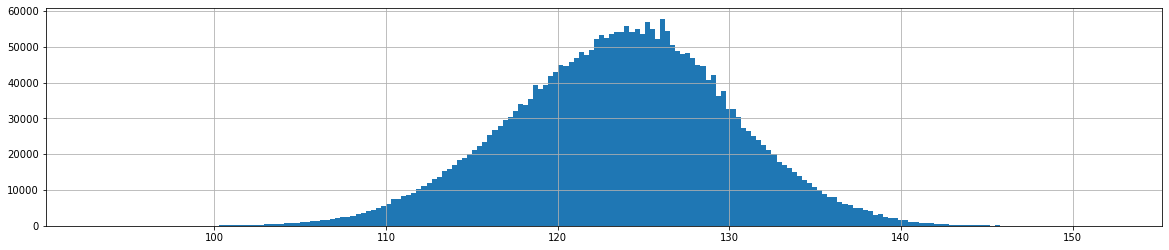

---------- 9 ----------


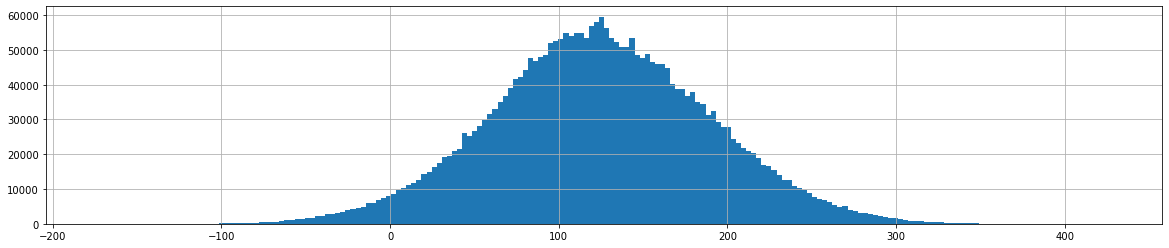

---------- 10 ----------


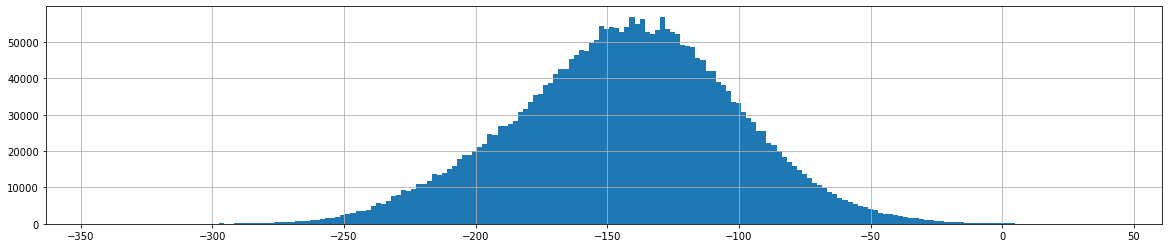

---------- 11 ----------


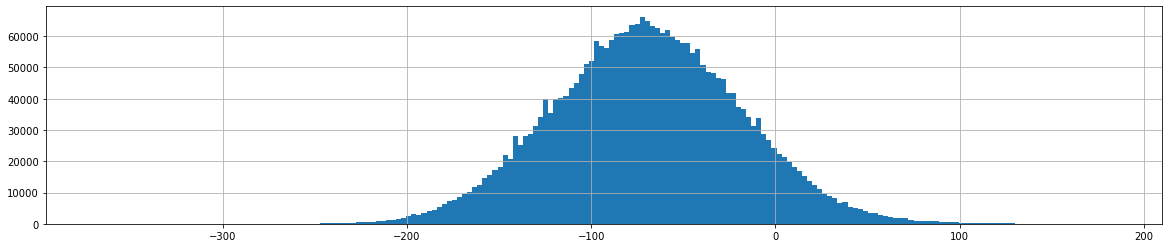

---------- 12 ----------


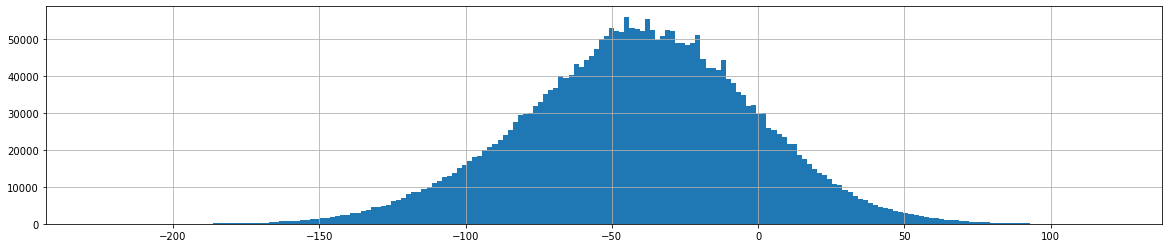

---------- 13 ----------


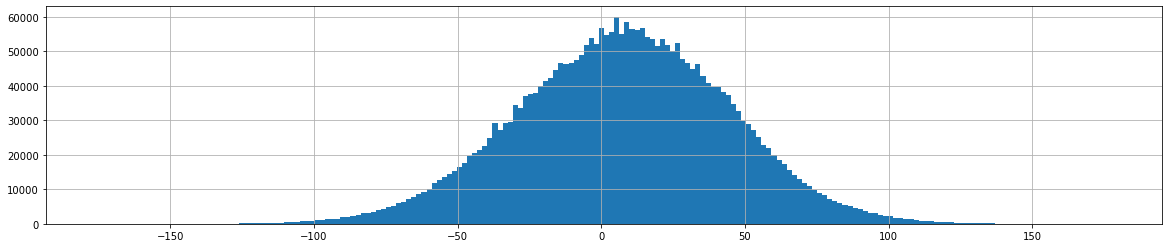

---------- 14 ----------


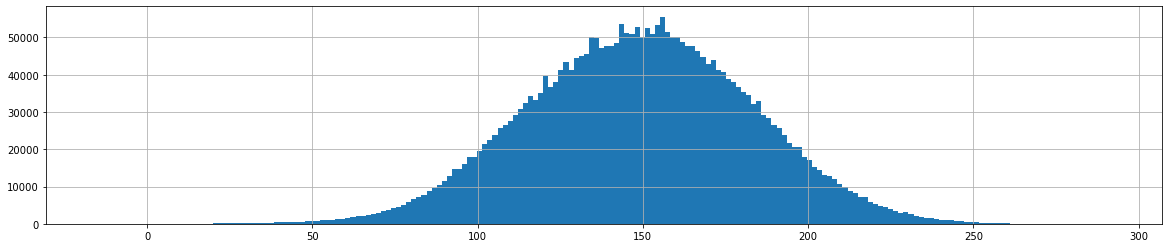

---------- 15 ----------


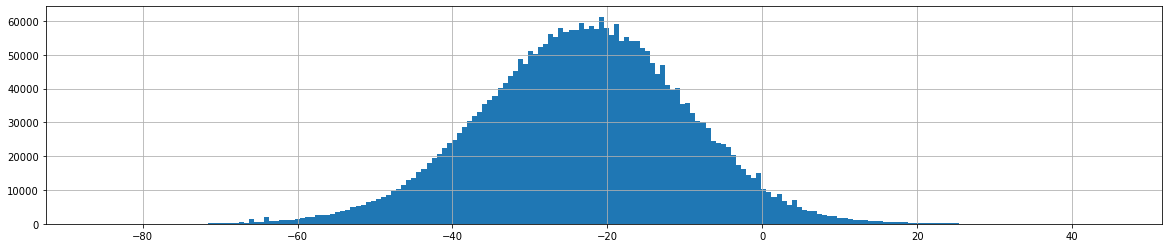

---------- 16 ----------


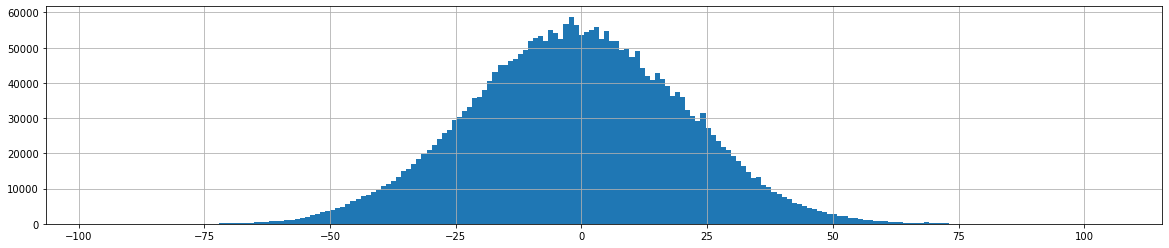

---------- 17 ----------


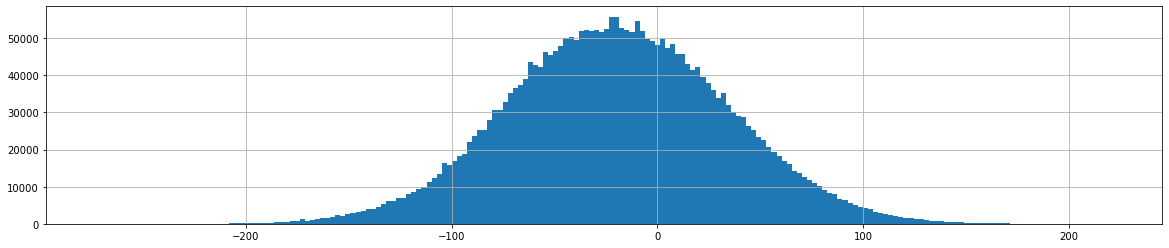

---------- 18 ----------


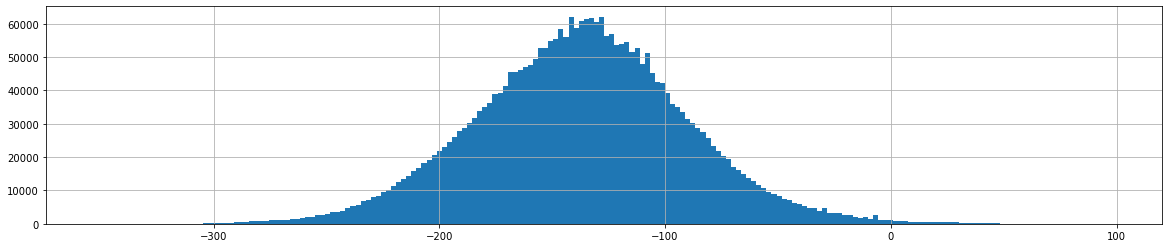

---------- 19 ----------


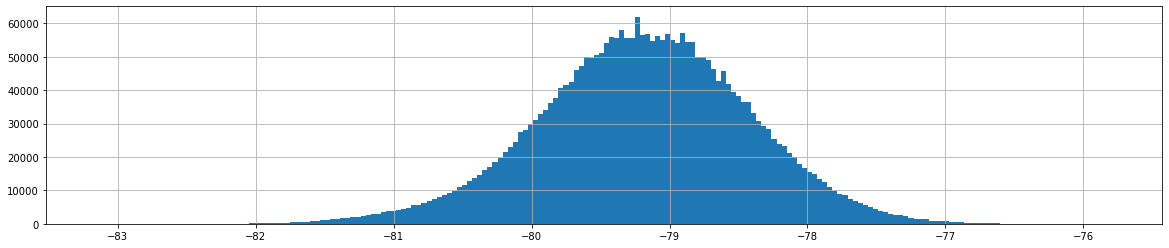

---------- 20 ----------


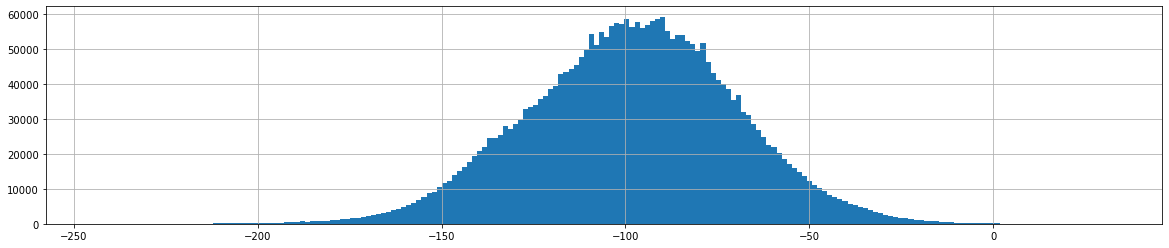

---------- 21 ----------


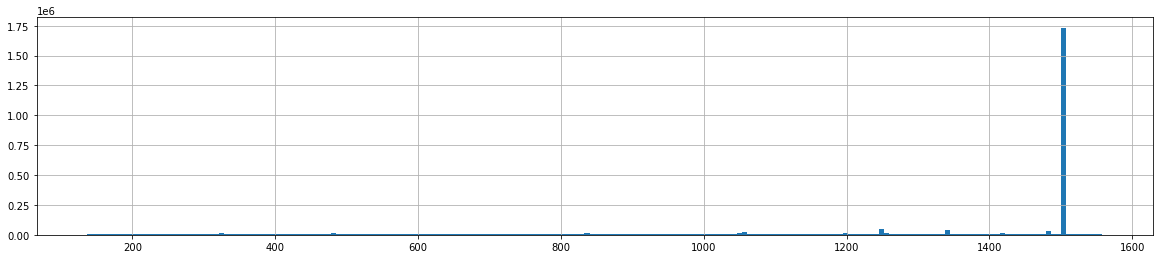

---------- 22 ----------


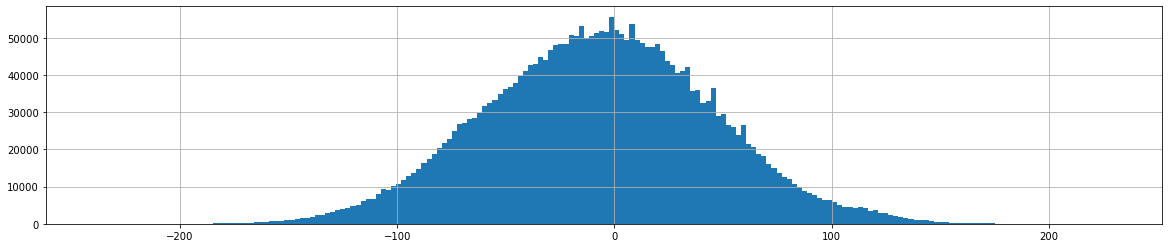

---------- 23 ----------


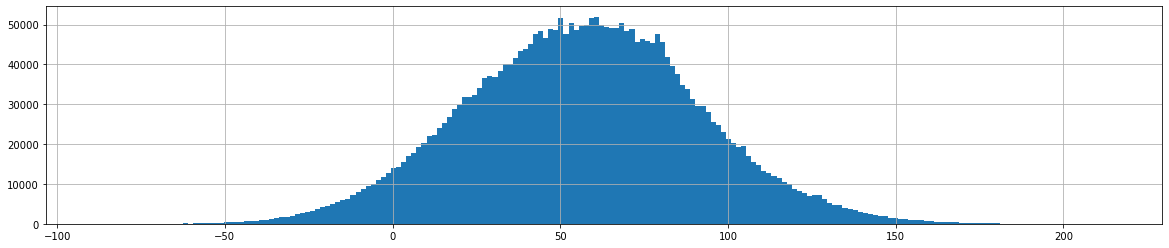

---------- 24 ----------


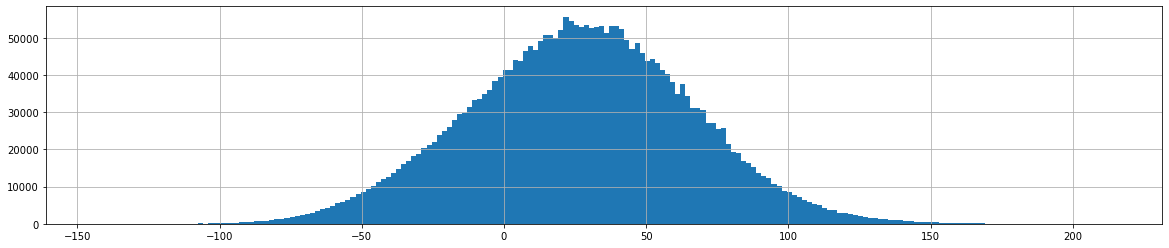

---------- 25 ----------


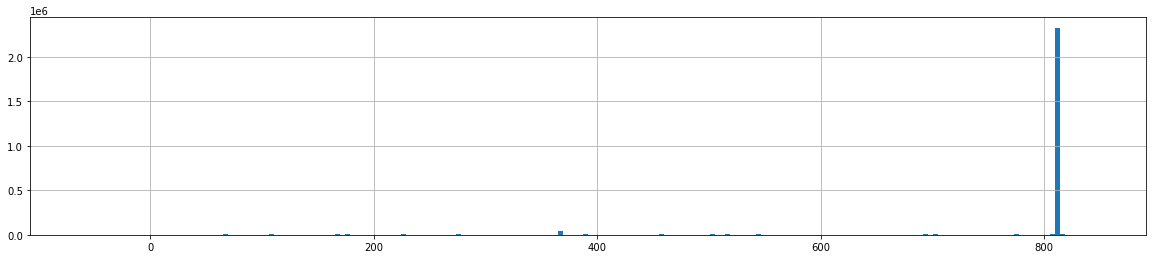

---------- 26 ----------


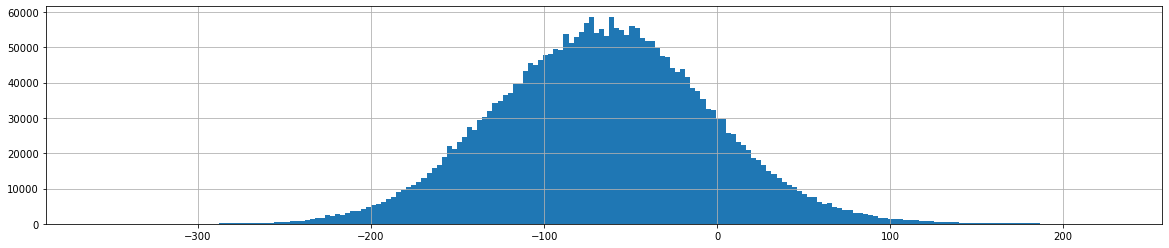

---------- 27 ----------


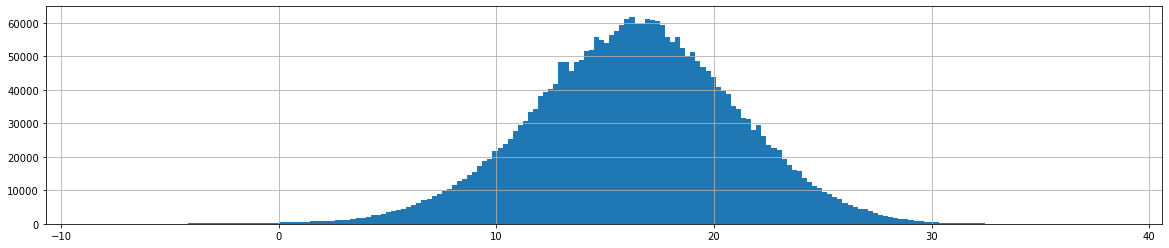

---------- 28 ----------


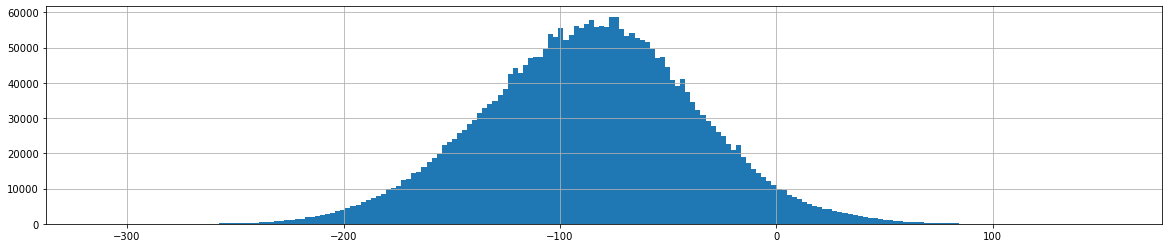

---------- 29 ----------


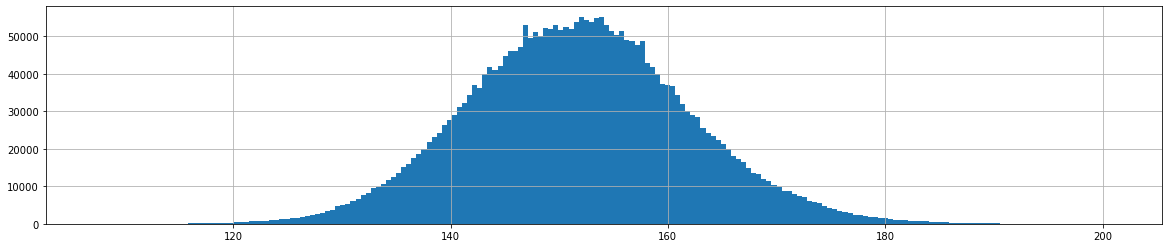

---------- 30 ----------


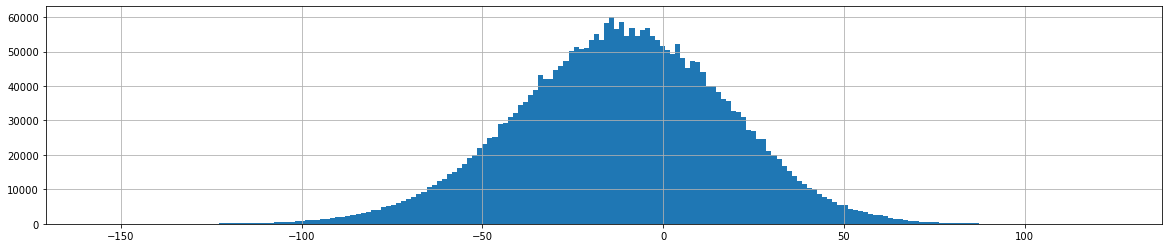

---------- 31 ----------


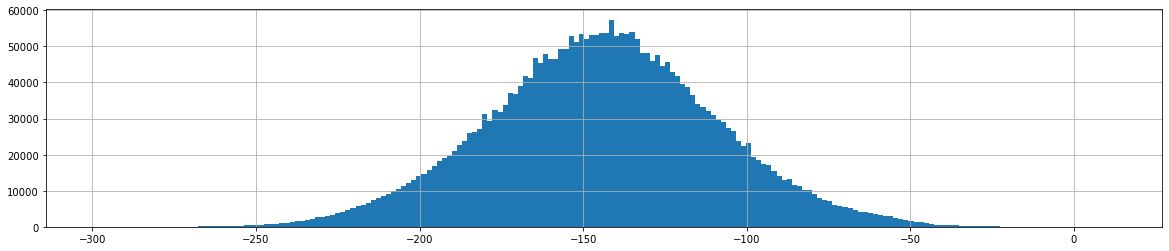

---------- 32 ----------


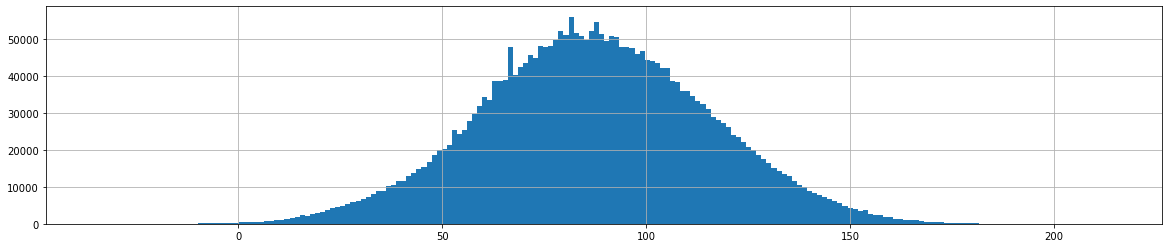

---------- 33 ----------


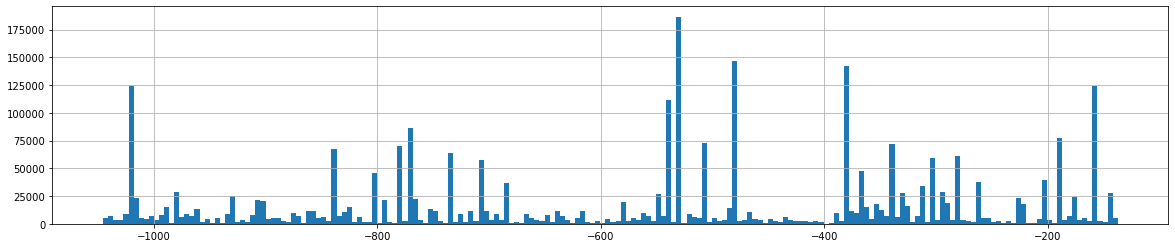

---------- 34 ----------


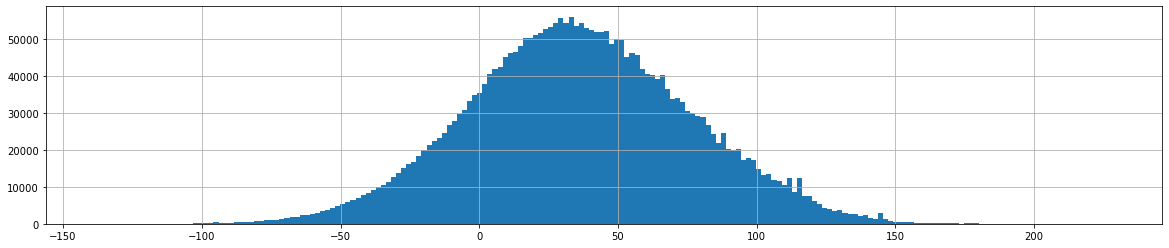

---------- 35 ----------


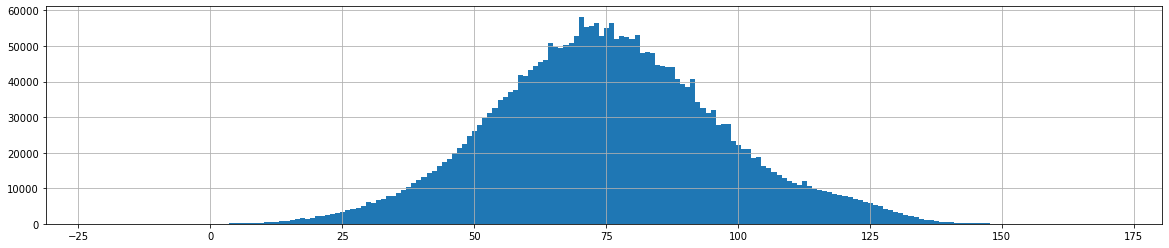

---------- 36 ----------


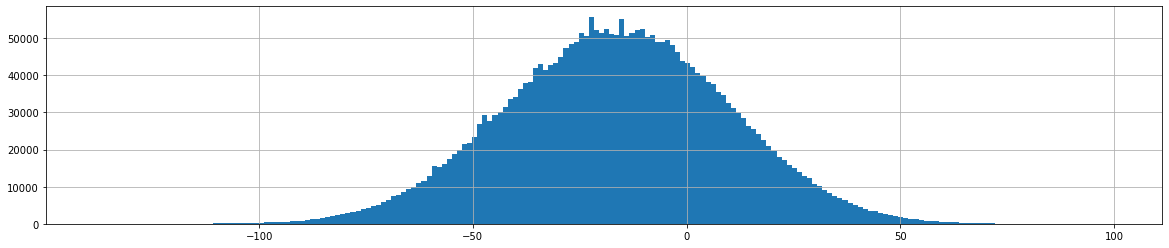

---------- 37 ----------


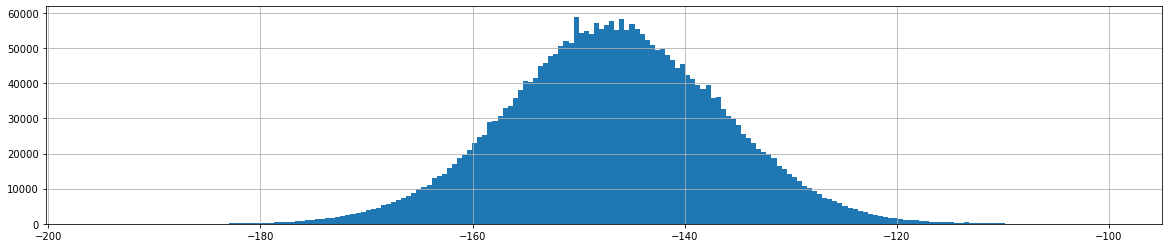

---------- 38 ----------


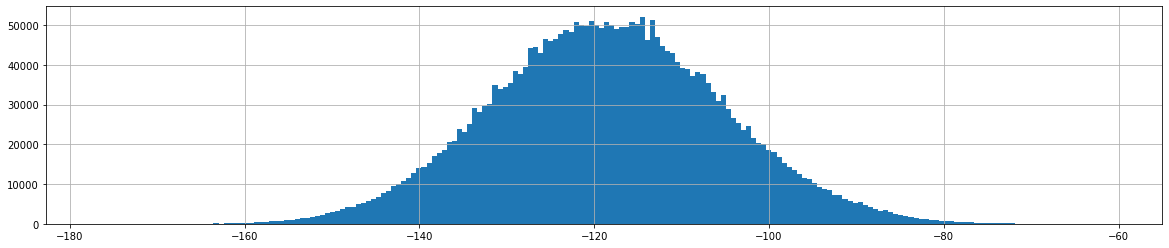

---------- 39 ----------


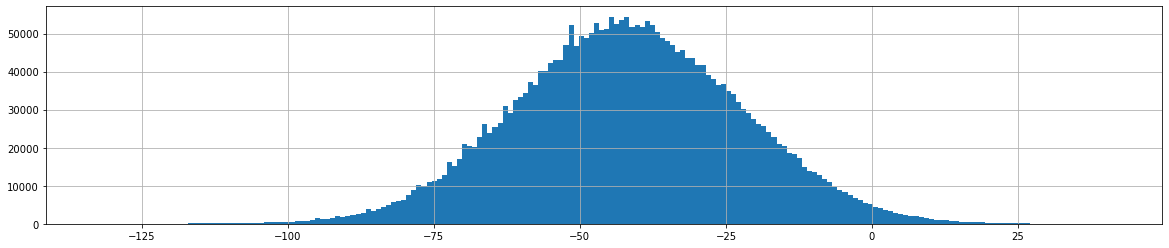

---------- 40 ----------


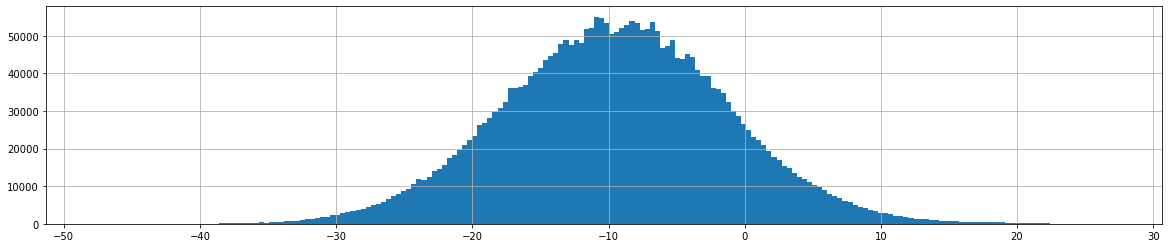

---------- 41 ----------


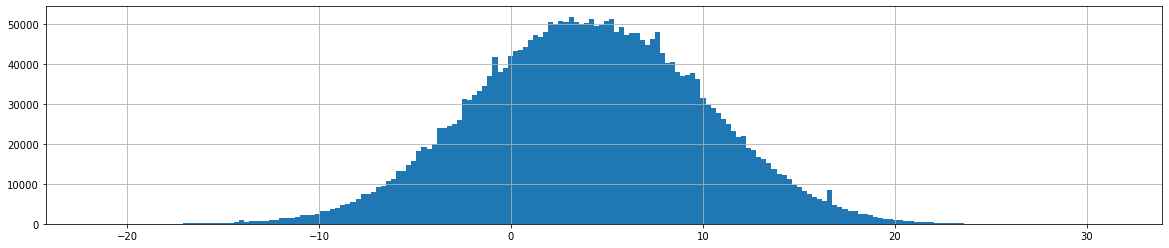

---------- 42 ----------


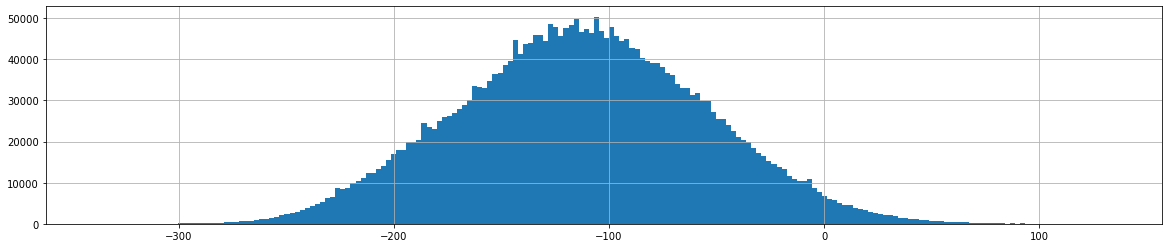

---------- 43 ----------


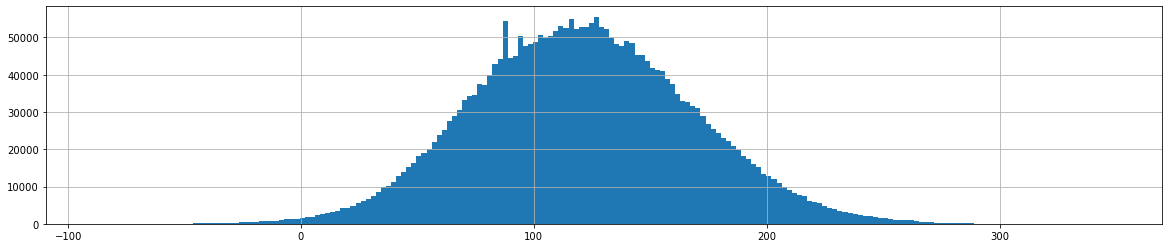

---------- 44 ----------


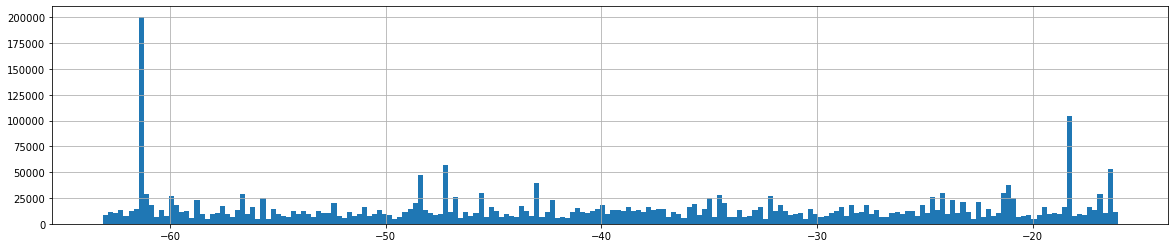

---------- 45 ----------


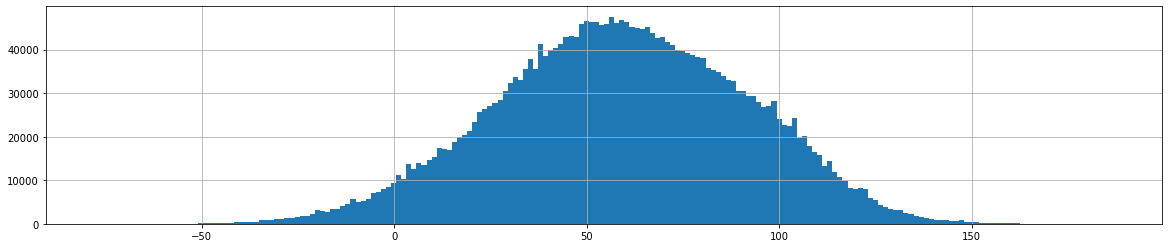

---------- 46 ----------


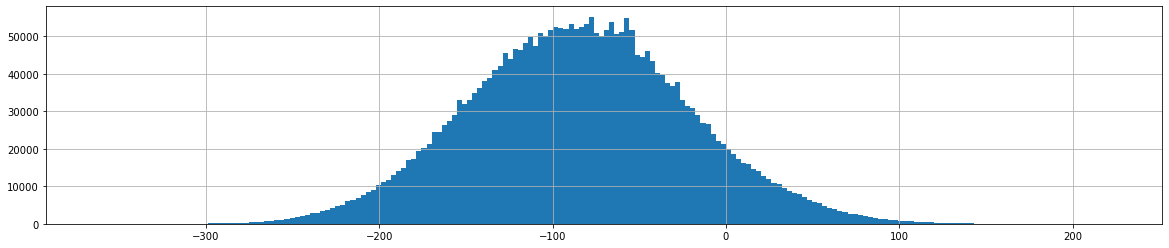

---------- 47 ----------


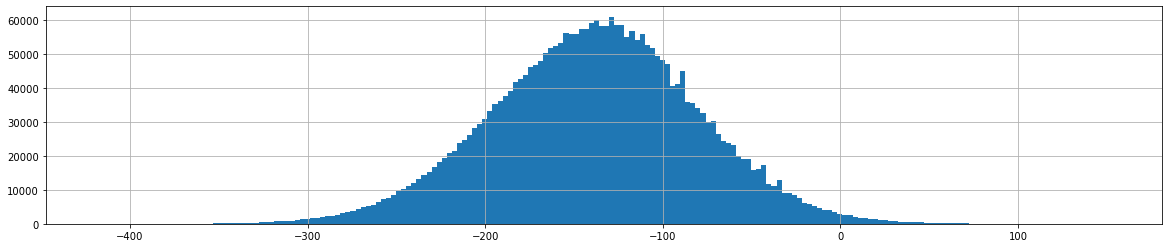

---------- 48 ----------


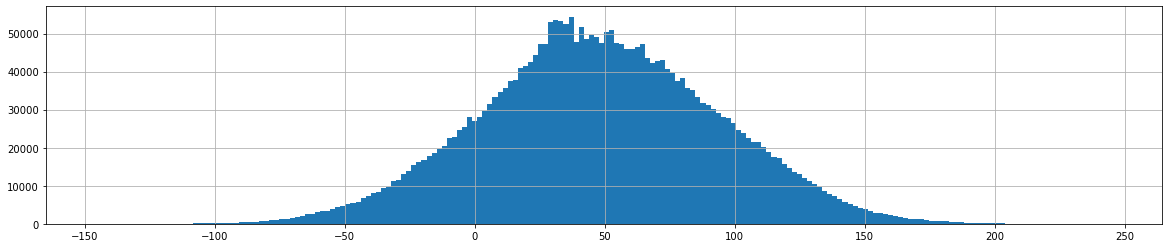

---------- 49 ----------


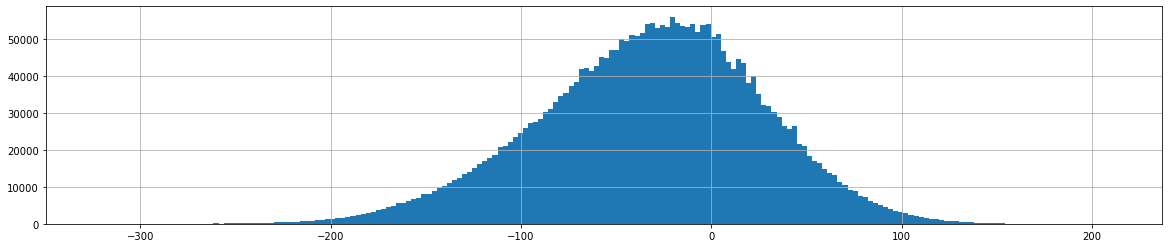

---------- 50 ----------


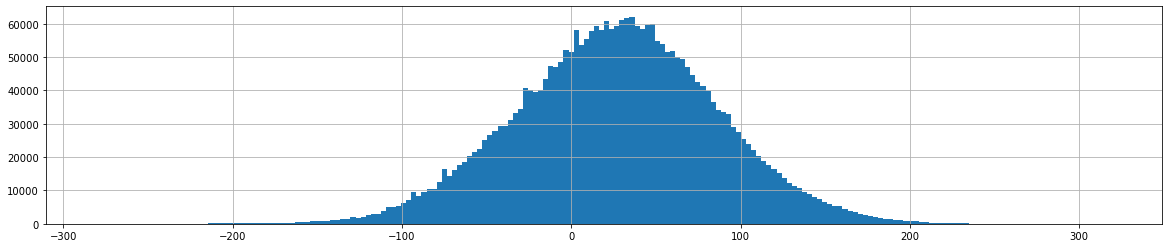

---------- 51 ----------


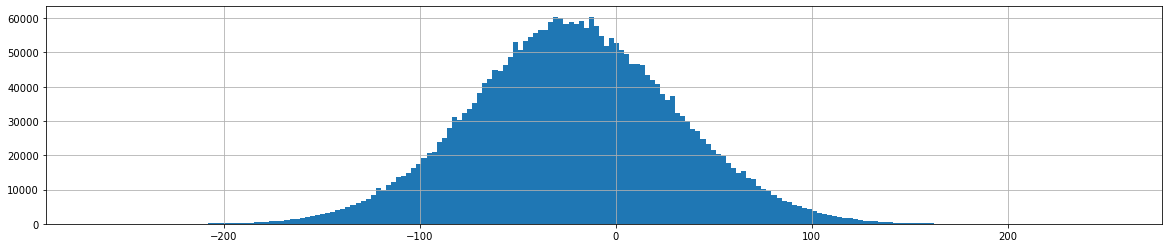

---------- 52 ----------


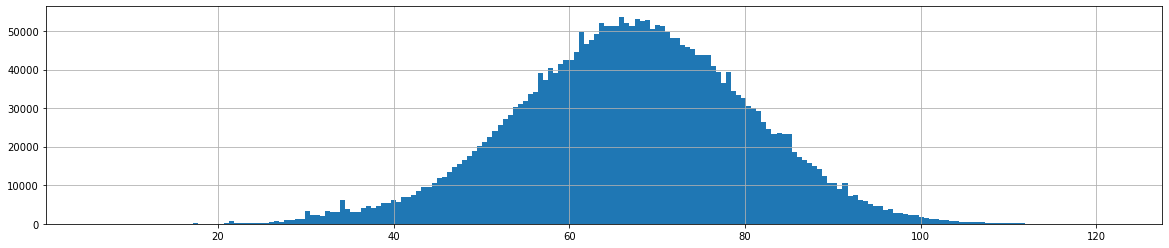

---------- 53 ----------


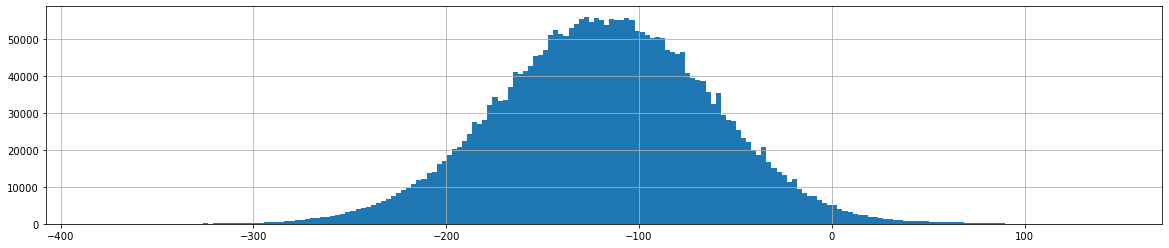

---------- 54 ----------


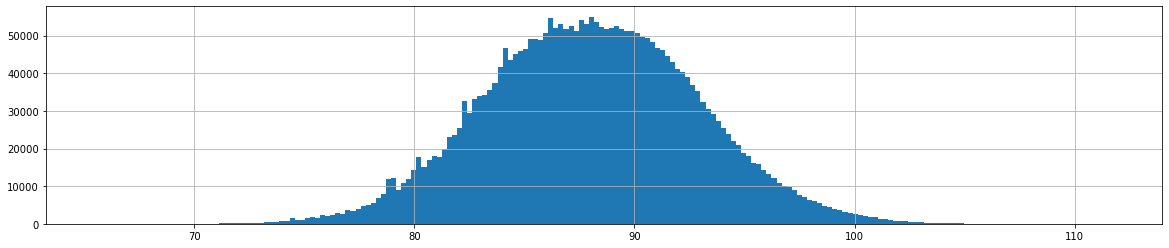

---------- 55 ----------


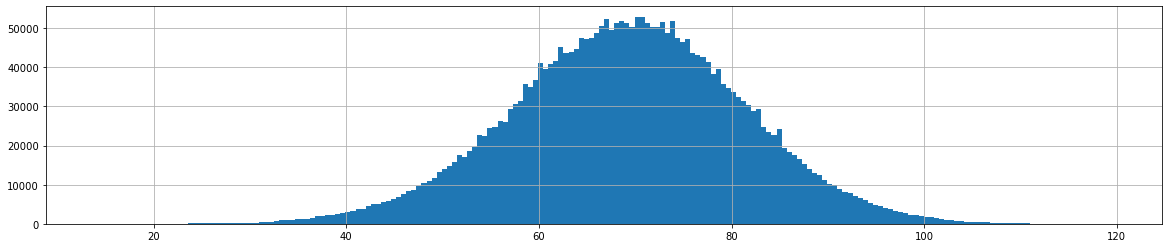

---------- 56 ----------


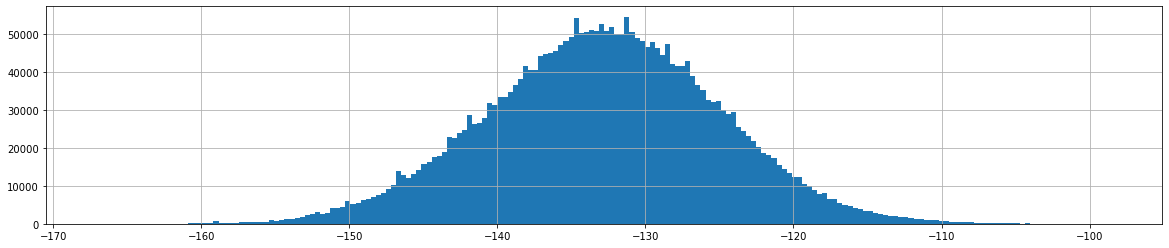

---------- 57 ----------


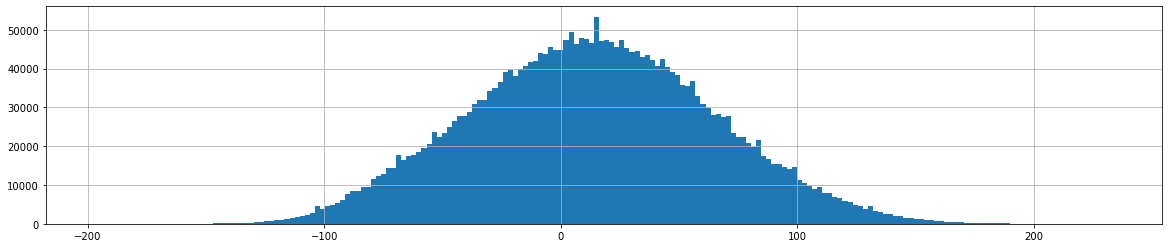

---------- 58 ----------


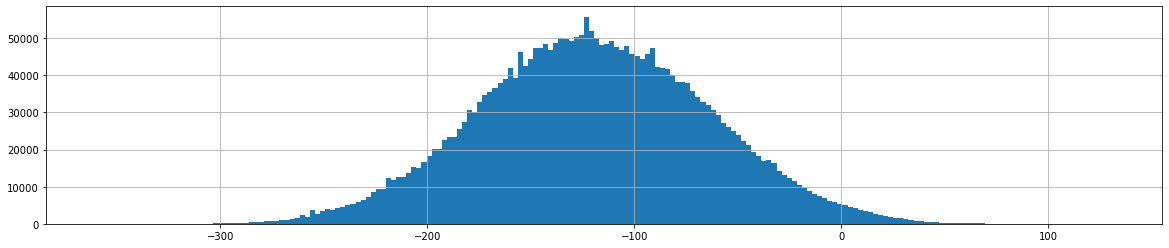

---------- 59 ----------


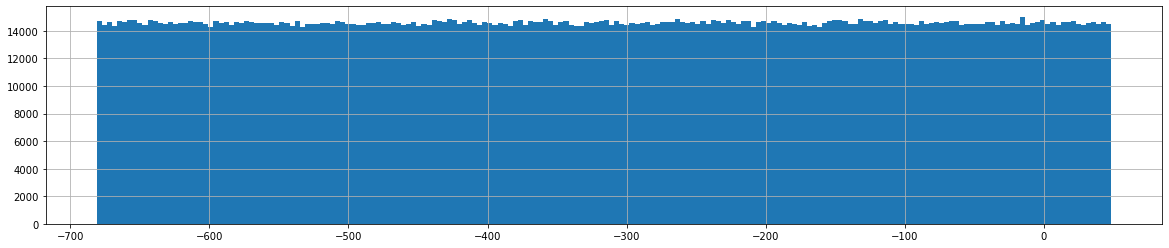

---------- 60 ----------


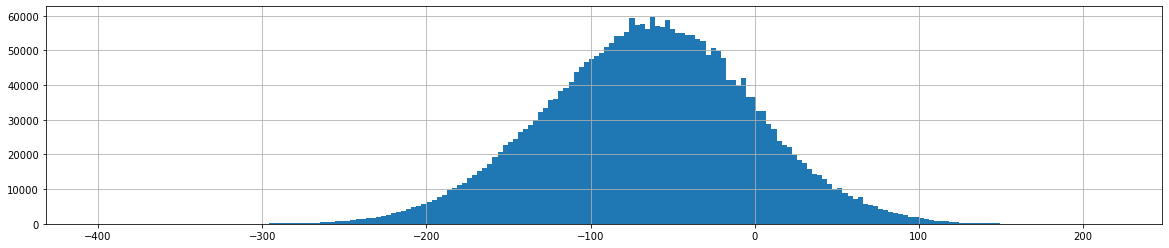

---------- 61 ----------


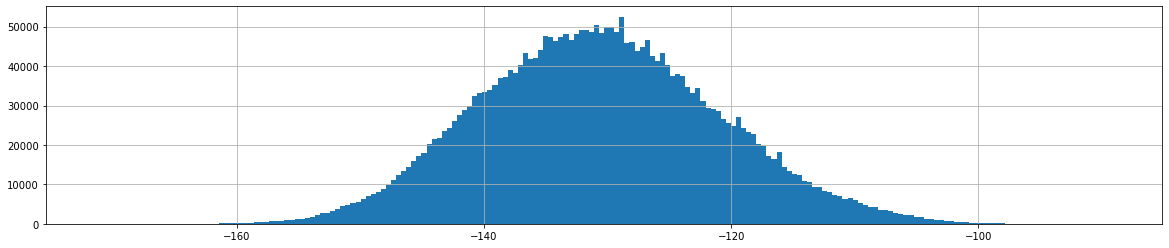

---------- 62 ----------


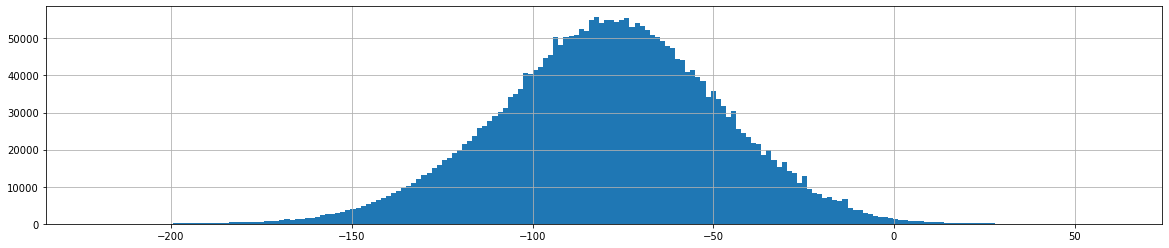

---------- 63 ----------


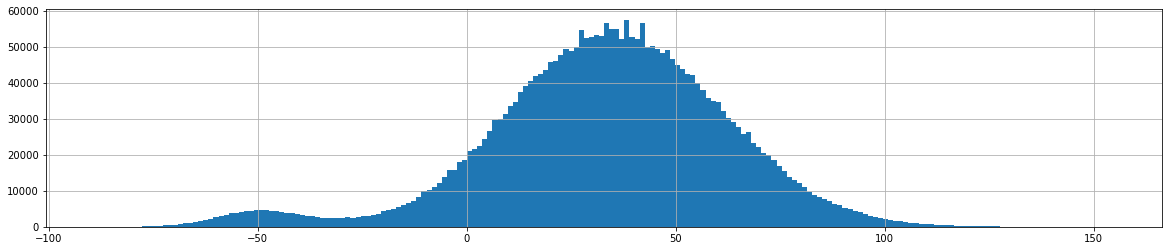

---------- 64 ----------


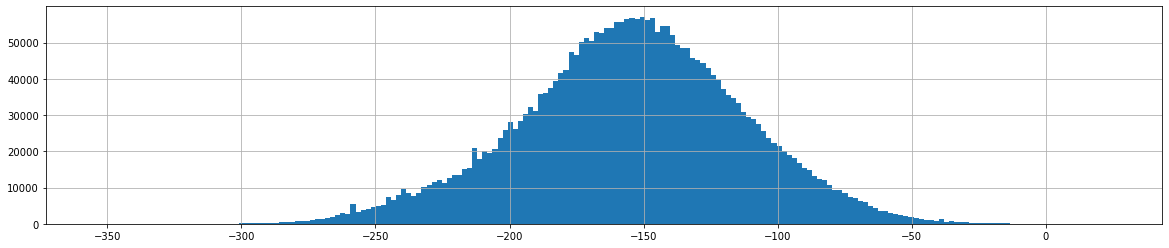

---------- 65 ----------


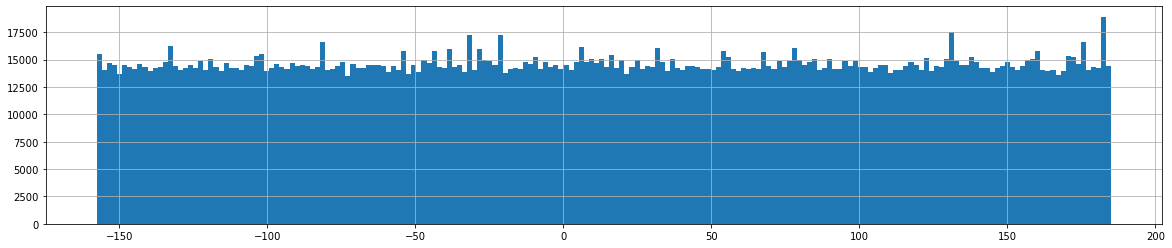

---------- 66 ----------


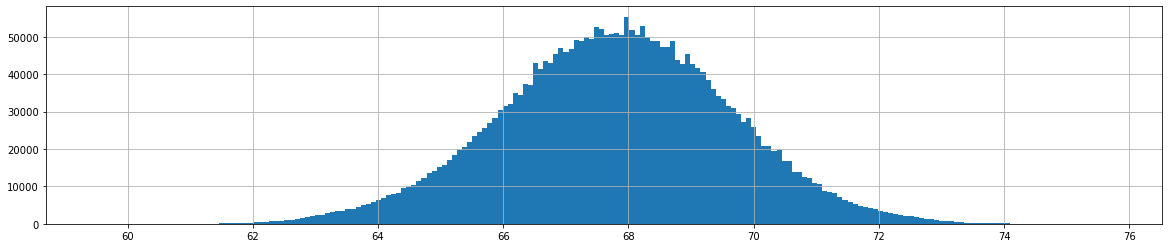

---------- 67 ----------


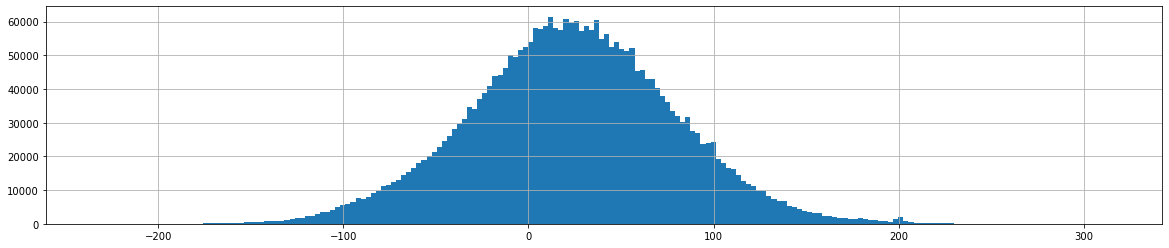

---------- 68 ----------


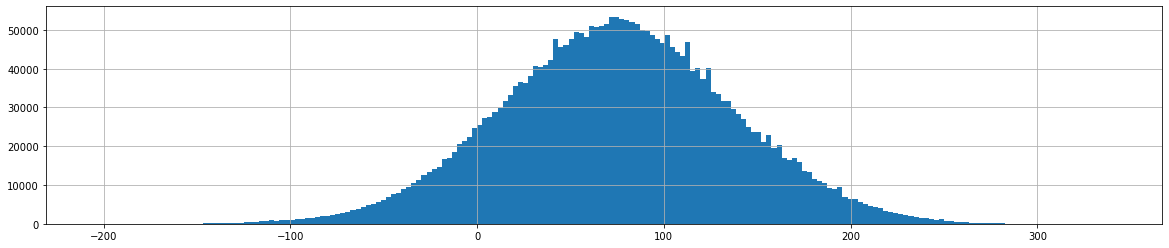

---------- 69 ----------


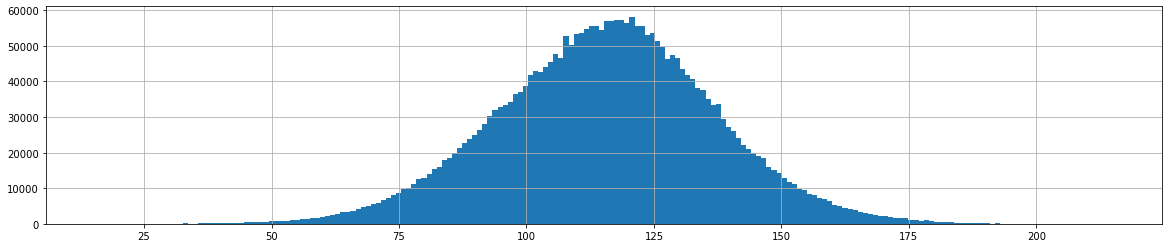

---------- 70 ----------


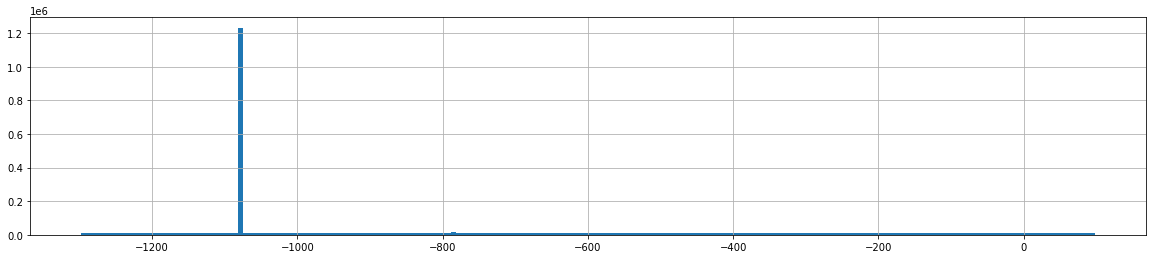

---------- 71 ----------


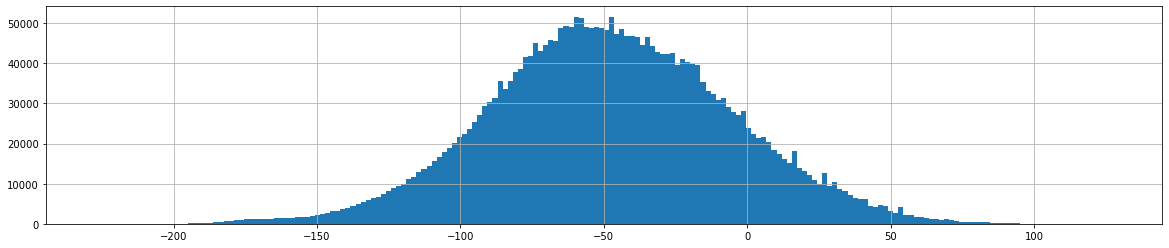

In [71]:
for i in base. columns:
    print('----------', i, '----------')
    base[i].hist(bins=200);
    plt.show()

В целом признаки похожи, различаются в основном диапазоном значений и некоторые размерности совершенно выбиваются из общей картины. Некоторые будто условно рандомные, а некоторые будто одинаковы для разных наблюдений за исключением некоторых значений. Попробую удалить такие признаки. Так же попробую нормализовать признаки.  
А пока сравним с train.

## Train

In [72]:
train. columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'Target'],
      dtype='object')

In [73]:
train['Target']

Id
0-query         675816-base
1-query         366656-base
2-query        1447819-base
3-query        1472602-base
4-query         717819-base
                   ...     
99995-query     811868-base
99996-query    1460772-base
99997-query    2366140-base
99998-query       9252-base
99999-query    2769109-base
Name: Target, Length: 100000, dtype: object

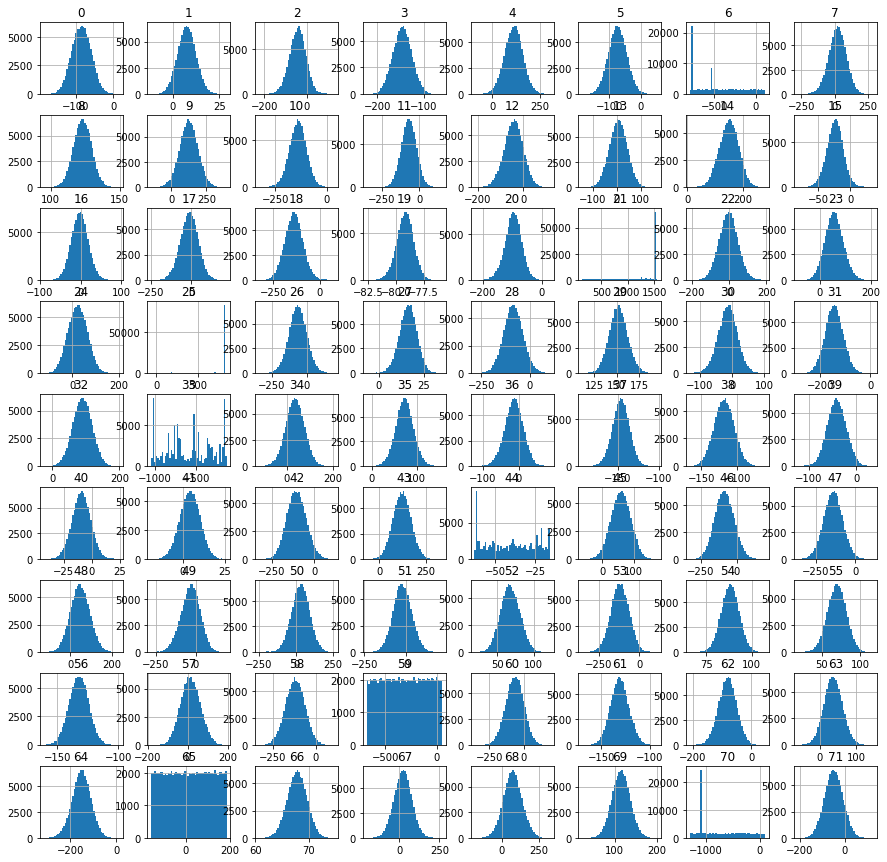

In [74]:
train. hist(figsize=(15,15), bins=50);

---------- 0 ----------


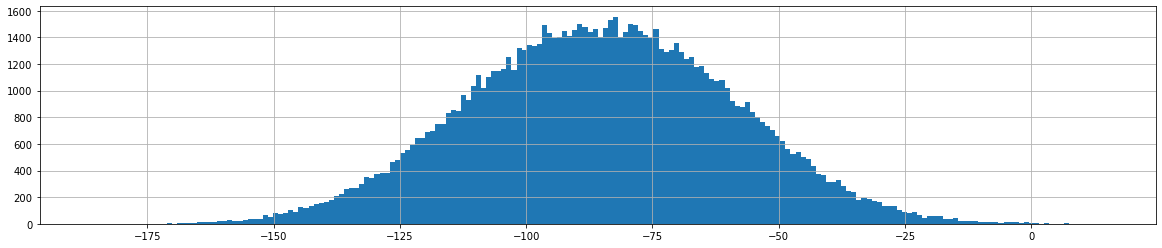

---------- 1 ----------


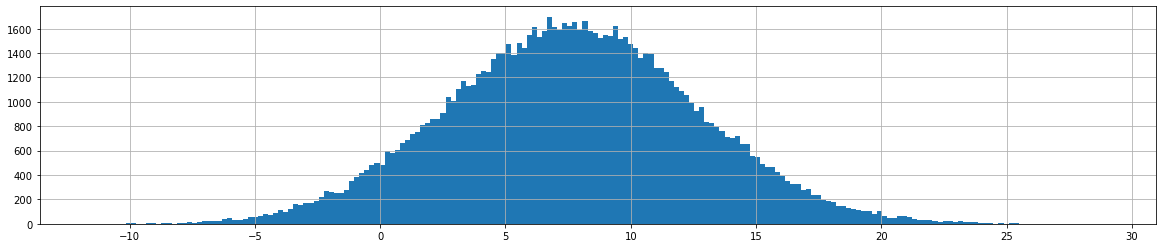

---------- 2 ----------


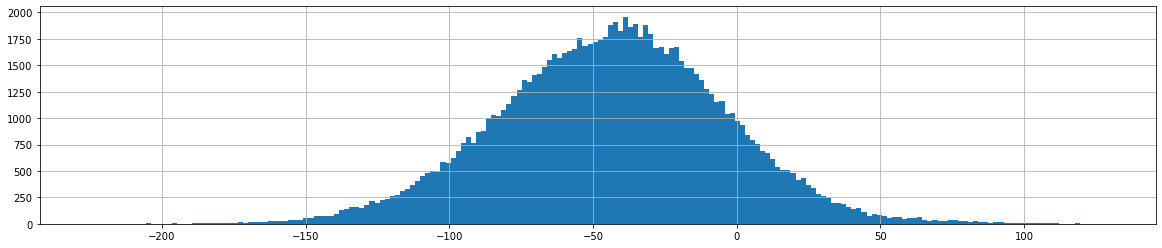

---------- 3 ----------


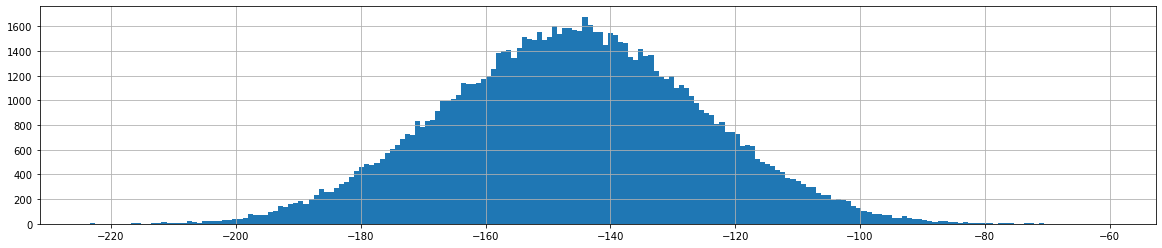

---------- 4 ----------


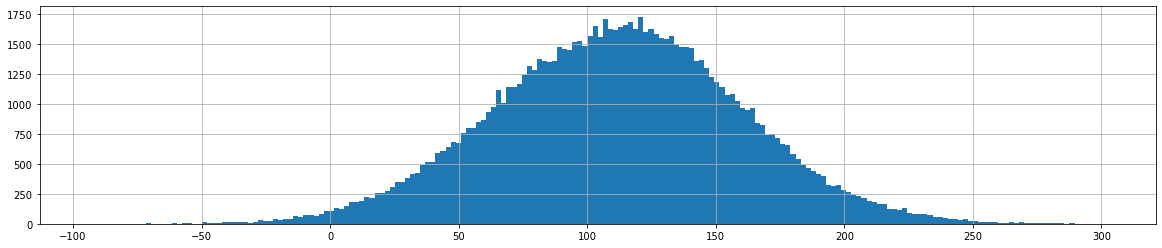

---------- 5 ----------


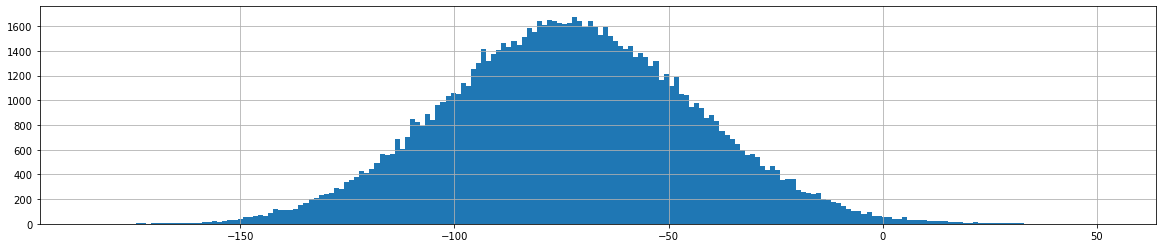

---------- 6 ----------


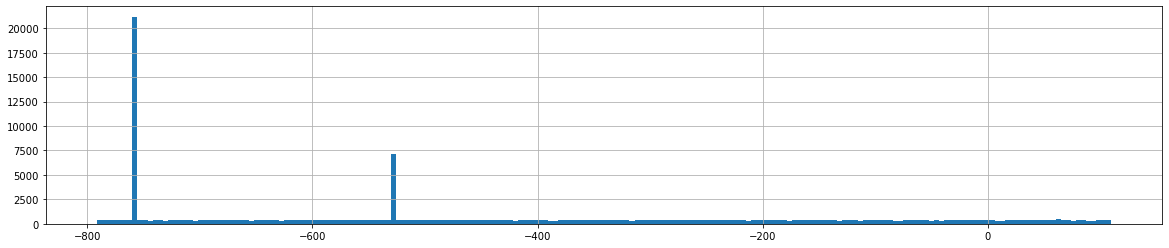

---------- 7 ----------


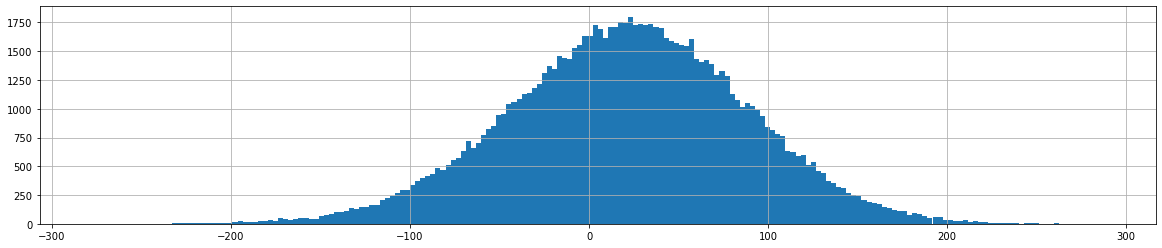

---------- 8 ----------


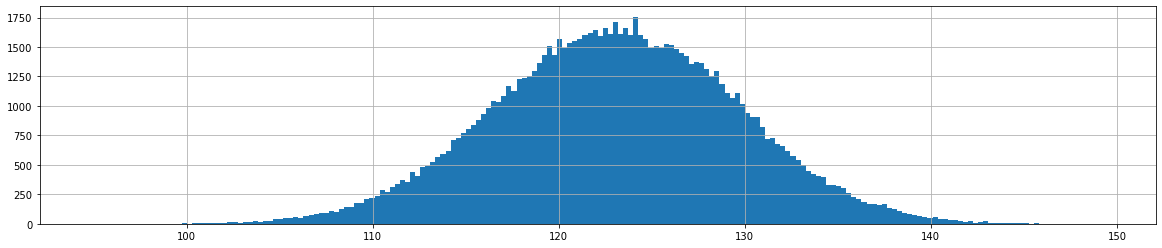

---------- 9 ----------


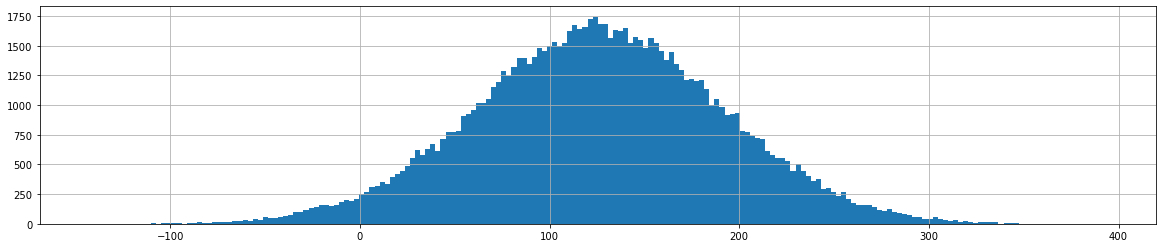

---------- 10 ----------


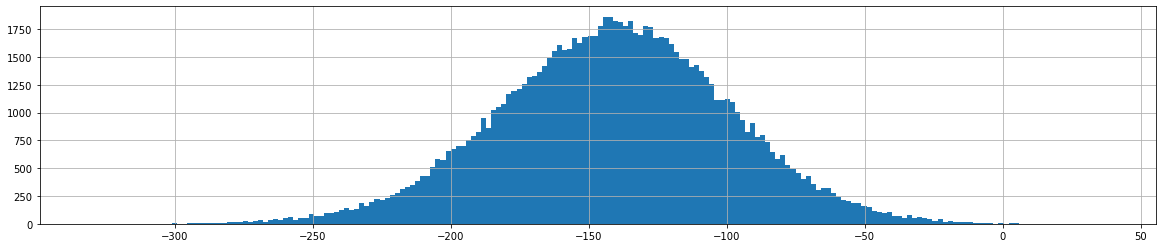

---------- 11 ----------


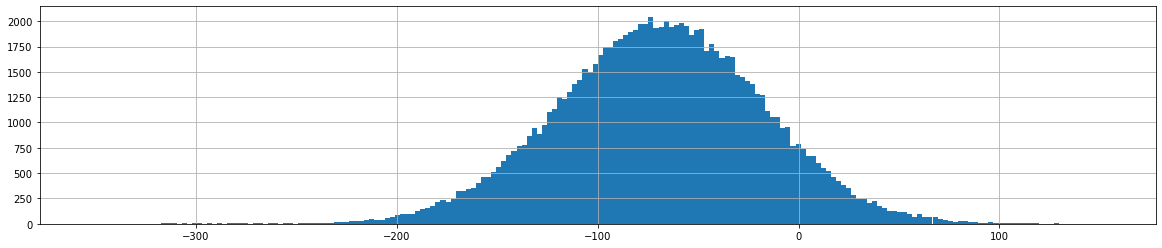

---------- 12 ----------


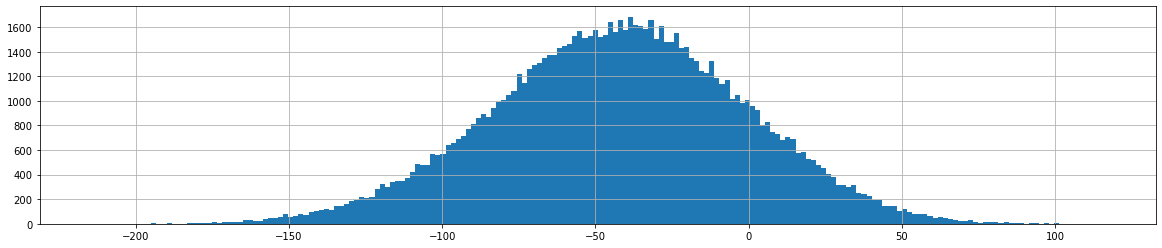

---------- 13 ----------


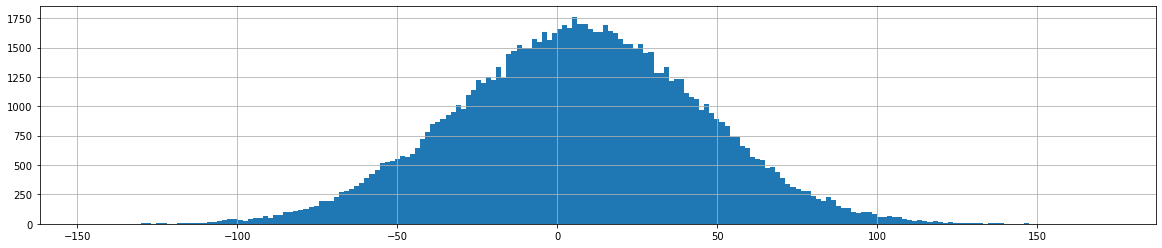

---------- 14 ----------


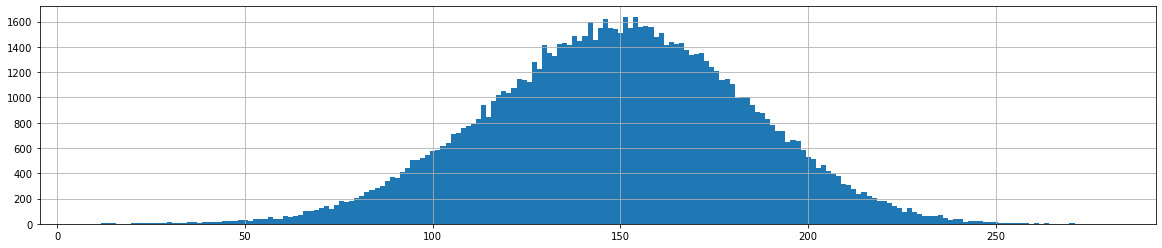

---------- 15 ----------


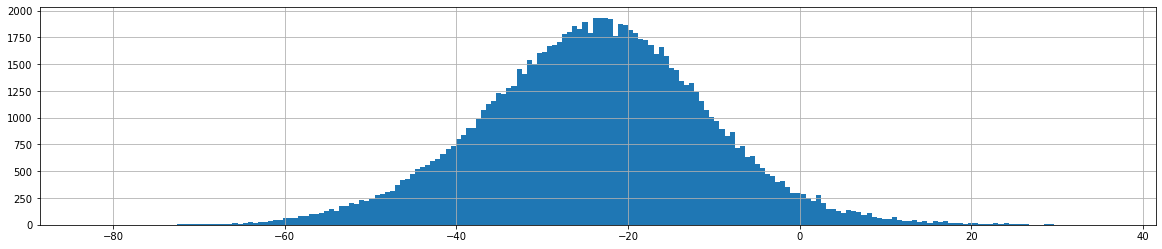

---------- 16 ----------


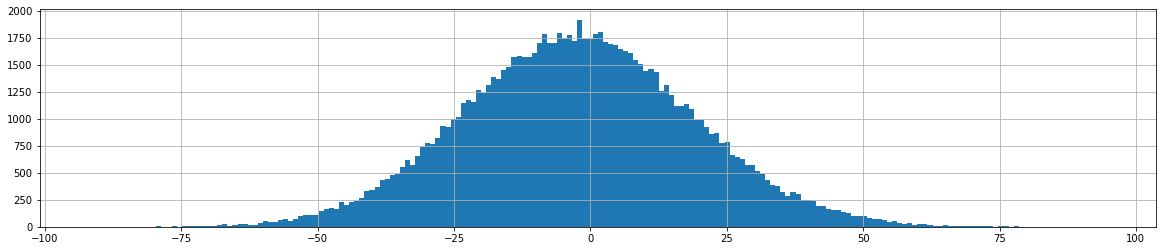

---------- 17 ----------


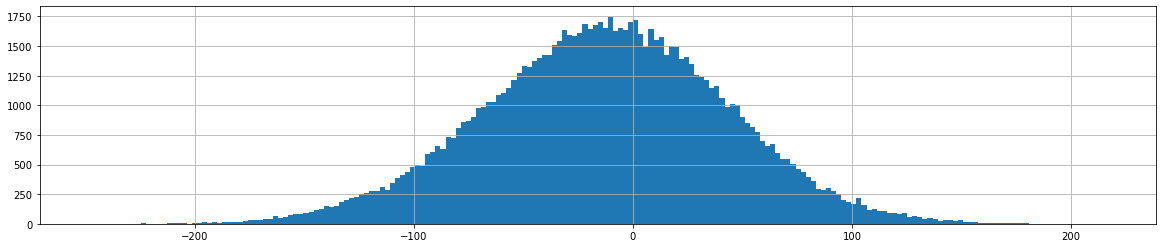

---------- 18 ----------


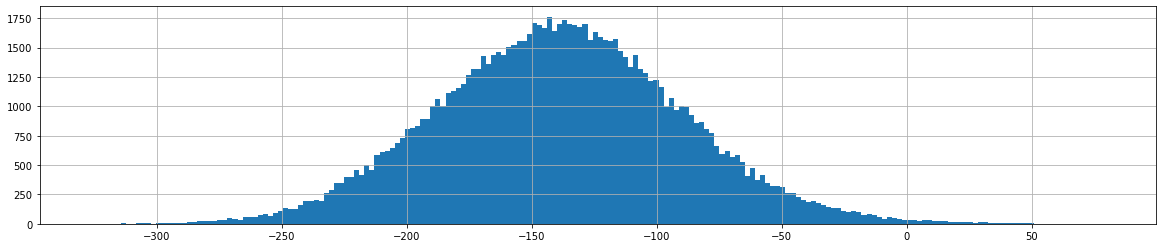

---------- 19 ----------


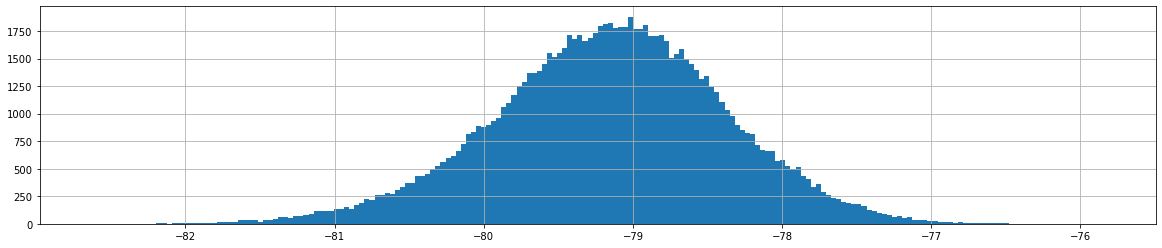

---------- 20 ----------


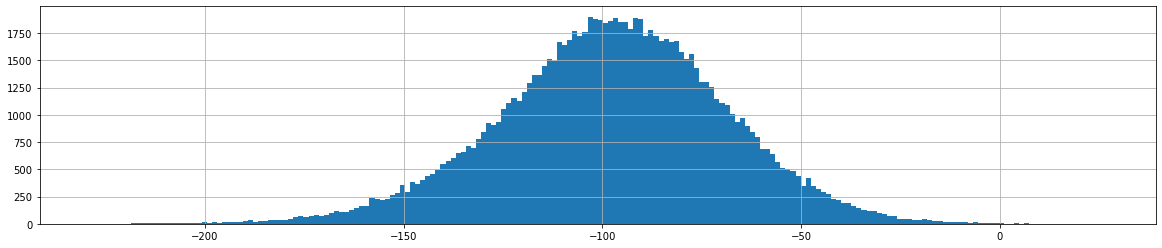

---------- 21 ----------


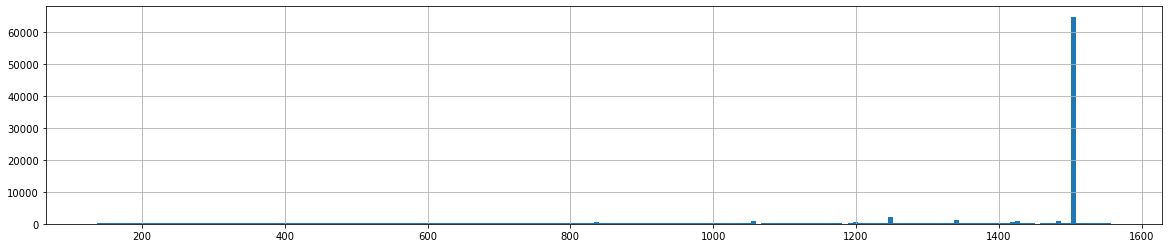

---------- 22 ----------


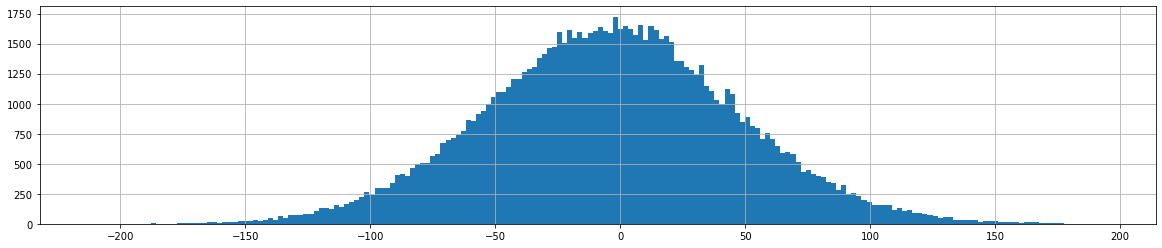

---------- 23 ----------


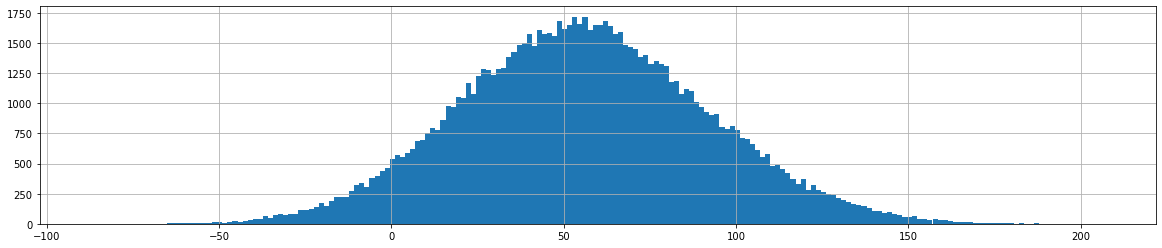

---------- 24 ----------


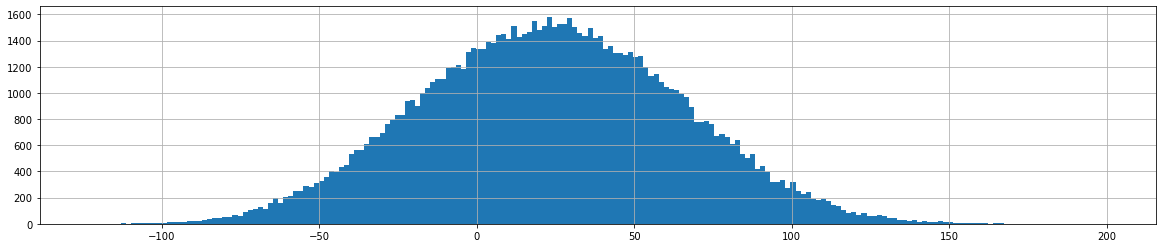

---------- 25 ----------


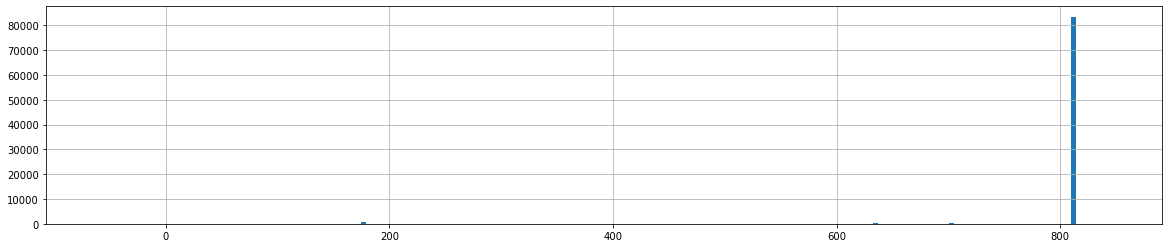

---------- 26 ----------


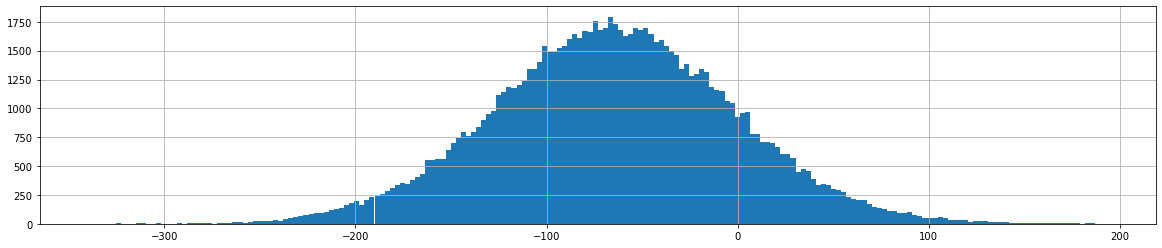

---------- 27 ----------


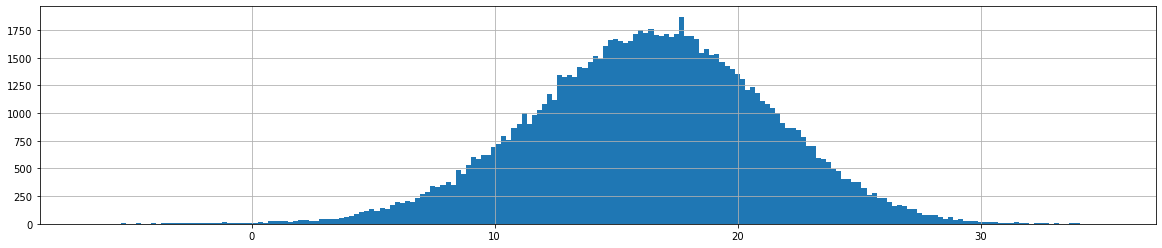

---------- 28 ----------


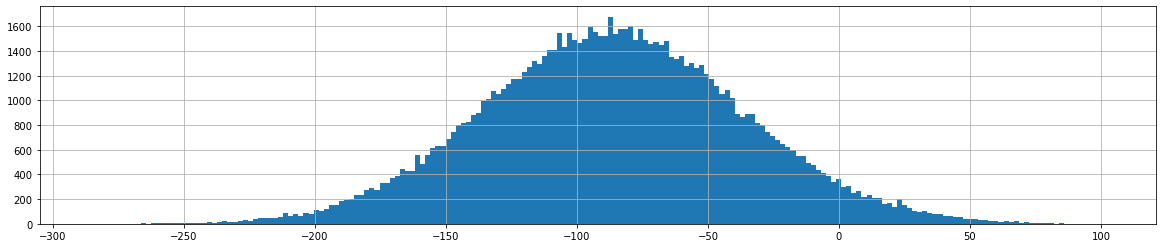

---------- 29 ----------


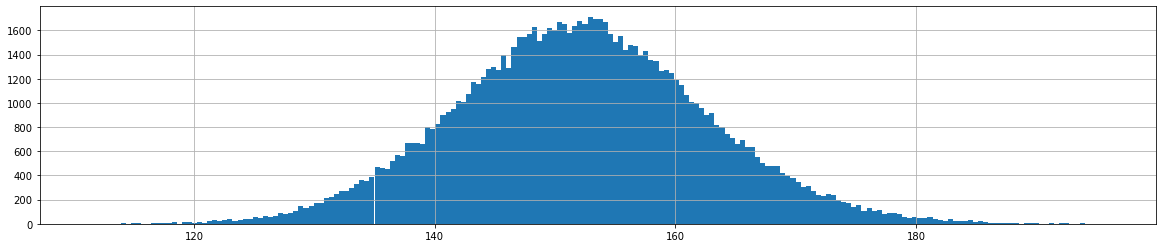

---------- 30 ----------


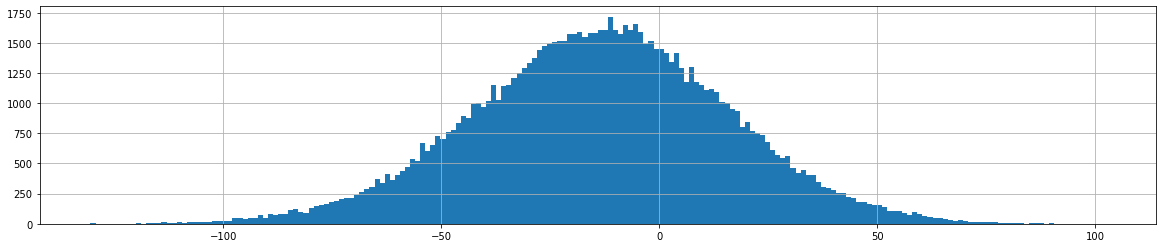

---------- 31 ----------


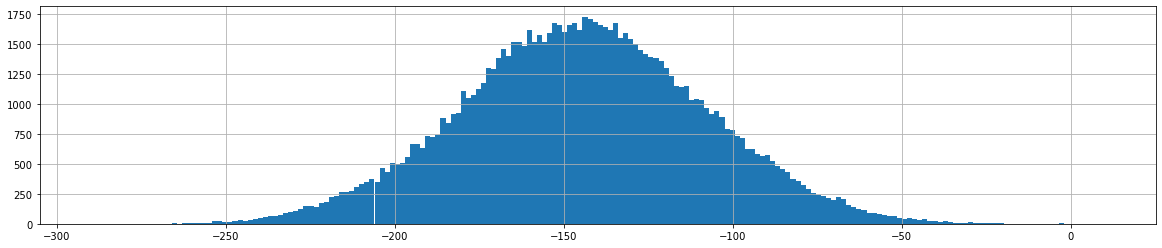

---------- 32 ----------


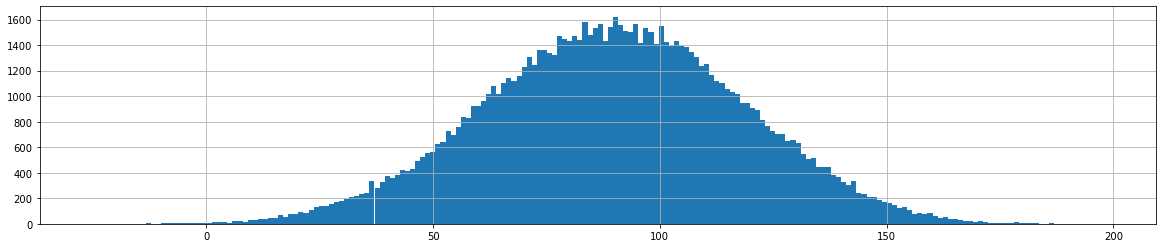

---------- 33 ----------


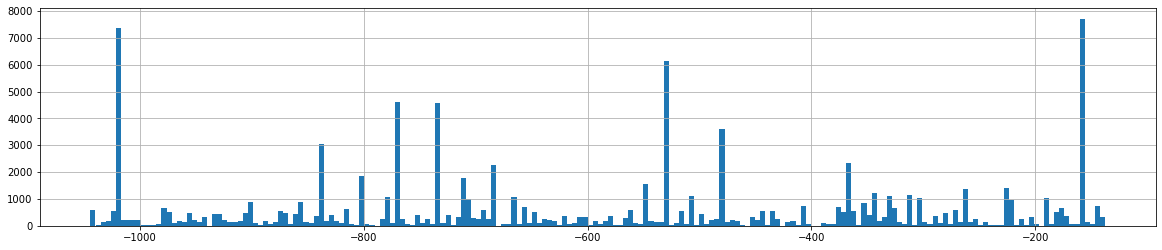

---------- 34 ----------


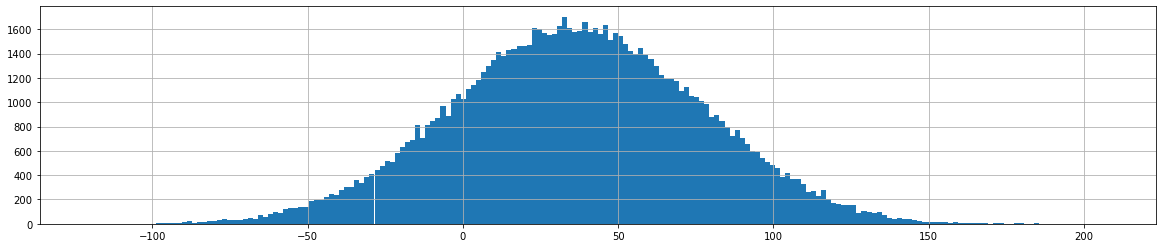

---------- 35 ----------


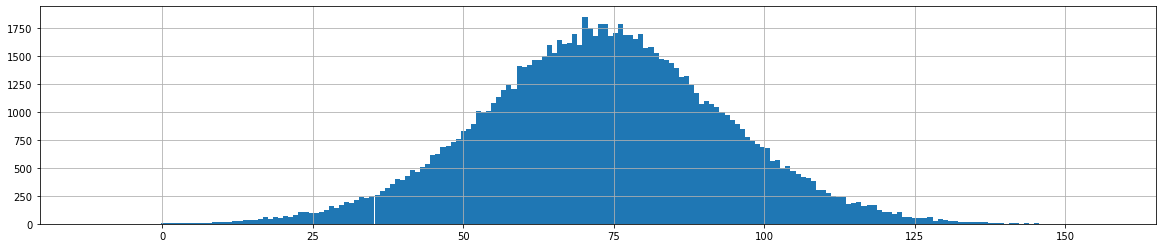

---------- 36 ----------


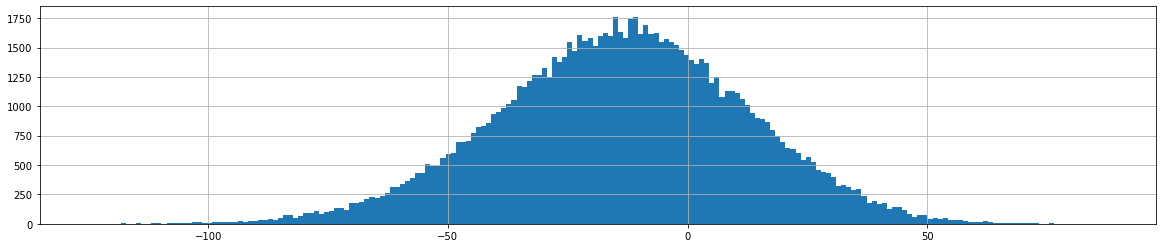

---------- 37 ----------


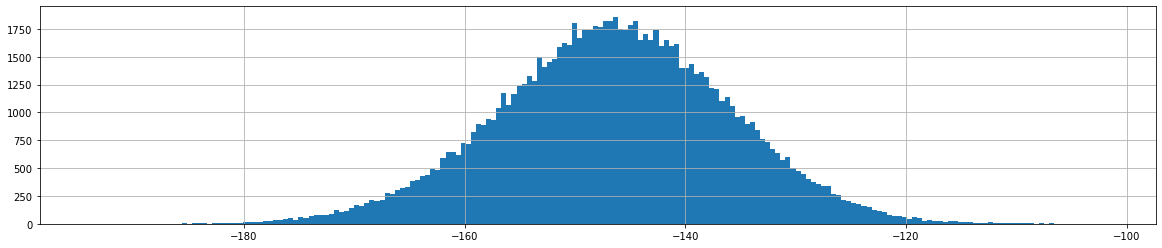

---------- 38 ----------


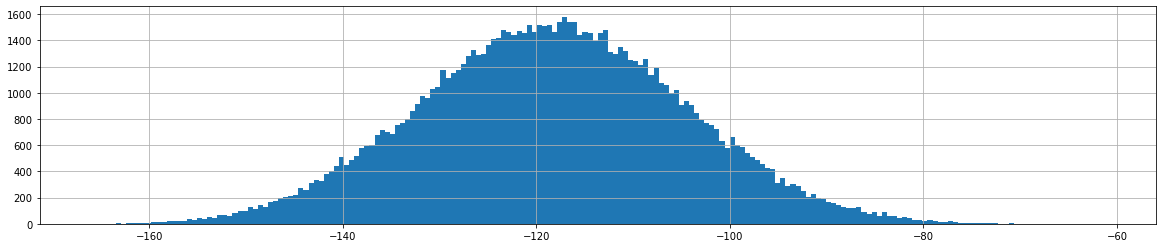

---------- 39 ----------


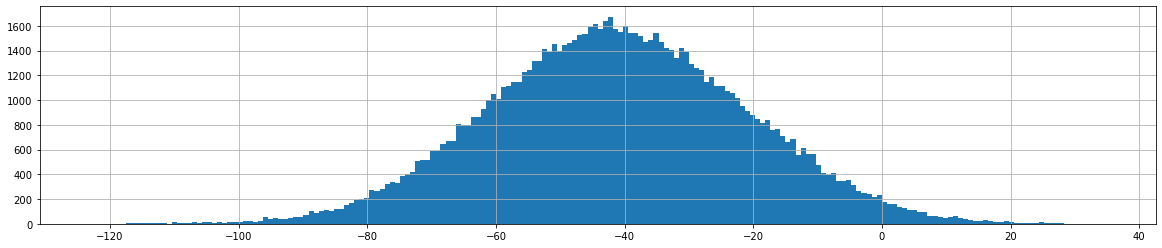

---------- 40 ----------


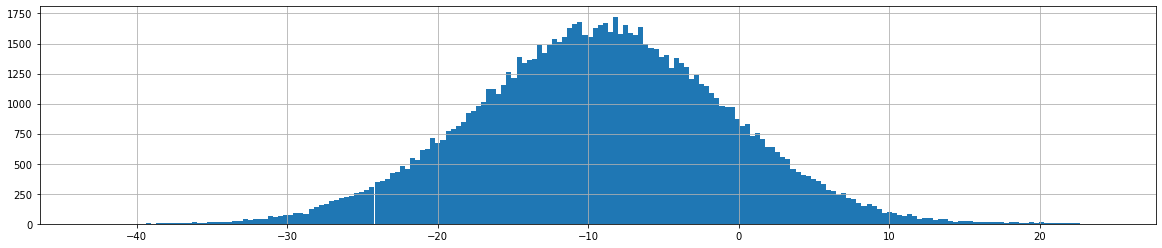

---------- 41 ----------


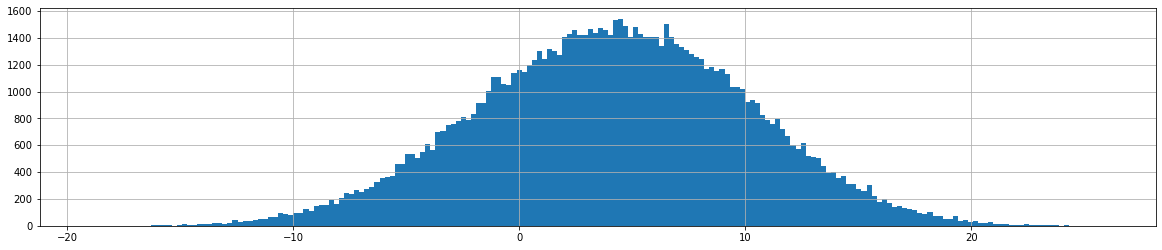

---------- 42 ----------


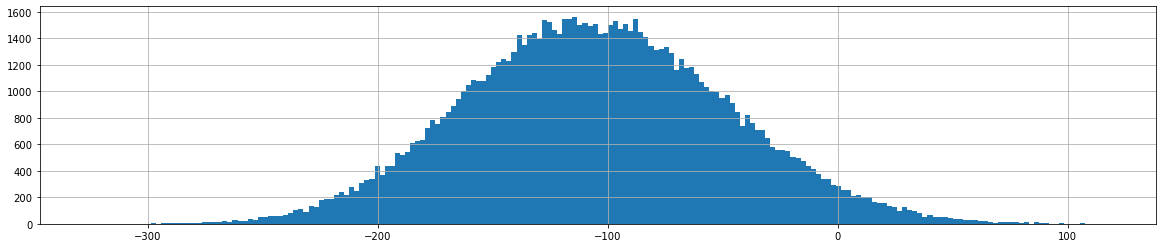

---------- 43 ----------


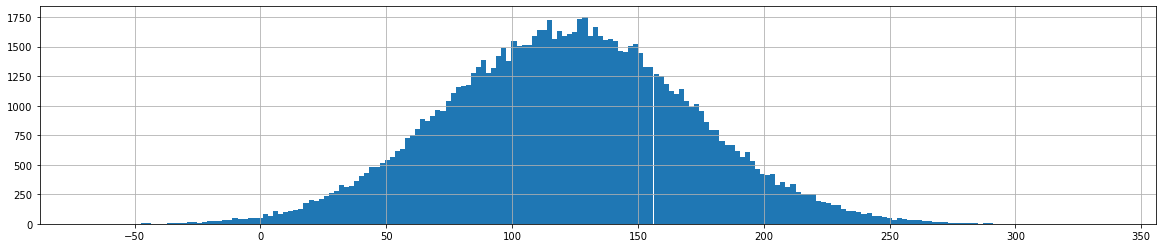

---------- 44 ----------


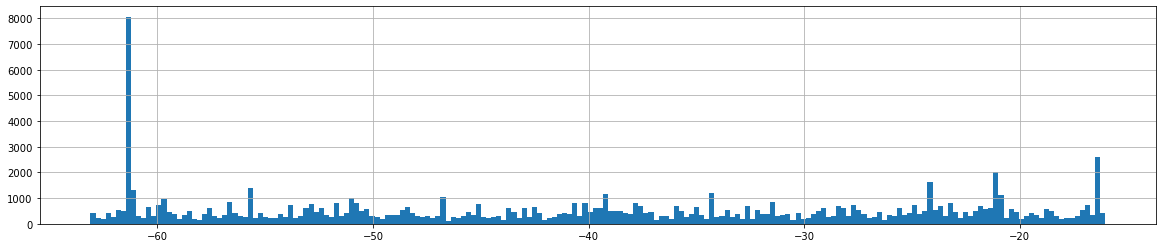

---------- 45 ----------


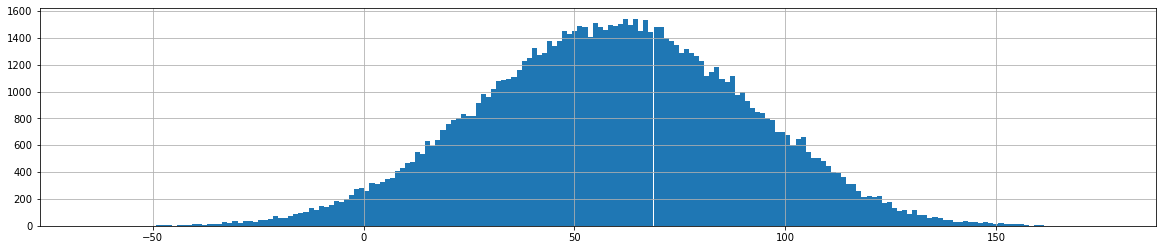

---------- 46 ----------


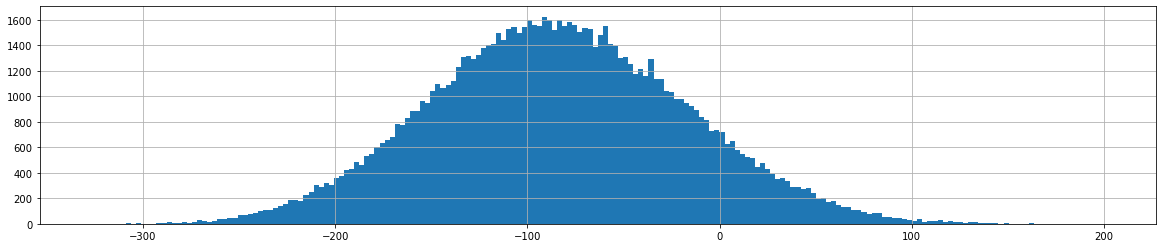

---------- 47 ----------


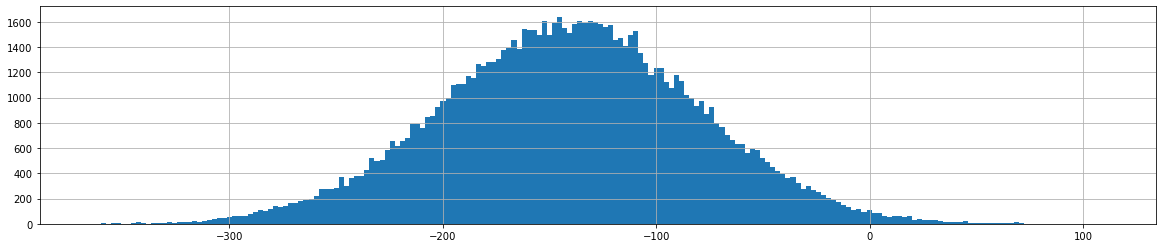

---------- 48 ----------


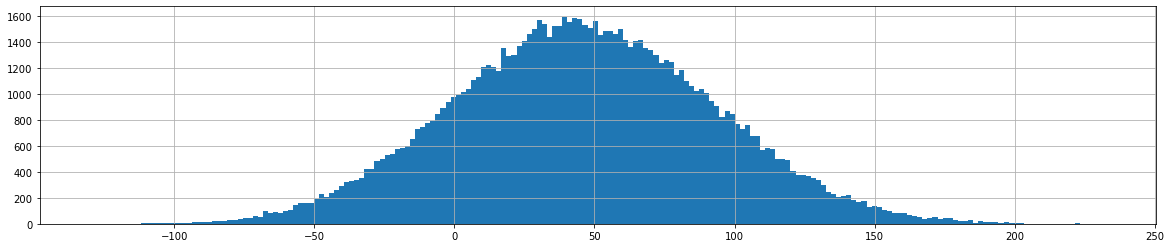

---------- 49 ----------


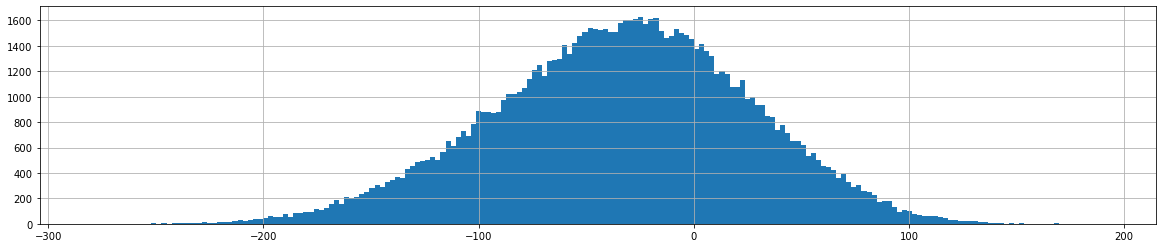

---------- 50 ----------


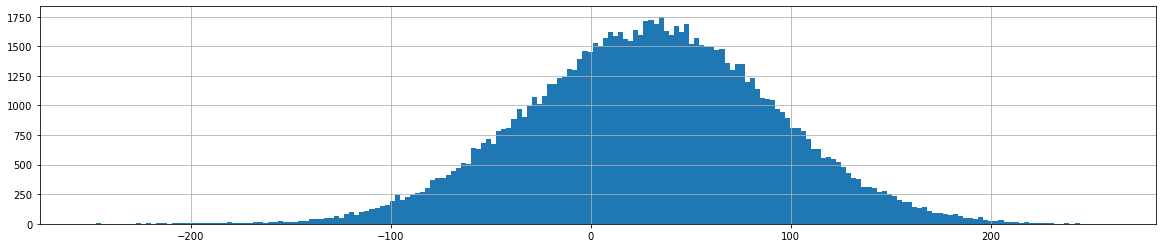

---------- 51 ----------


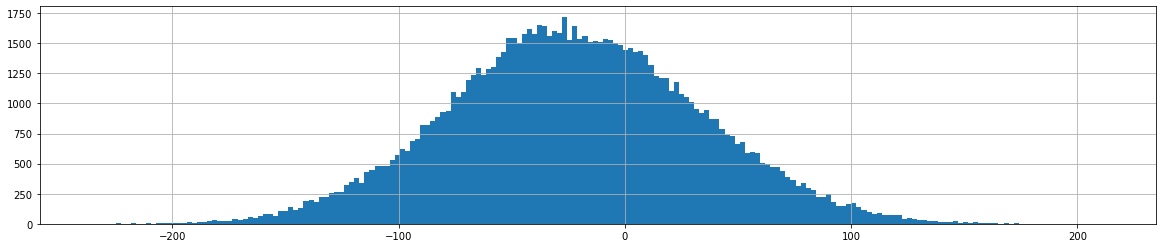

---------- 52 ----------


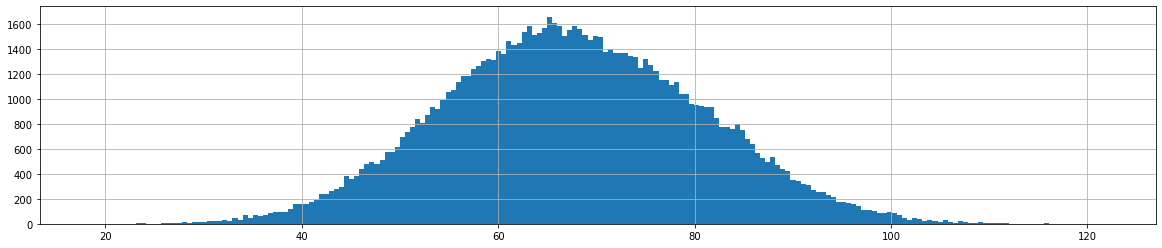

---------- 53 ----------


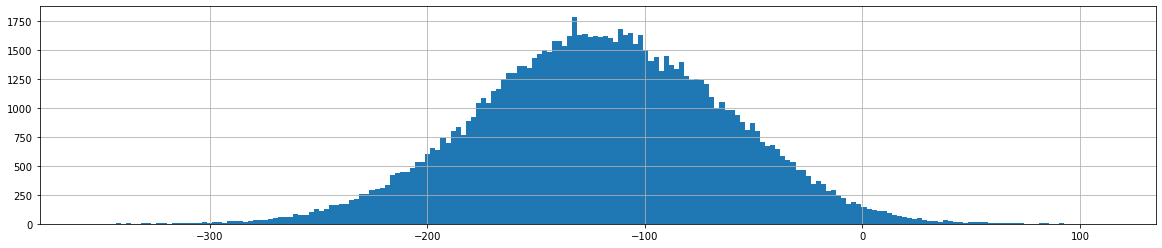

---------- 54 ----------


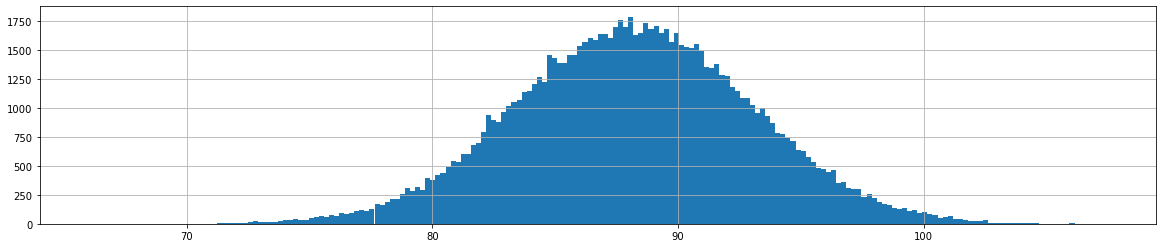

---------- 55 ----------


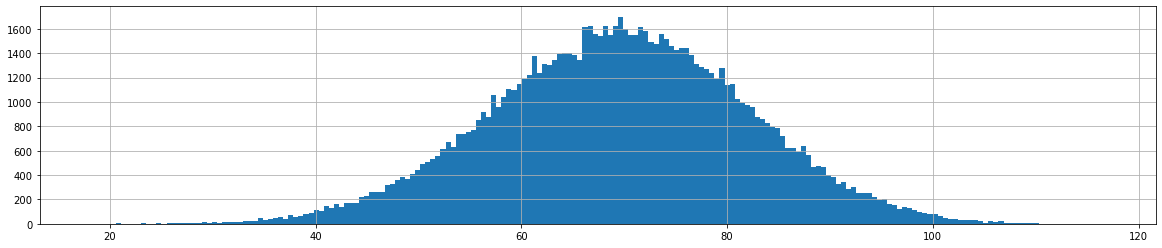

---------- 56 ----------


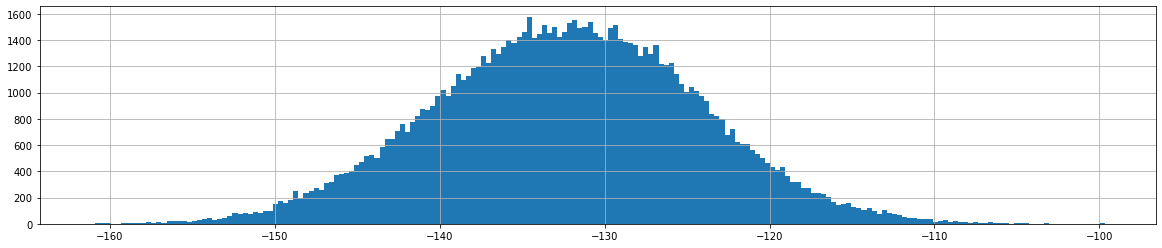

---------- 57 ----------


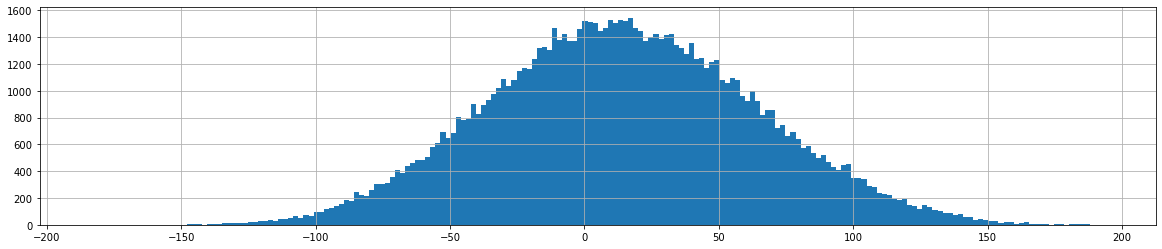

---------- 58 ----------


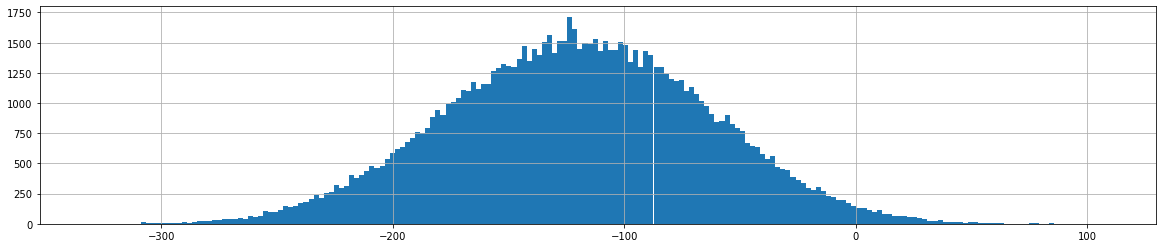

---------- 59 ----------


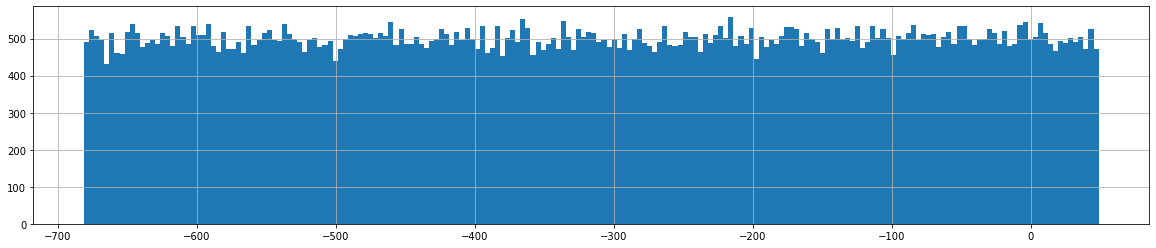

---------- 60 ----------


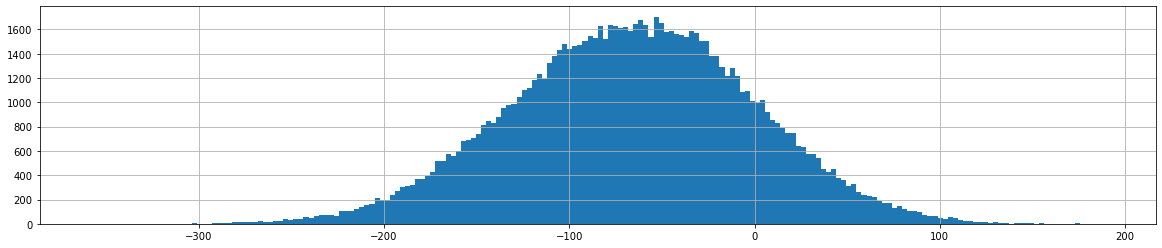

---------- 61 ----------


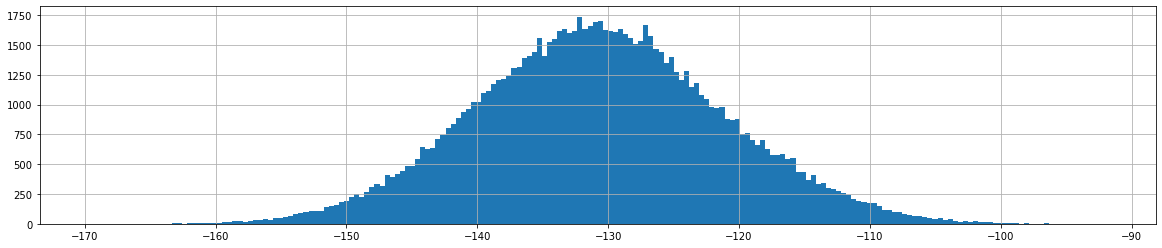

---------- 62 ----------


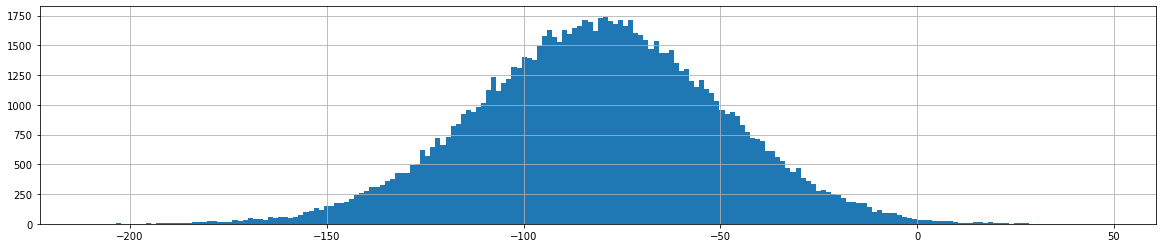

---------- 63 ----------


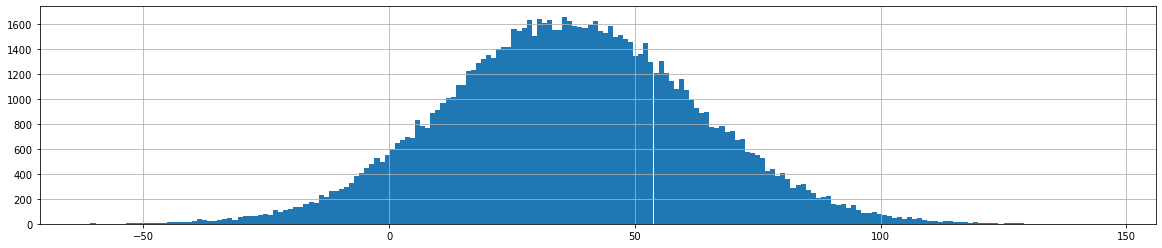

---------- 64 ----------


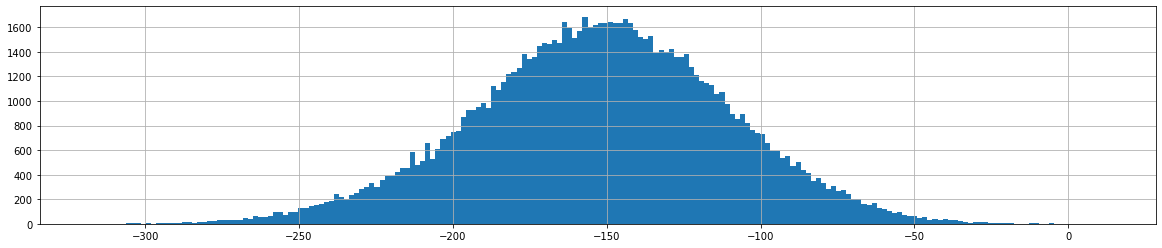

---------- 65 ----------


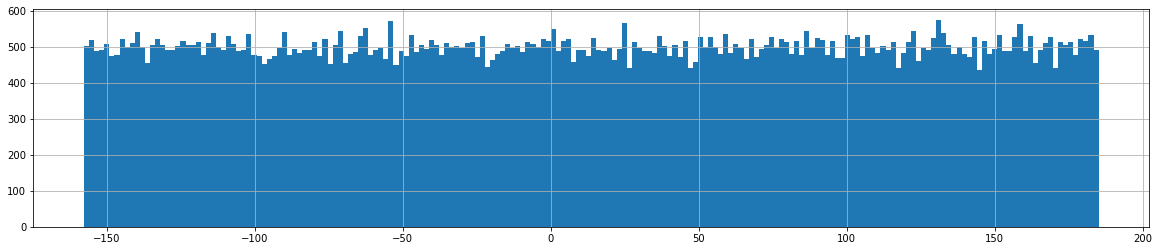

---------- 66 ----------


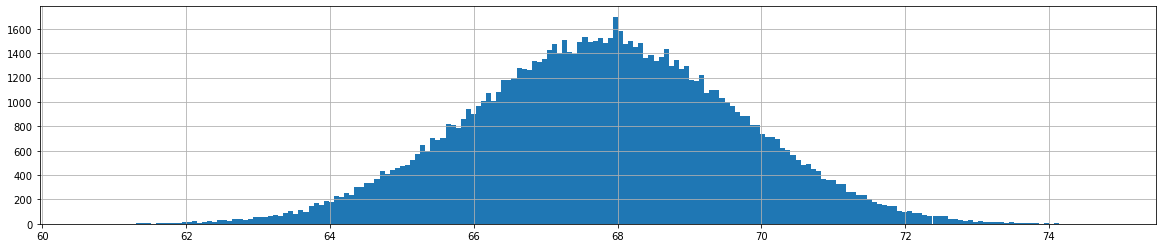

---------- 67 ----------


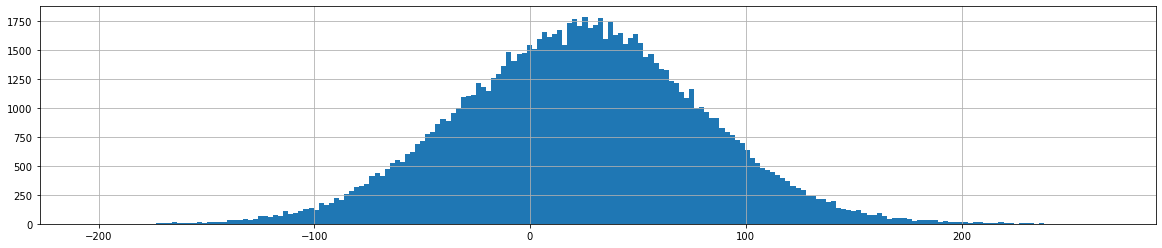

---------- 68 ----------


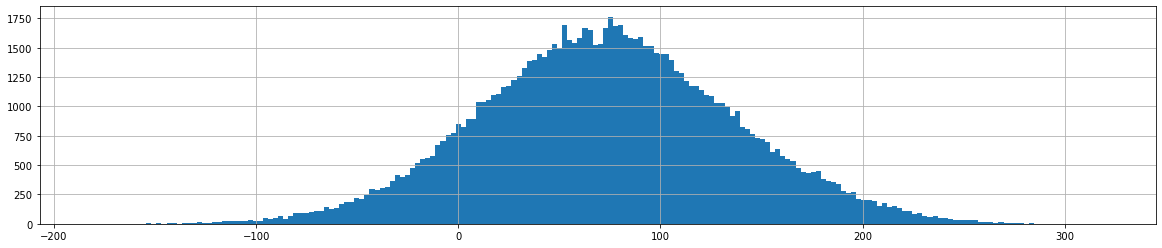

---------- 69 ----------


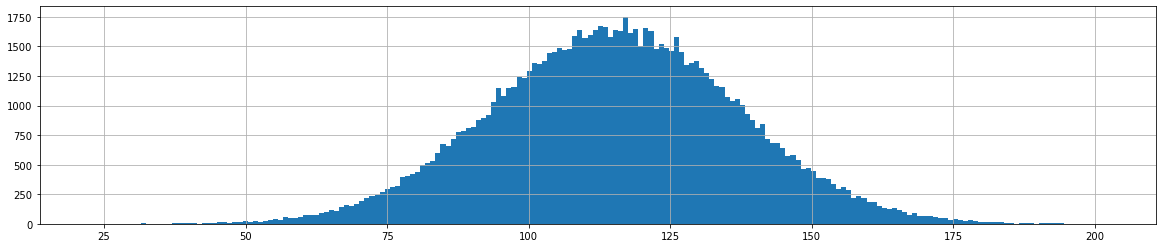

---------- 70 ----------


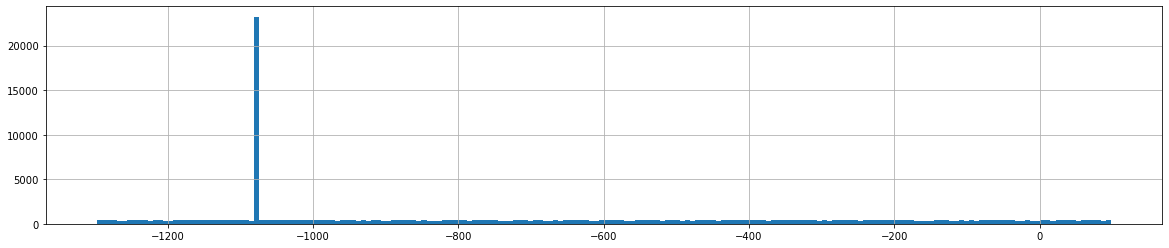

---------- 71 ----------


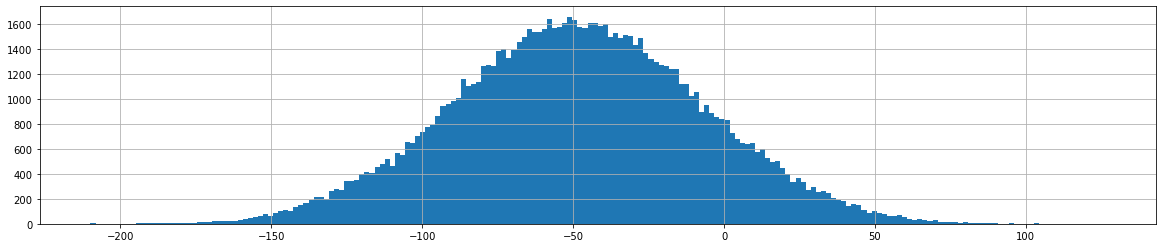

In [75]:
for i in train. drop('Target', axis=1). columns:
    print('----------', i, '----------')
    train[i].hist(bins=200);
    plt.show()

В целом данные похожи, но так же имеются и заметные отличия. Заметнее всего на 63-м признаке. Выбивающиеся признаки те же.

## Valid

In [76]:
valid. columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

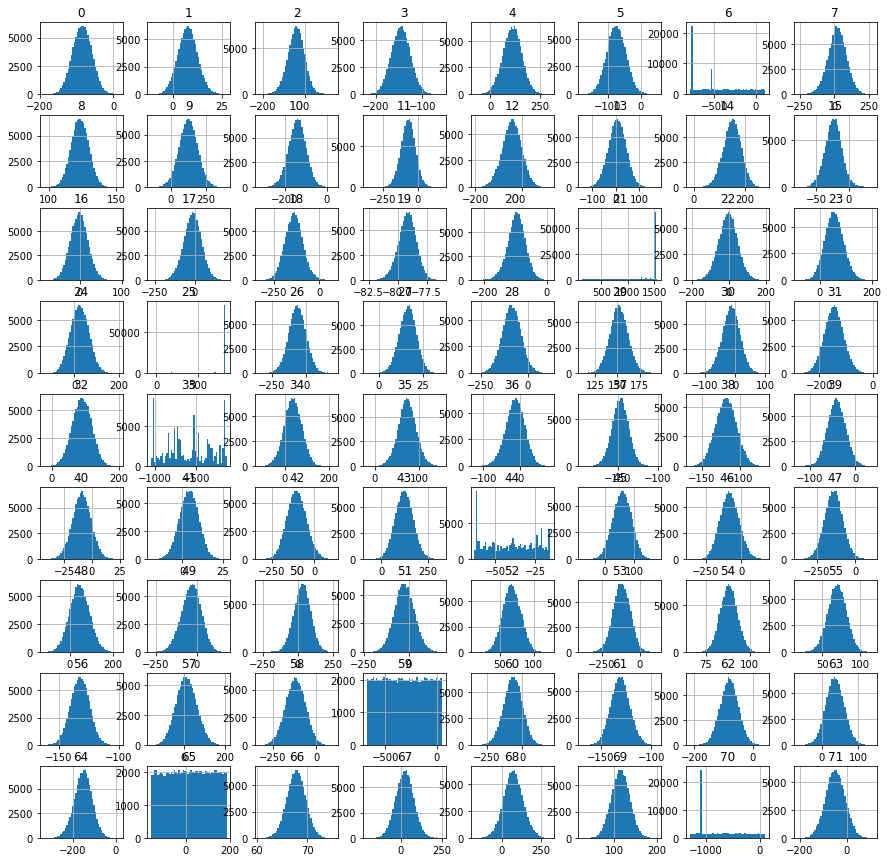

In [77]:
valid. hist(figsize=(15,15), bins=50);

---------- 0 ----------


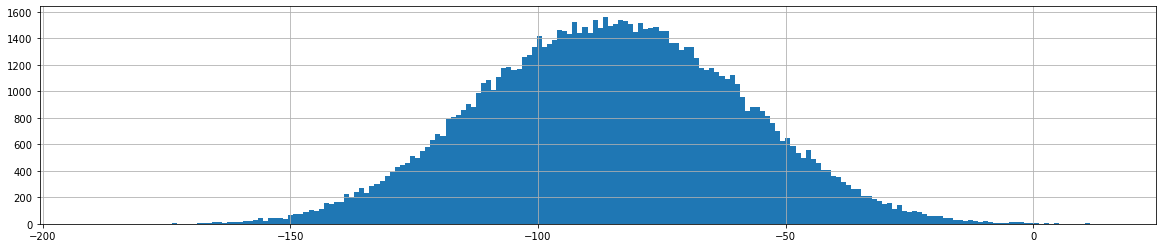

---------- 1 ----------


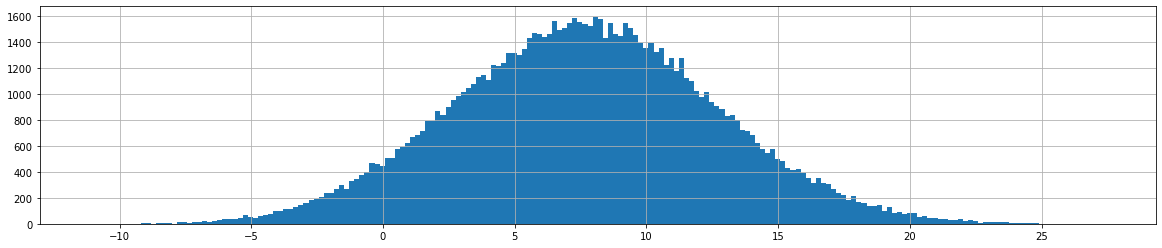

---------- 2 ----------


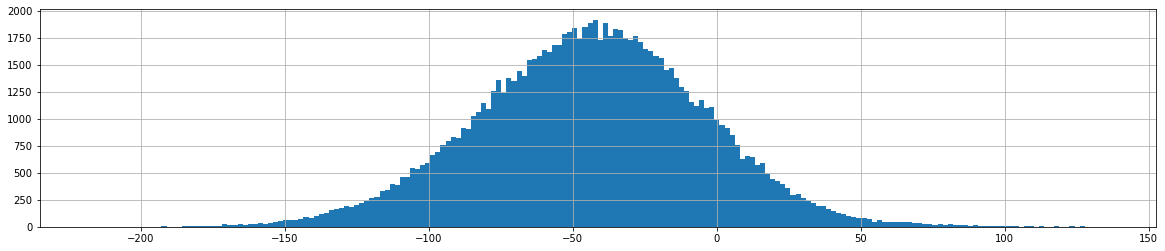

---------- 3 ----------


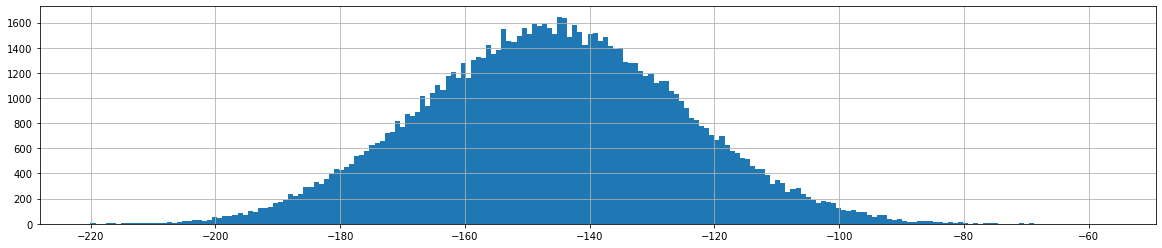

---------- 4 ----------


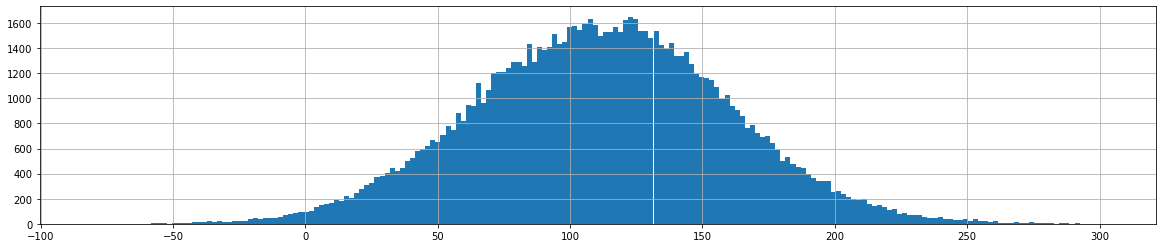

---------- 5 ----------


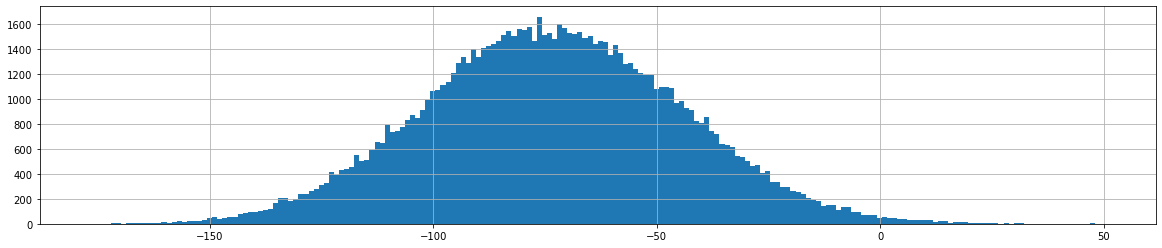

---------- 6 ----------


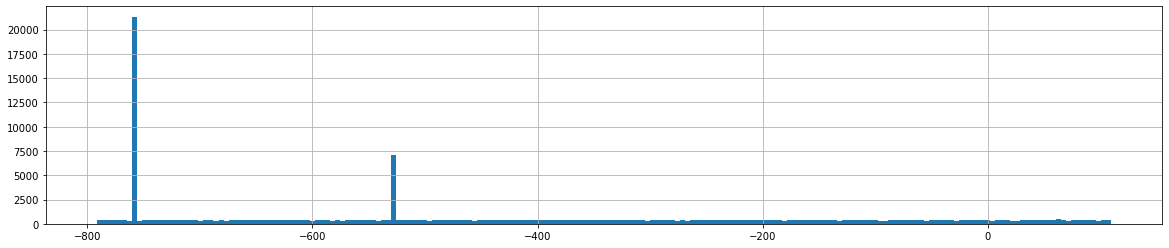

---------- 7 ----------


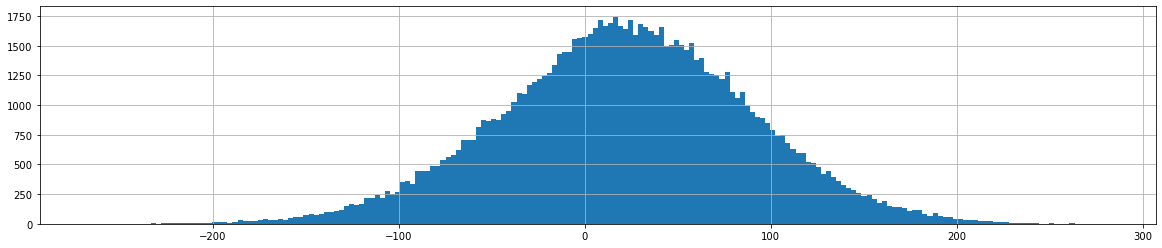

---------- 8 ----------


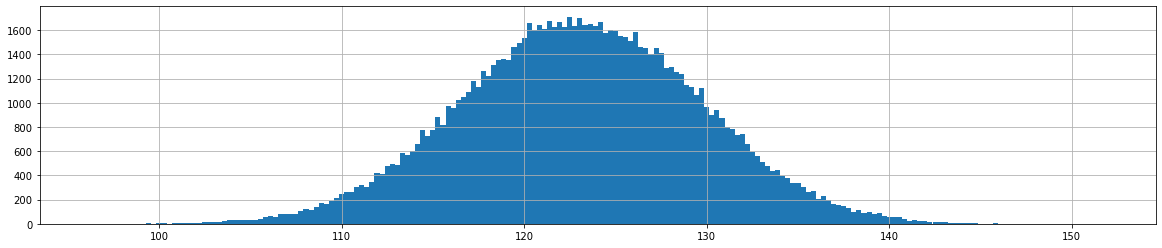

---------- 9 ----------


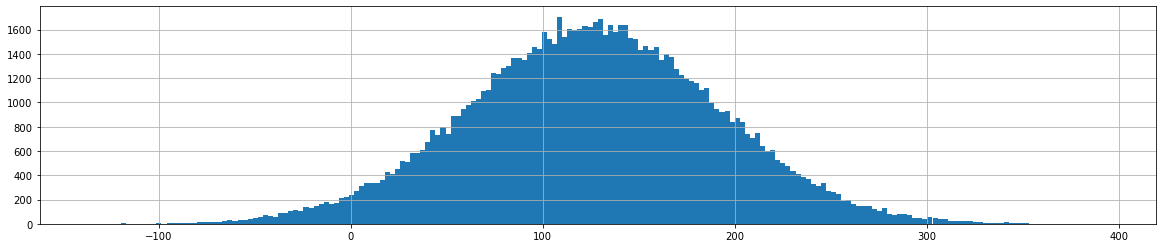

---------- 10 ----------


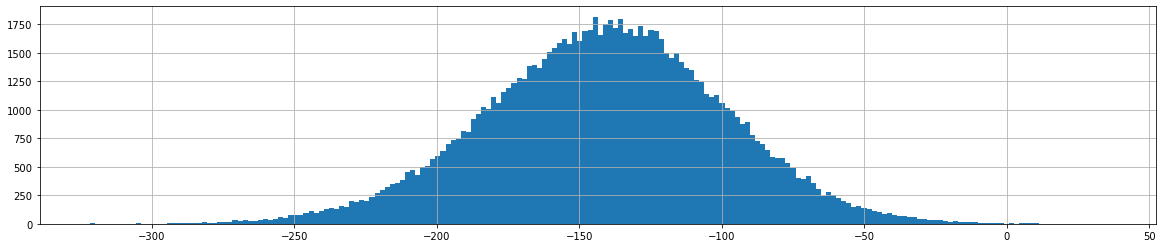

---------- 11 ----------


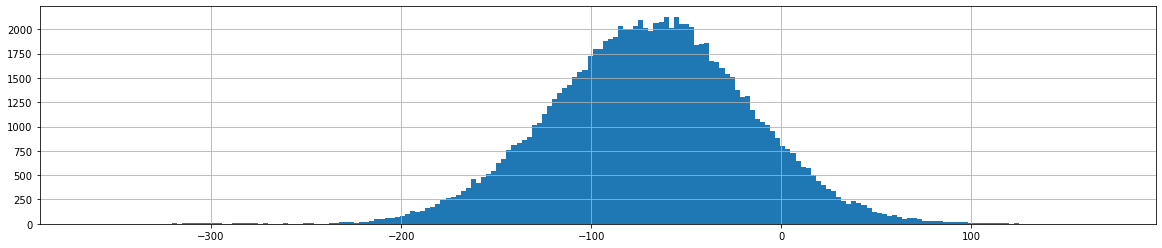

---------- 12 ----------


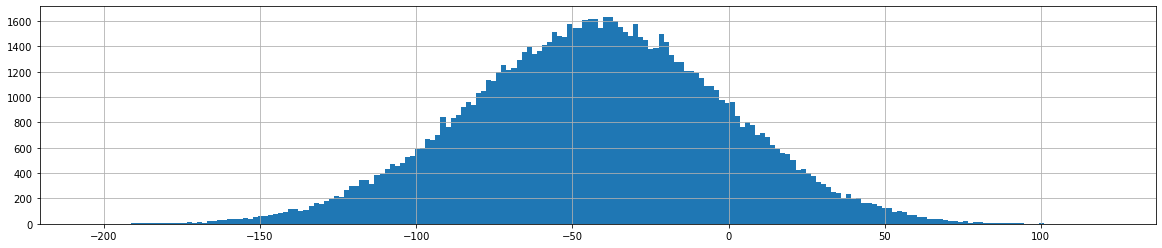

---------- 13 ----------


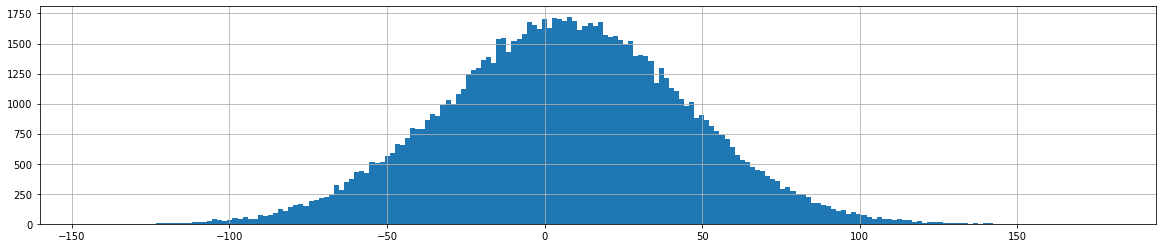

---------- 14 ----------


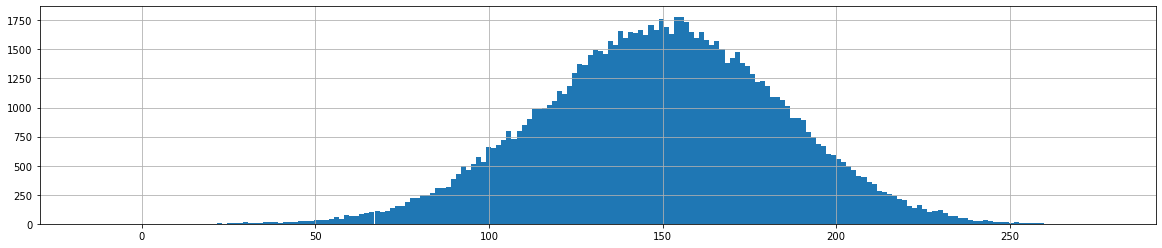

---------- 15 ----------


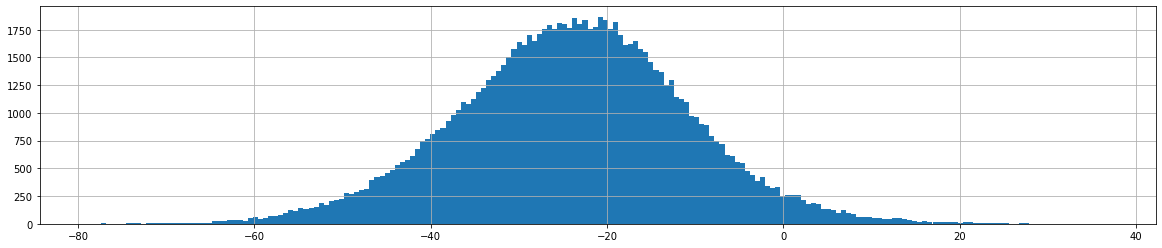

---------- 16 ----------


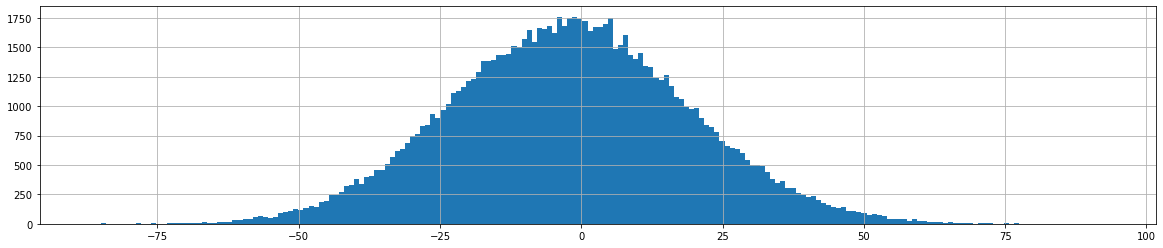

---------- 17 ----------


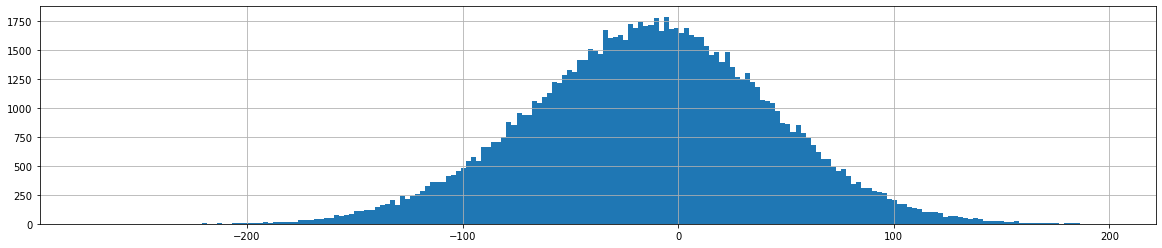

---------- 18 ----------


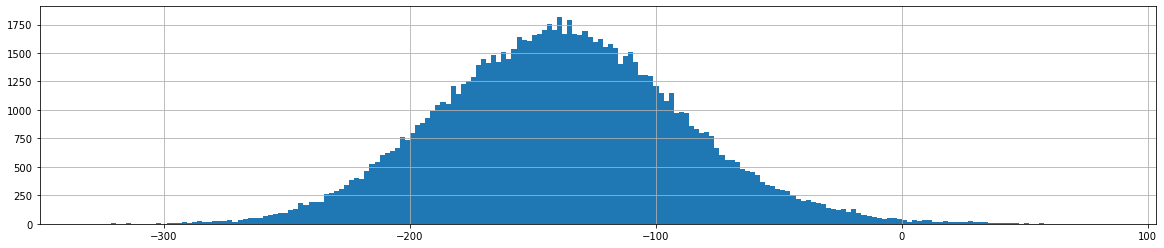

---------- 19 ----------


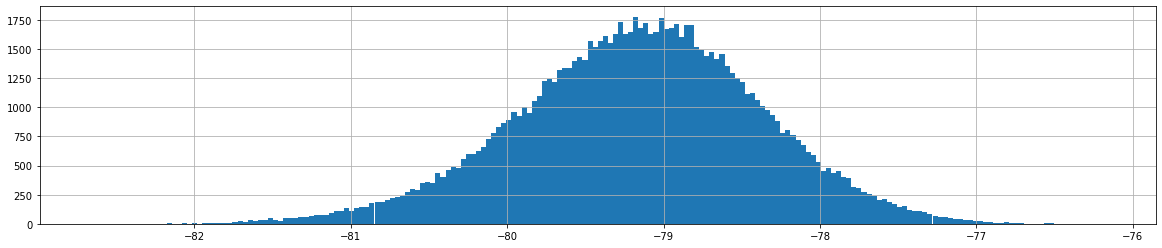

---------- 20 ----------


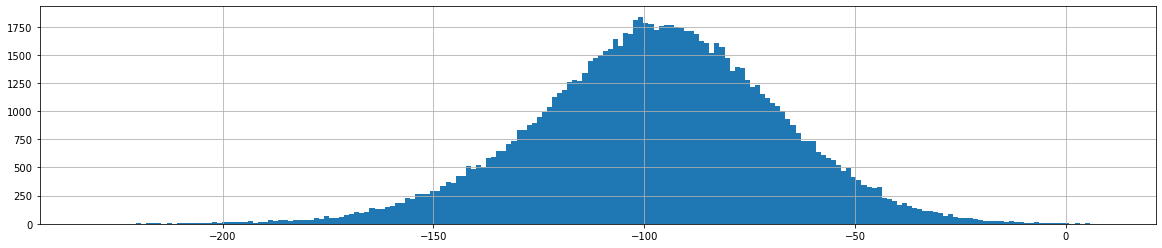

---------- 21 ----------


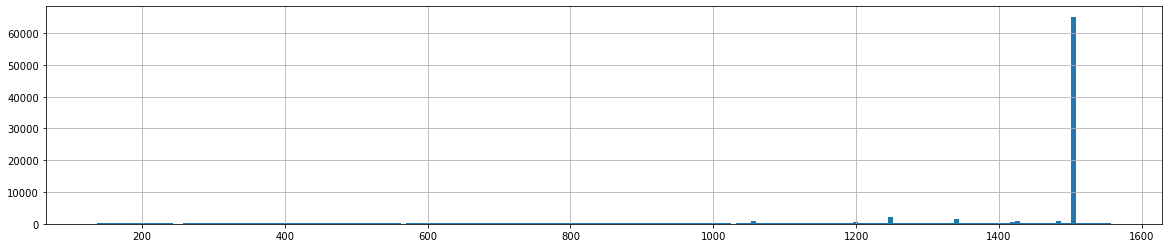

---------- 22 ----------


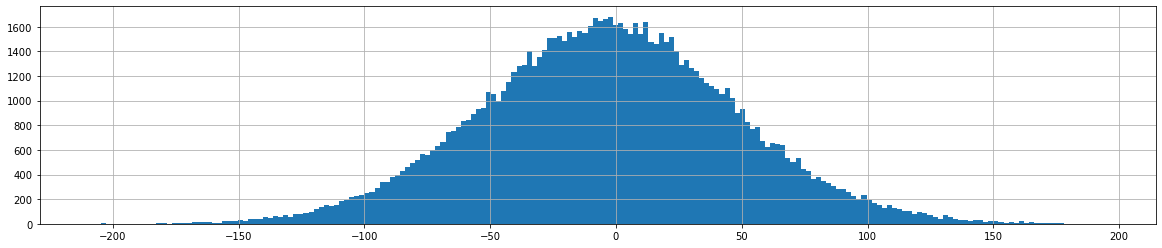

---------- 23 ----------


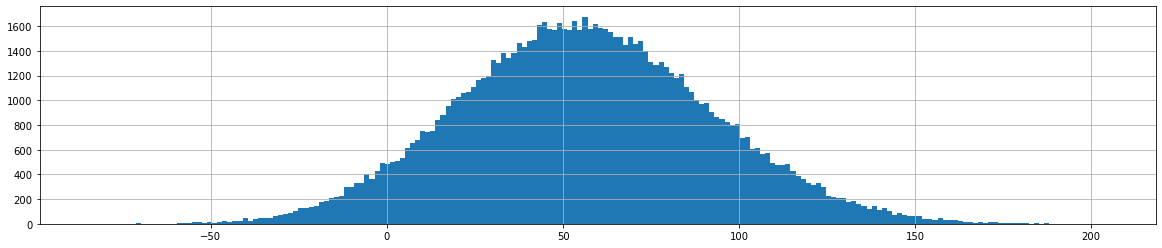

---------- 24 ----------


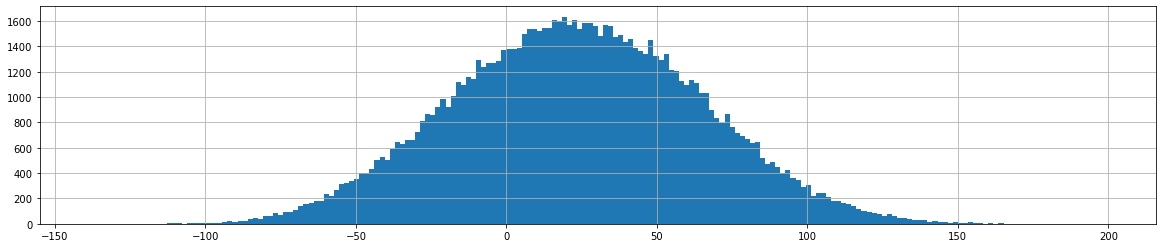

---------- 25 ----------


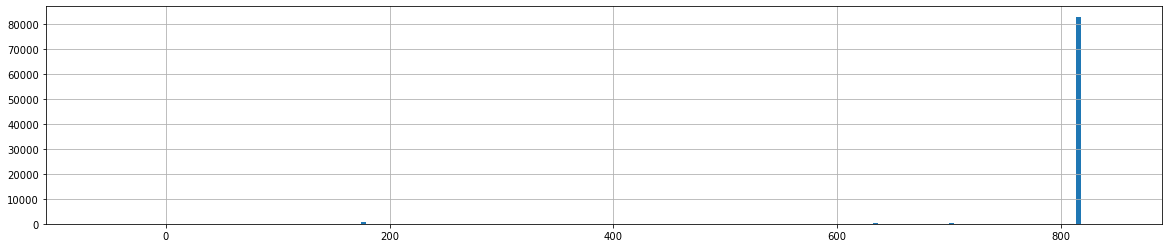

---------- 26 ----------


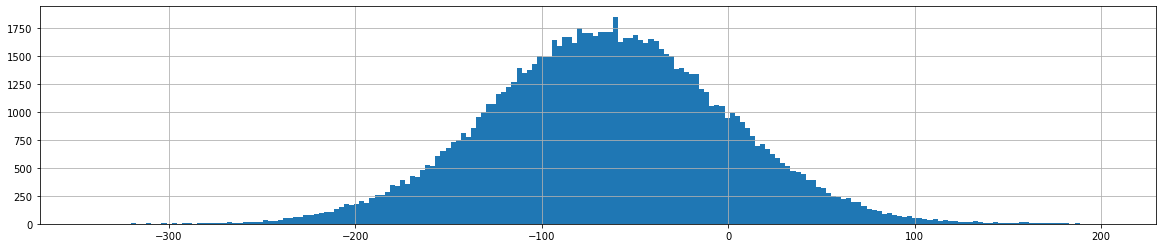

---------- 27 ----------


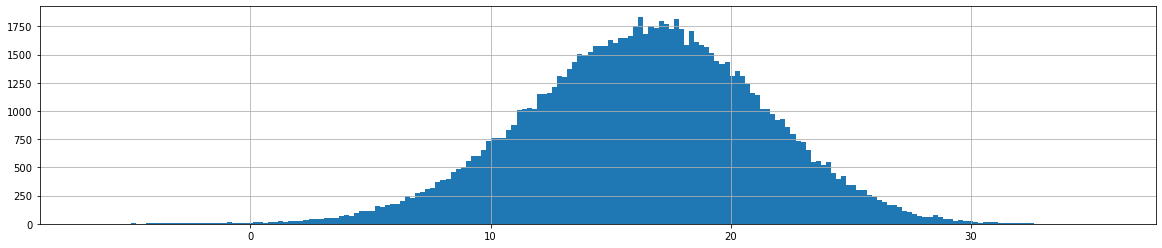

---------- 28 ----------


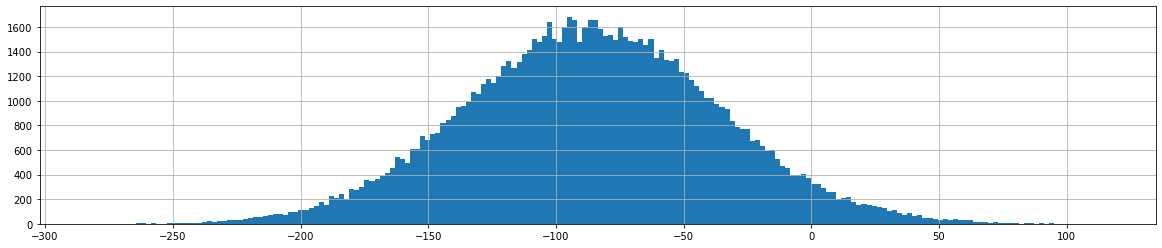

---------- 29 ----------


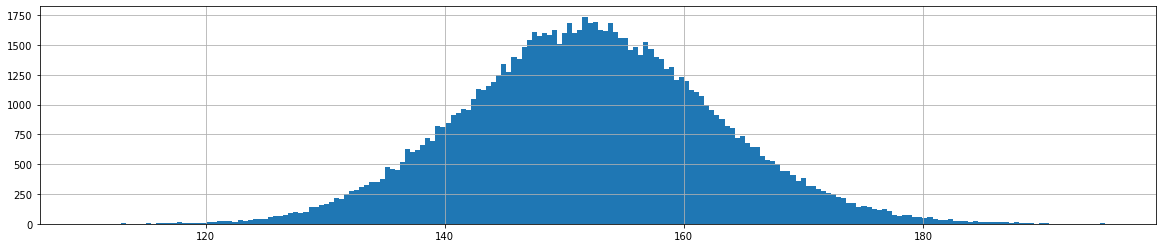

---------- 30 ----------


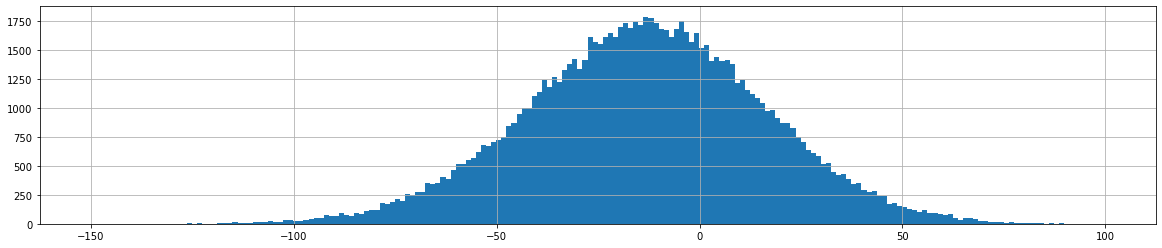

---------- 31 ----------


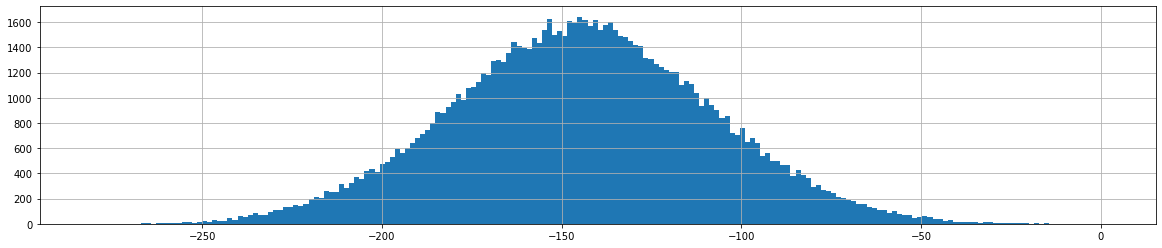

---------- 32 ----------


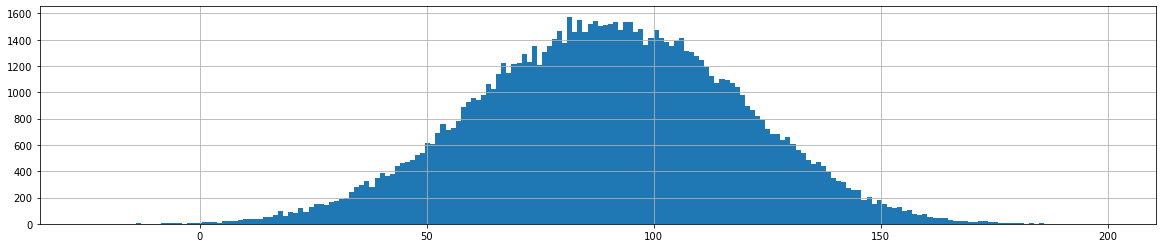

---------- 33 ----------


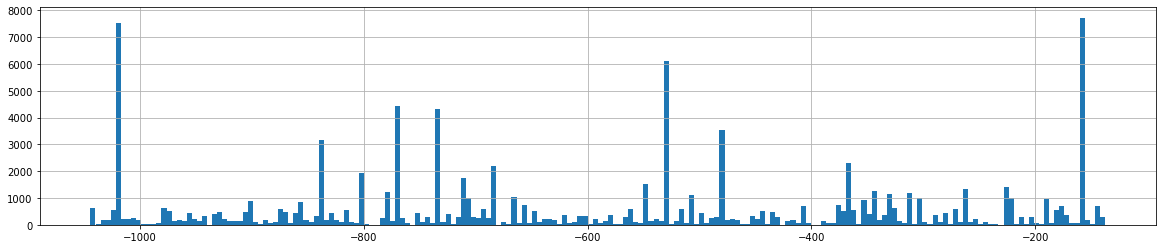

---------- 34 ----------


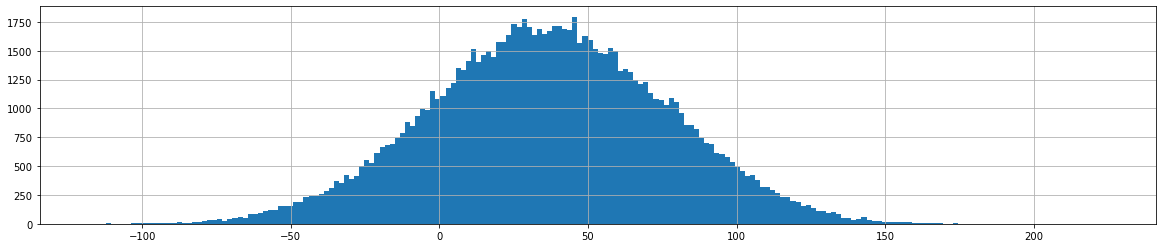

---------- 35 ----------


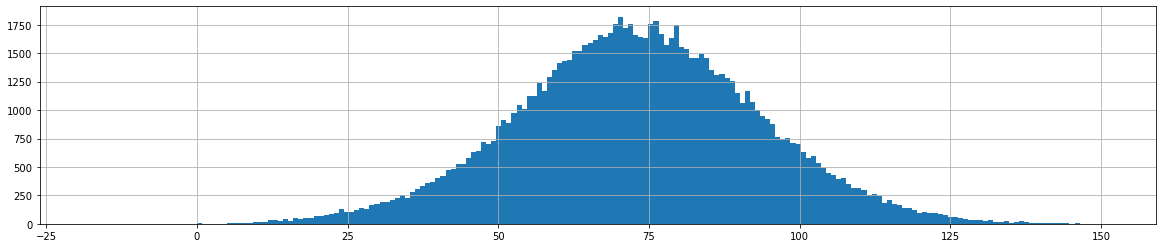

---------- 36 ----------


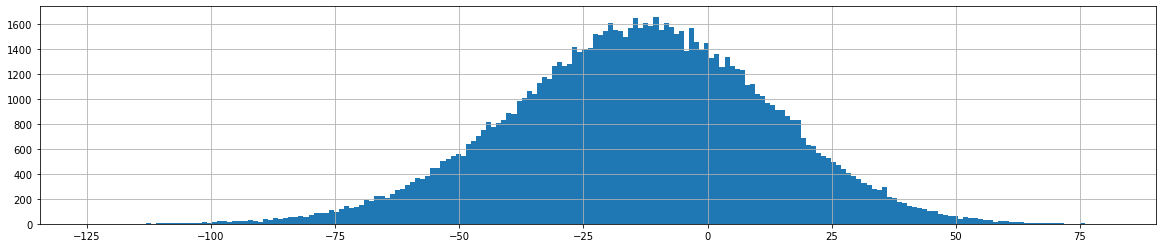

---------- 37 ----------


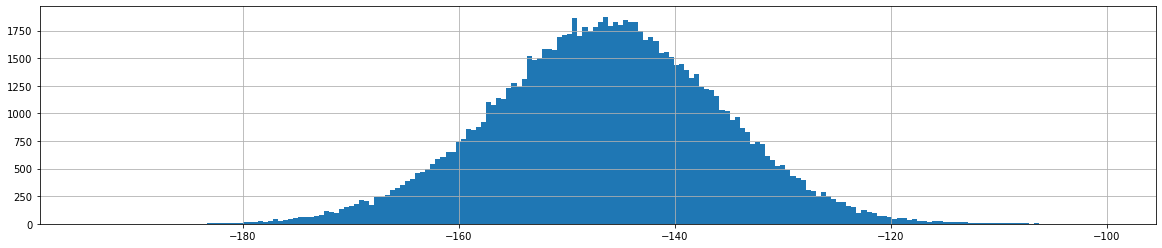

---------- 38 ----------


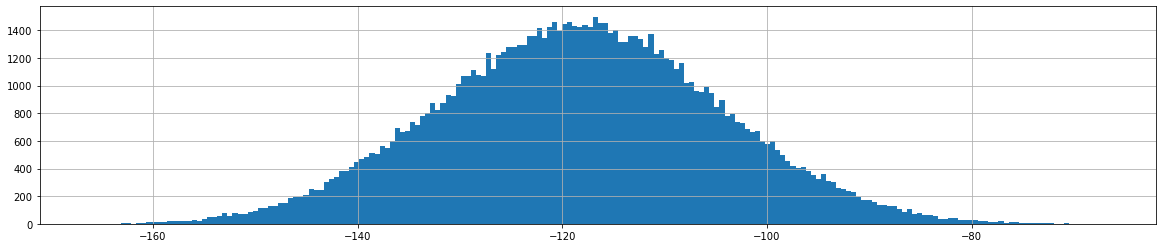

---------- 39 ----------


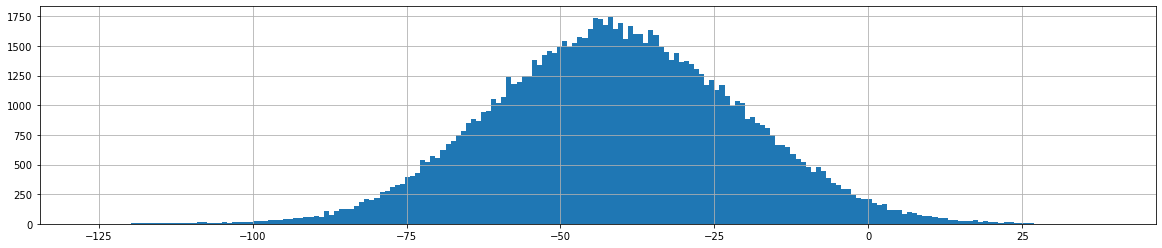

---------- 40 ----------


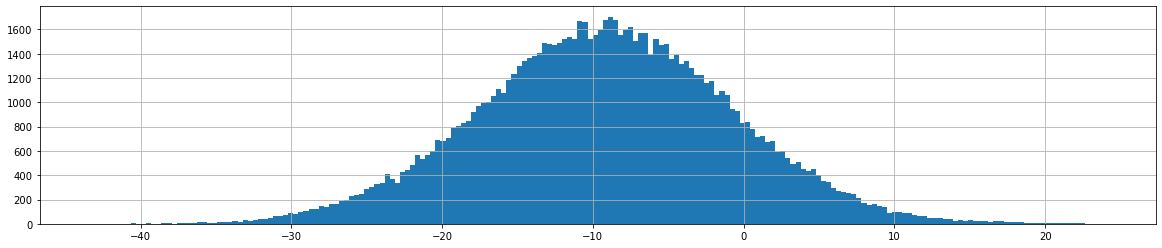

---------- 41 ----------


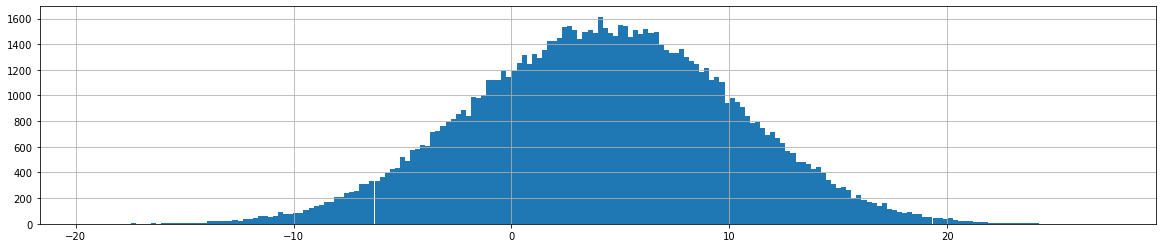

---------- 42 ----------


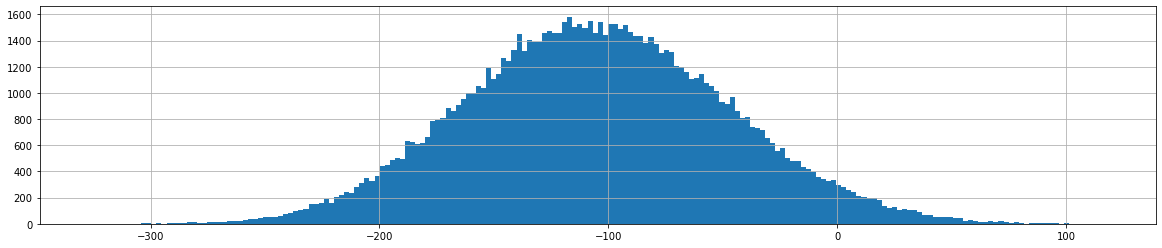

---------- 43 ----------


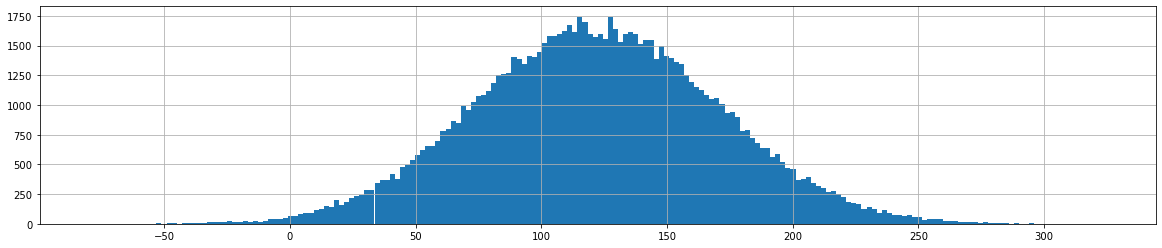

---------- 44 ----------


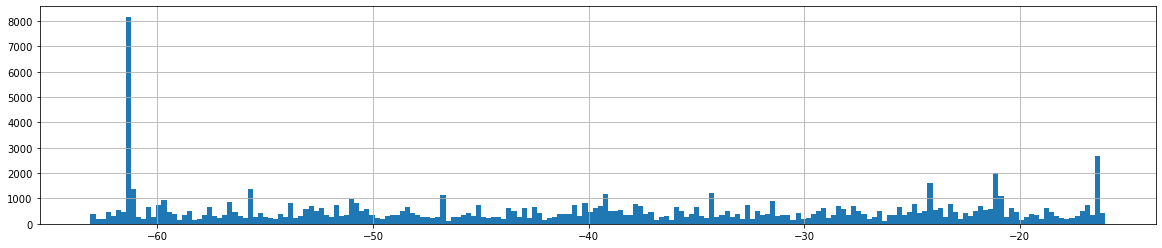

---------- 45 ----------


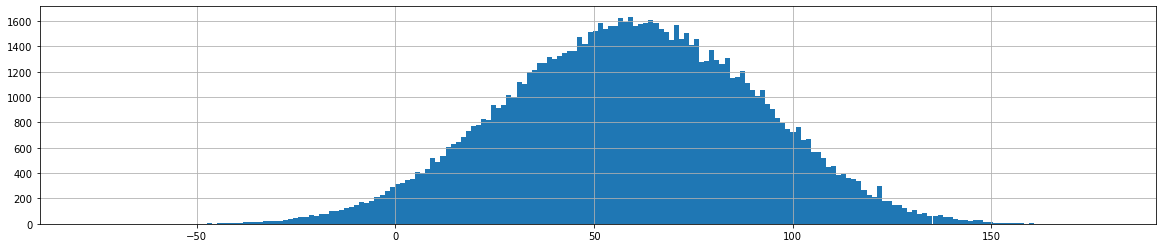

---------- 46 ----------


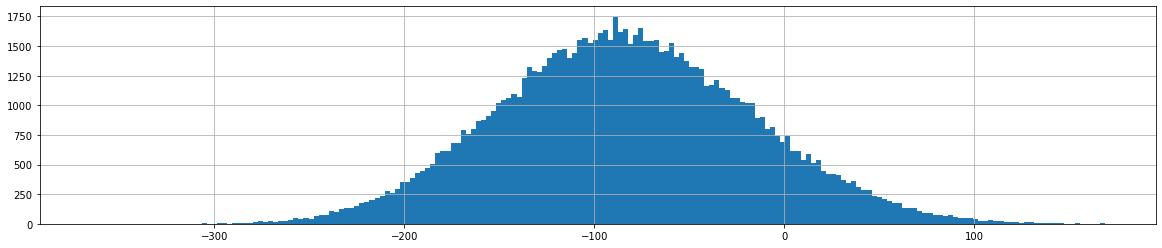

---------- 47 ----------


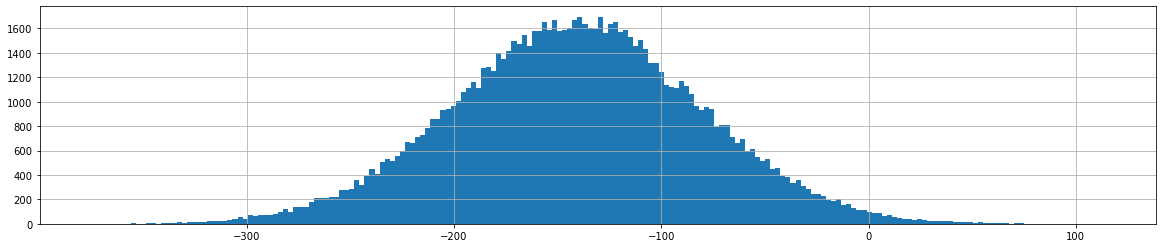

---------- 48 ----------


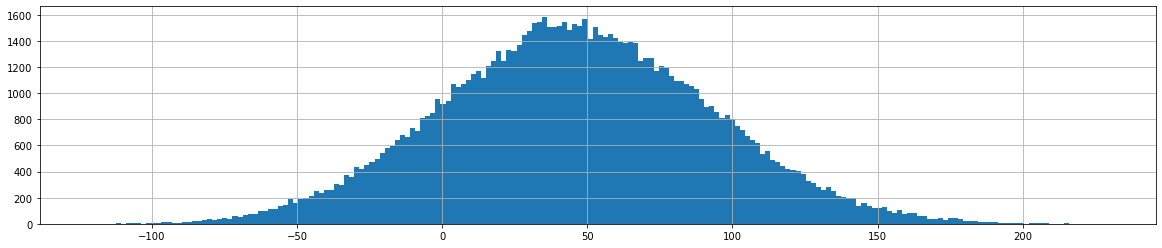

---------- 49 ----------


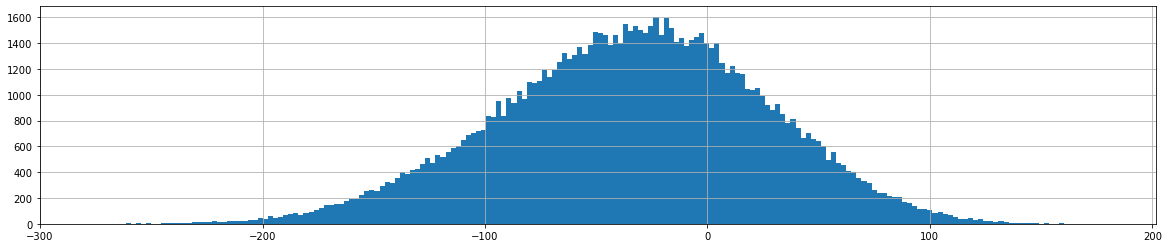

---------- 50 ----------


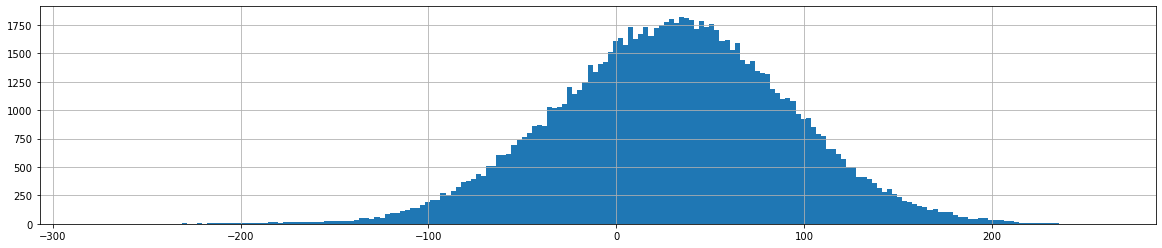

---------- 51 ----------


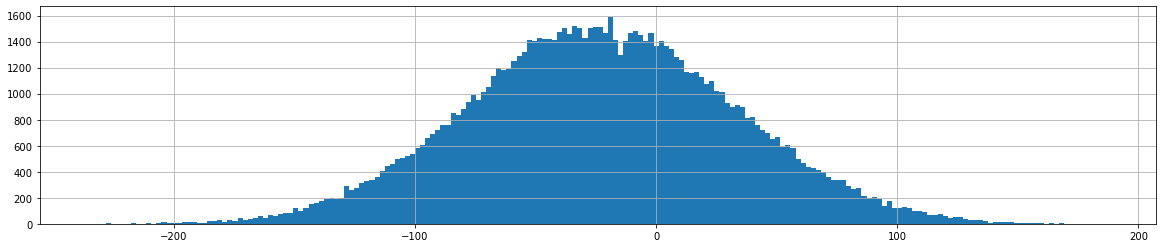

---------- 52 ----------


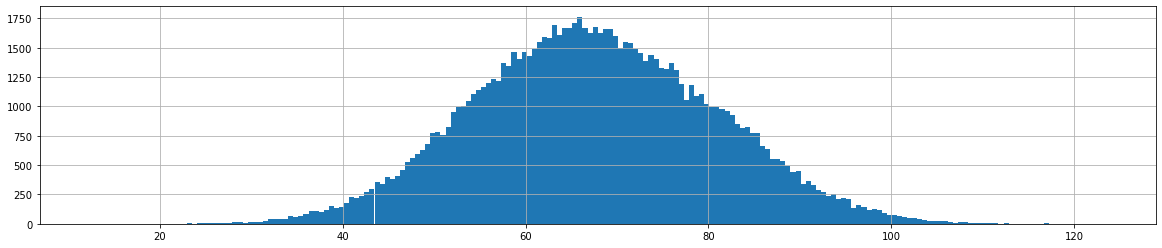

---------- 53 ----------


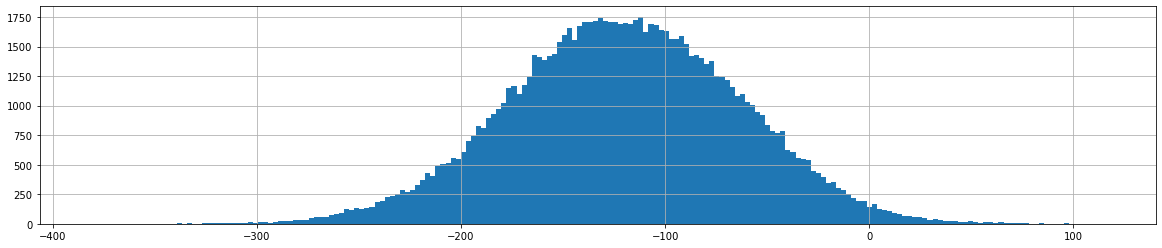

---------- 54 ----------


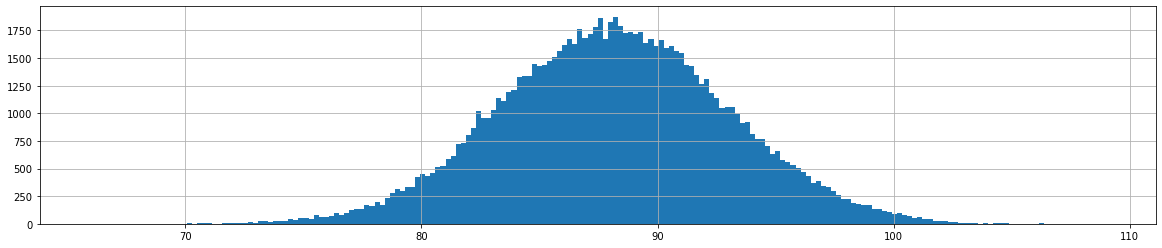

---------- 55 ----------


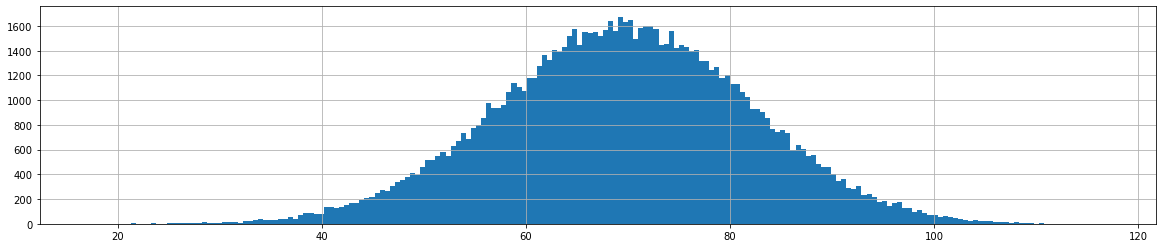

---------- 56 ----------


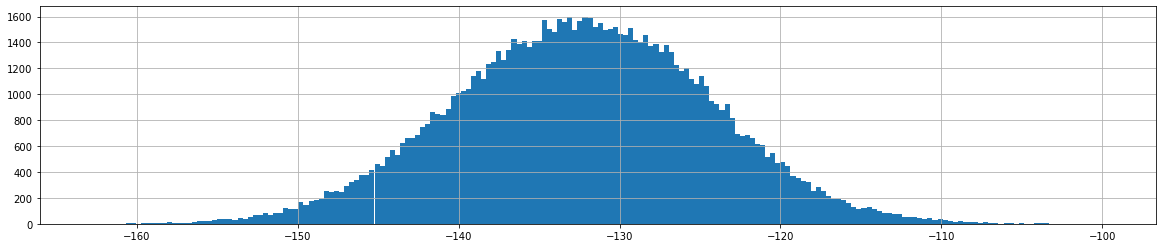

---------- 57 ----------


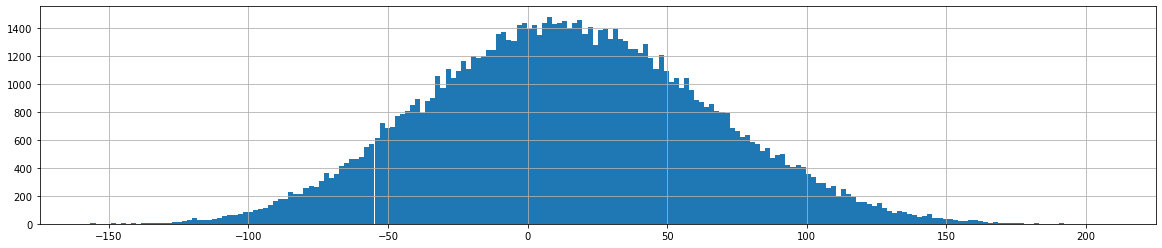

---------- 58 ----------


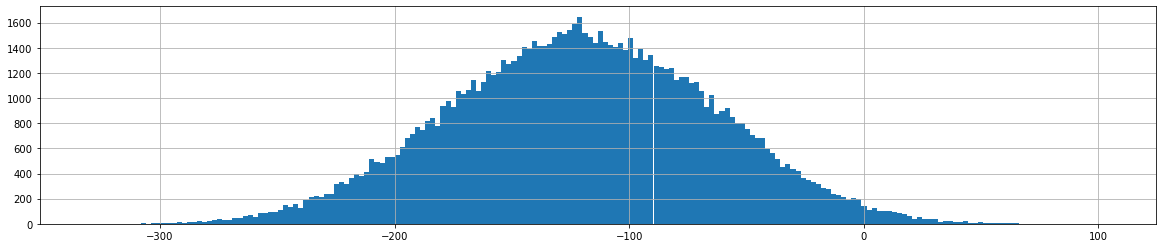

---------- 59 ----------


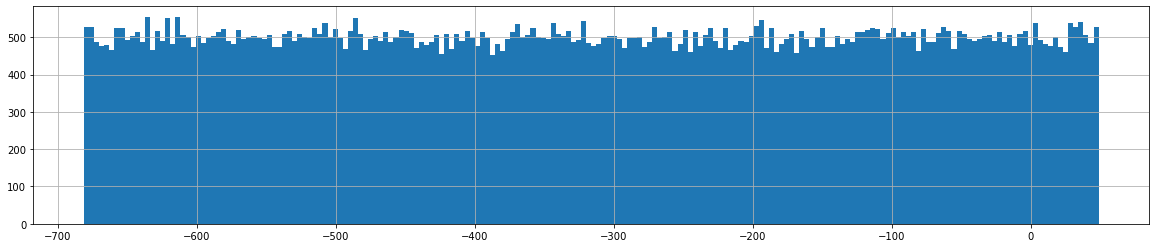

---------- 60 ----------


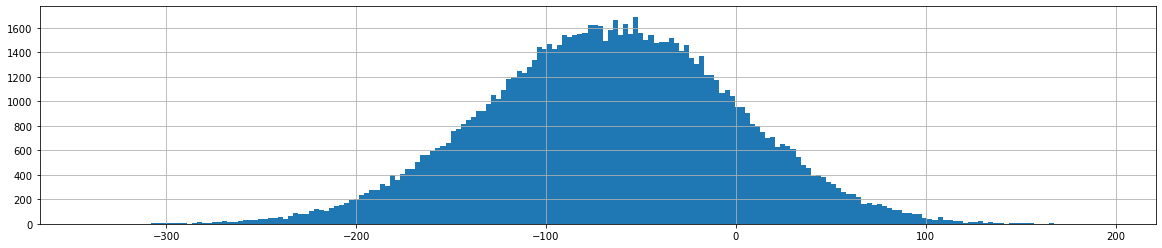

---------- 61 ----------


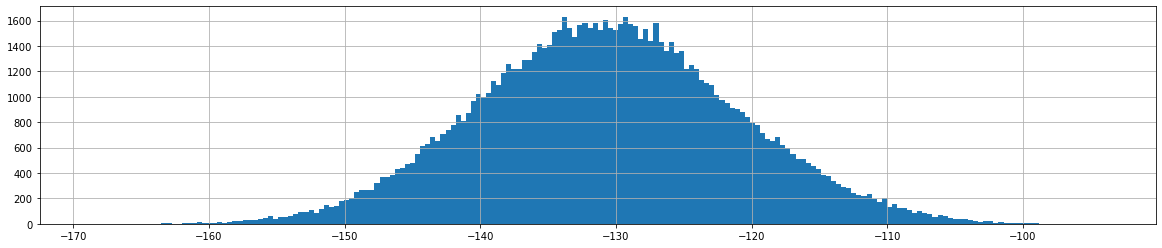

---------- 62 ----------


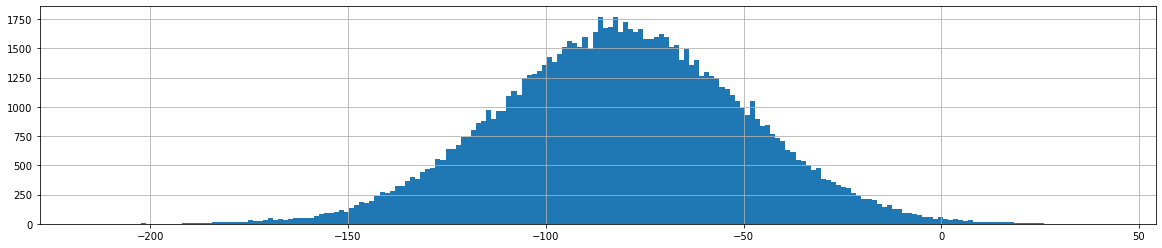

---------- 63 ----------


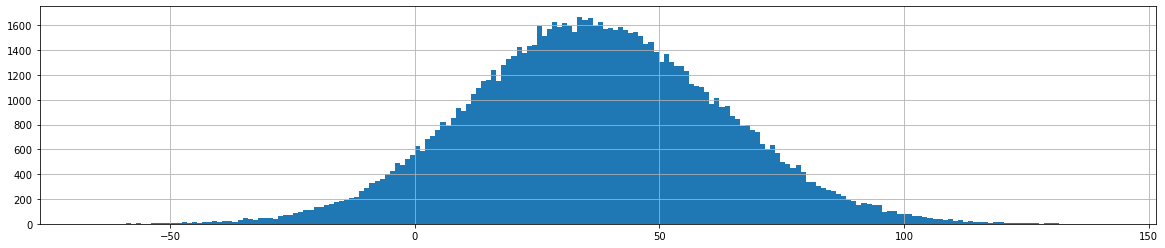

---------- 64 ----------


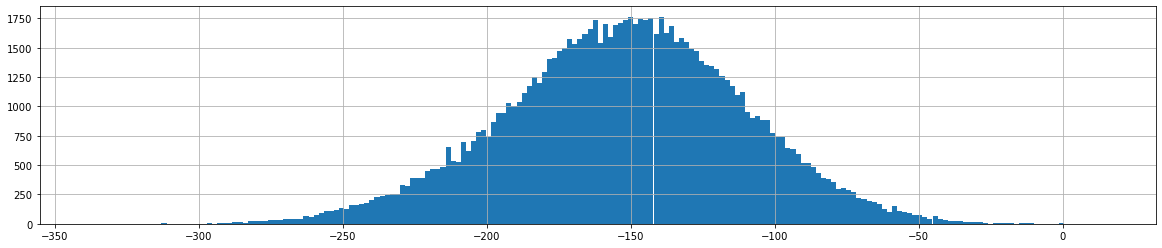

---------- 65 ----------


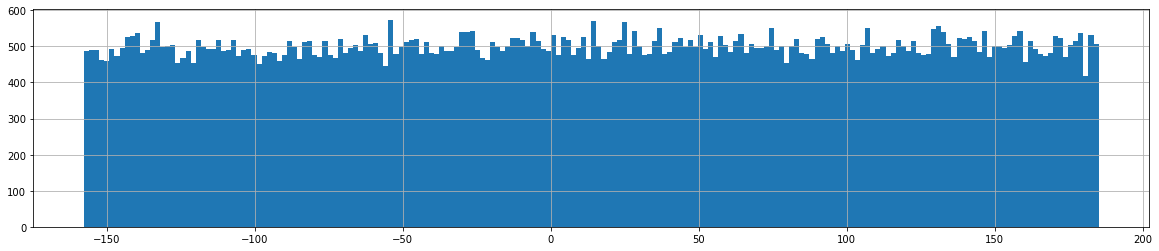

---------- 66 ----------


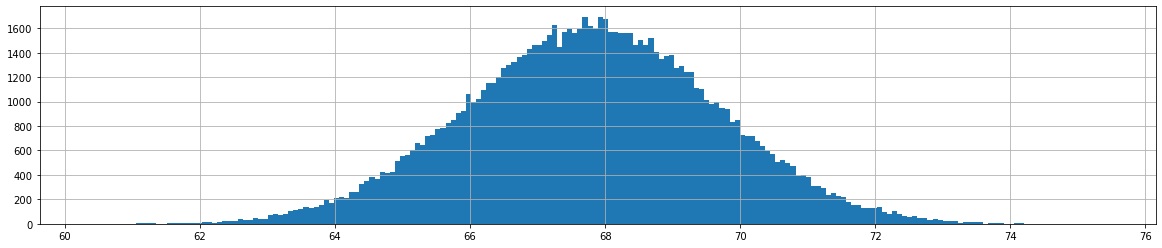

---------- 67 ----------


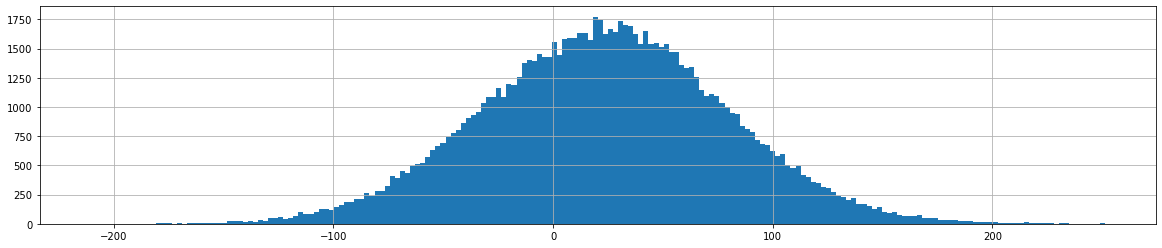

---------- 68 ----------


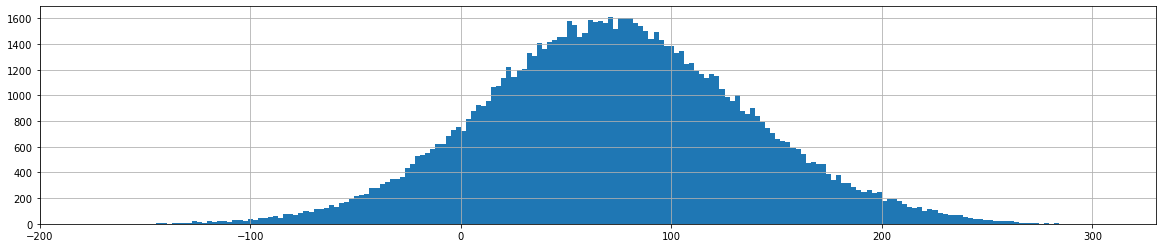

---------- 69 ----------


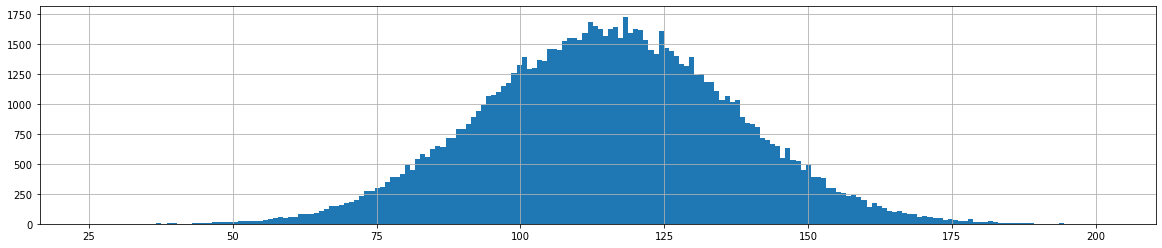

---------- 70 ----------


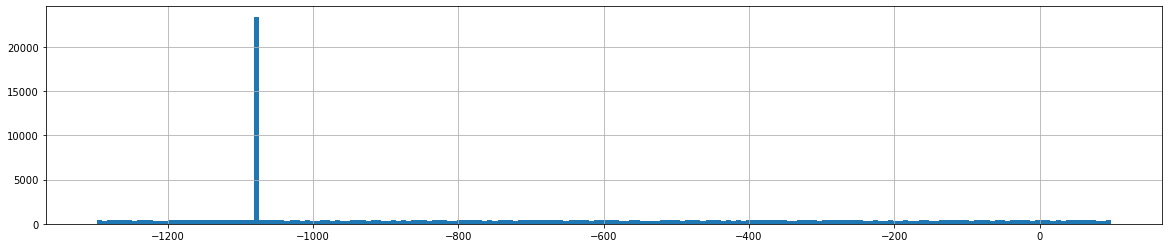

---------- 71 ----------


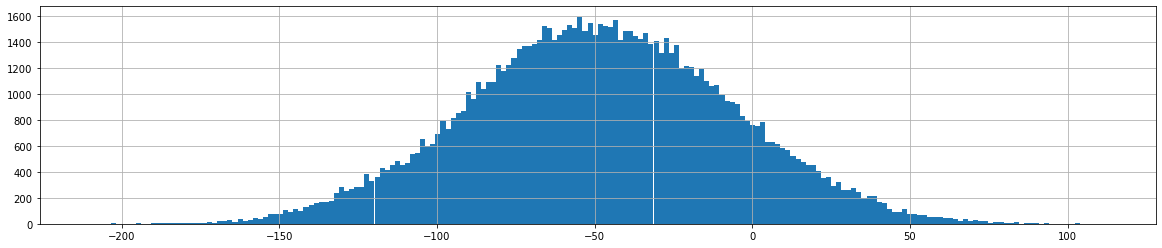

In [78]:
for i in valid. columns:
    print('----------', i, '----------')
    valid[i].hist(bins=200);
    plt.show()

Если сравнивать то valid больше похож на train. Впрочем это не важно. По заветам ML на base и train определим признаки, которые нужно будет поправить и сделаем это со всеми датасетами синхронно.

# Анализ данных

In [79]:
base. shape[0]-len(set(base. index))

0

Дубликатов в индексах(идентификаторах товаров) в базе нету.

In [80]:
train. shape[0]-len(set(train['Target']))

8206

А вот в train в таргете 8206 дубликатов. Рассмотрим один из них подробнее.

In [81]:
unique_elements_train, counts_train = np.unique(train['Target']. values, return_counts=True)
duplicates_train = unique_elements_train[counts_train > 1]
duplicates_train

array(['1000279-base', '100047-base', '1000665-base', ..., '999710-base',
       '999820-base', '999827-base'], dtype=object)

In [82]:
len(duplicates_train)

7060

Всего товаров, которые имеют дубликаты по идентификатору - 7060. Значит некоторые товары с дубликатами имеют не один дубликат а больше.

In [83]:
random_choice = np. random.choice(duplicates_train)
print(random_choice)
aaa = train[train['Target']==random_choice].drop('Target', axis=1).T
aaa. columns = list(range(len(aaa. columns)))
aaa

1684956-base


,0,1,2
0,-59.190620,-57.906334,-52.686230
1,7.729999,5.504515,5.748709
2,-23.803453,-11.308315,-40.810944
3,-161.042200,-156.312010,-156.021130
4,93.986720,82.239784,129.517000
...,...,...,...
67,-10.340969,-37.651543,-45.370690
68,88.867294,118.978546,100.455470
69,149.724080,145.141600,132.008820
70,-639.486912,-1074.464888,-1074.464888


У 7473-base аж 5 дубликатов + 1 "как бы" оригинал о_О. Вот его и возьмем.

In [84]:
aaa = train[train['Target']=='7473-base'].drop('Target', axis=1).T
aaa. columns = list(range(len(aaa. columns)))
for i in range(1,len(aaa.columns)):
    percent_list = []
    name = str(i)+'_'
    aaa[name] = aaa[i]*100/aaa[0]
aaa

,0,1,2,3,4,5,1_,2_,3_,4_,5_
0,-151.272610,-151.272610,-121.133560,-121.133560,-121.133380,-121.134950,100.0,80.076334,80.076334,80.076215,80.077253
1,9.049097,9.049097,7.574165,7.574165,7.574158,7.573353,100.0,83.700783,83.700783,83.700705,83.691813
2,-62.470460,-62.470460,-35.134230,-35.134230,-35.134400,-35.125430,100.0,56.241350,56.241350,56.241622,56.227263
3,-138.899060,-138.899060,-144.763430,-144.763430,-144.763470,-144.765500,100.0,104.222037,104.222037,104.222066,104.223528
4,100.782030,100.782030,122.281650,122.281650,122.281450,122.284550,100.0,121.332791,121.332791,121.332593,121.335669
...,...,...,...,...,...,...,...,...,...,...,...
67,-39.880980,-39.880980,14.535877,14.535877,14.535701,14.516295,100.0,-36.448144,-36.448144,-36.447703,-36.399043
68,80.712680,80.712680,74.333270,74.333270,74.332855,74.317314,100.0,92.096149,92.096149,92.095635,92.076380
69,116.109490,116.109490,112.026750,112.026750,112.026830,112.033780,100.0,96.483715,96.483715,96.483784,96.489770
70,-1127.895452,-1127.895452,-1127.895452,-1127.895452,-1127.895452,-1127.895452,100.0,100.000000,100.000000,100.000000,100.000000


In [85]:
aaa. describe()

,0,1,2,3,4,5,1_,2_,3_,4_,5_
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,-35.344474,-30.252514,-34.460432,-34.694173,-29.282676,-29.344705,100.241307,146.676592,146.910306,145.027104,146.383519
std,297.836259,284.058865,290.855794,290.805498,285.390967,282.581193,12.169196,536.761139,536.784126,536.904622,536.802563
min,-1127.895452,-1127.895452,-1127.895452,-1127.895452,-1127.895452,-1127.895452,36.688411,-1015.366646,-1015.366646,-1015.366646,-1015.366646
25%,-105.801164,-105.801164,-102.304198,-102.304198,-102.304085,-102.301758,100.000000,74.981323,74.918955,74.185024,74.916755
50%,-30.285145,-30.285145,-33.887530,-33.887530,-33.887883,-33.879738,100.000000,98.885861,98.885861,98.561175,98.885167
75%,29.057004,29.057004,38.457065,38.457065,38.457215,38.455986,100.000000,111.136961,111.136961,110.408318,111.253577
max,1507.231274,1507.231274,1502.158876,1502.158876,1502.158876,1502.158876,180.685672,4461.890907,4461.890907,4461.905521,4461.086996


In [86]:
aaa = train[train['Target']=='13083-base'].drop('Target', axis=1).T
aaa. columns = list(range(len(aaa. columns)))
for i in range(1,len(aaa.columns)):
    percent_list = []
    name = str(i)+'_'
    aaa[name] = aaa[i]*100/aaa[0]
aaa

,0,1,2,1_,2_
0,-79.400640,-91.543884,-93.999170,115.293635,118.385910
1,8.982395,12.500349,11.020691,139.164989,122.692122
2,21.720528,-2.445042,-21.718124,-11.256824,-99.988932
3,-157.255330,-132.393550,-132.869550,84.190183,84.492875
4,153.200990,181.622510,163.300340,118.551786,106.592222
...,...,...,...,...,...
67,56.086937,33.574306,55.984257,59.861187,99.816927
68,102.119100,99.287490,126.966450,97.227149,124.331736
69,124.908150,73.044120,79.283480,58.478266,63.473424
70,-176.873870,-176.873870,-176.873870,100.000000,100.000000


In [87]:
aaa.describe()

,0,1,2,1_,2_
count,72.000000,72.000000,72.000000,72.000000,72.000000
mean,-10.340979,-13.915146,-13.906513,12.181976,84.949949
std,188.432184,267.044144,266.499697,978.358032,581.635491
min,-530.124724,-759.626065,-941.819805,-8090.284385,-4522.681679
25%,-129.429570,-115.852305,-116.095763,82.536942,83.339420
50%,-10.704327,-2.329841,-22.052027,100.000000,100.000000
75%,51.135762,56.609324,66.832865,126.136687,138.272227
max,892.710774,1507.231274,1502.158876,721.246523,1134.293689


Видно что дубликаты очень сильно отличаются от "оригинала". И их довольно много. Проверю ка я тогда как таргеты из train соотносятся к таргетам в base

Проверим первые n+delta таргетов из train и напрямую найдем растояние для всех данных base. Найдем количество таргетов в таблице base для каждого из этих n которые имеют более близкие координаты чем исходный таргет из train. На выходе из функции получу количество объектов из base, которые ближе к выбранному объекту из train, чем он сам из base.

In [88]:
def check_data(delta,n):
    base_matrix = base. values
    distance_list = []
    for x in range(n):
        one_array = train. drop('Target', axis=1). iloc[x+delta]. values
        targ_value = train['Target']. iloc[x+delta]
        rast = np.sum((base_matrix-one_array)**2, axis=1)**0.5
        distance_list. append(len(rast[rast<sum((base. loc[targ_value]. values-one_array)**2)**0.5]))
    return distance_list 

In [89]:
def print_result(k, n, delta):
    r_list = check_data(delta,n)
    print(f'Среди {n} исследованных векторов из train у {np.searchsorted(np.sort(r_list), k)} штук не '+
          f'более {k-1}-ти векторов в base, которые ближе искомого.')
    print('--------------------------------------------------------------------------------------------------------------')
    print(pd.Series(r_list). describe(). astype(int))

In [90]:
%%time
print_result(6, 10, 0)

Среди 10 исследованных векторов из train у 0 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count         10
mean      793037
std       828361
min         8458
25%       142959
50%       397014
75%      1401816
max      2124638
dtype: int32
CPU times: total: 9.53 s
Wall time: 9.53 s


In [193]:
# %%time
# print_result(6, 50, 20)

Среди 50 исследованных векторов из train у 8 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count         50
mean      550393
std       728093
min            0
25%         9802
50%       295715
75%       685756
max      2676219
dtype: int32
CPU times: total: 46.7 s
Wall time: 46.8 s


In [194]:
# %%time
# print_result(6, 50, 50000)

Среди 50 исследованных векторов из train у 2 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count         50
mean      719698
std       775591
min            0
25%        71380
50%       414292
75%      1231832
max      2586062
dtype: int32
CPU times: total: 46.1 s
Wall time: 46.3 s


In [195]:
# %%time
# print_result(6, 50, 90000)

Среди 50 исследованных векторов из train у 10 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count         50
mean      695608
std       853186
min            0
25%         1150
50%       363561
75%      1117072
max      2848663
dtype: int32
CPU times: total: 45.8 s
Wall time: 46 s


In [196]:
# %%time
# print_result(6, 500, 0)

Среди 500 исследованных векторов из train у 82 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count        500
mean      572701
std       754245
min            0
25%         3942
50%       191228
75%       942478
max      2915873
dtype: int32
CPU times: total: 7min 28s
Wall time: 7min 29s


In [197]:
# %%time
# print_result(6, 500, 40000)

Среди 500 исследованных векторов из train у 50 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count        500
mean      636003
std       790175
min            0
25%         6519
50%       228075
75%      1073939
max      2909522
dtype: int32
CPU times: total: 7min 27s
Wall time: 7min 28s


In [198]:
# %%time
# print_result(6, 500, 91000)

Среди 500 исследованных векторов из train у 71 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count        500
mean      636432
std       792142
min            0
25%         2293
50%       243520
75%      1038089
max      2892138
dtype: int32
CPU times: total: 7min 26s
Wall time: 7min 27s


In [199]:
# %%time
# print_result(6, 1000, 1000)

Среди 1000 исследованных векторов из train у 130 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count       1000
mean      603584
std       759141
min            0
25%         7208
50%       214879
75%       995077
max      2915830
dtype: int32
CPU times: total: 14min 49s
Wall time: 14min 51s


Есть таргеты в train, для которых в базе почти 3 000 000 объектов ближе чем они сами... Для половины из исследованых примерно по 140 000-420 000 объектов из base ближе чем они сами. Для 25% из исследованных есть 1000-71000 объектов из base которые ближе чем они сами. Если вспомнить что в train всего лишь примерно 7% дубликатов, похожесть которых весьма условная, то становится ясно, что проблема не из-за них. Надеюсь что после нормализации и удаления плохих признаков ситуация улучшится, хотя сомневаюсь.  
Если учесть, что среди 2660 (2,66% от train) исследованных векторов нашлось 353 (13,27% от 2660) вектора, которые попадают в пятерку ближайших к самим себе из train, то надеяться на метрику выше 20% до обработки данных впринципе не стоит.
У меня огромные вопросы к качеству датасета. Но будем работать с тем, что есть. Может ещё поможет уменьшение размерности и квантование.

**P.S. Для экономии памяти не буду объявлять новые переменные без необходимости. У меня всего 15 ГБ. Поэтому проект нужно выполнять строго в определенной последовательности ячеек.**

# Дефолтный Faiss

Как бы то ни было попробуем поискать ближайшие на train и base и получить метрику.

## Создаем индекс и обучаемся

In [91]:
dims = base.shape[1]
n_cells = 1700 # Задаем количество кластеров для ускорения работы
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [92]:
print("Размерность векторов:", quantizer.d)
print("Количество векторов в индексе:", quantizer.ntotal)

Размерность векторов: 72
Количество векторов в индексе: 0


In [93]:
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
targets = train["Target"]
to_search = train.drop("Target", axis=1)

## Поиск по дефолту

In [95]:
%%time
idx_l2.nprobe = 65  # Задаем количество ближайших кластеров, по которым проводить поиск для повышения качества.
r, idx = idx_l2.search(np.ascontiguousarray(to_search.values).astype('float32'), 5)

CPU times: total: 18min 44s
Wall time: 57.8 s


In [96]:
acc = 0
for target_s, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target_s in [base_index[q] for q in el])

print(100 * acc / len(idx))

13.544


Опишу некоторые результаты.

|n_cells|nprobe|accuracy@5|time, min|
|-------|------|----------|---------|
|1|1|13.7|28|
|1700|1|3.7|0.05|
|1700|65|13.5|1|

Играясь с этими параметрами достичть метрикой 13,8 не удалось ни разу. Максимум крутился в районе 13,7-13,79. При этом время поиска для лучшей метрики удавалось скинуть до 5-7 минут при довольно большом nprobe. В конечном итоге подобрал такие значения что бы метрика была не ниже 13,5 и время около минуты. На таких параметрах и буду идти дальше. Далее буду работать с датасетами уже.

Собственно метрика почти идеально совпадает с тем, что получилось при прямом поиске при анализе на случайно выбранных векторах, что ещё раз подтверждает низкое качество данных.

Для наглядности и собственного любопытства выведу то, что хранят r и idx

In [98]:
r

array([[108182.35 , 116295.55 , 125482.26 , 141574.39 , 142215.5  ],
       [102827.21 , 116681.83 , 120689.08 , 122624.29 , 122806.875],
       [ 54918.504,  57053.156,  57339.785,  61338.43 ,  61677.61 ],
       ...,
       [121162.92 , 124178.09 , 137519.9  , 141108.45 , 141959.9  ],
       [ 12899.896,  14389.789,  15360.637,  16159.128,  16368.567],
       [ 86950.68 ,  93586.62 , 117959.75 , 121902.69 , 124959.664]],
      dtype=float32)

In [99]:
idx

array([[1480698,  161948, 1076334, 1882633, 1282393],
       [ 445586,  920175, 2168908, 2651198,  546230],
       [1659033,  760940,  656828, 1052397, 1392119],
       ...,
       [2690258,  700937, 1242425, 2703195,  813545],
       [1197717, 2500439, 2265191, 2358202,  955468],
       [1958647,  272735,  458565,  231187, 1863959]], dtype=int64)

# Коррекция данных

## Удаление признаков

В разделе EDA видно, что признаки под номерами 6, 21, 25, 33, 44, 59, 65 и 70 резко выделяются своим распределением от остальных. Удалим эти признаки и проверим как это повлияет на метрику.

### Base

In [11]:
base. shape

(2918139, 72)

In [12]:
base. drop(['6', '21', '25', '33', '44', '59', '65', '70'],axis=1,inplace=True)
base. shape

(2918139, 64)

### Train

In [13]:
train. shape

(100000, 73)

In [14]:
train. drop(['6', '21', '25', '33', '44', '59', '65', '70'],axis=1,inplace=True)
train. shape

(100000, 65)

## Поиск

In [105]:
dims = base.shape[1]
n_cells = 1700 # Задаем количество кластеров для ускорения работы
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [106]:
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
targets = train["Target"]
to_search = train.drop("Target", axis=1)

In [108]:
%%time
idx_l2.nprobe = 65  # Задаем количество ближайших кластеров, по которым проводить поиск для повышения качества.
r, idx = idx_l2.search(np.ascontiguousarray(to_search.values).astype('float32'), 5)

CPU times: total: 16min 35s
Wall time: 50.5 s


In [109]:
acc = 0
for target_s, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target_s in [base_index[q] for q in el])

print(100 * acc / len(idx))

69.309


Сразу так внезапно... Интереса ради проверим 10 векторов из тех, что ранее проверяли прямым поиском. И возьмем те вектора, которые показали худший результат.

In [110]:
%%time
print_result(6, 10, 0)

Среди 10 исследованных векторов из train у 7 штук не более 5-ти векторов в base, которые ближе искомого.
--------------------------------------------------------------------------------------------------------------
count         10
mean      124572
std       366165
min            0
25%            0
50%            0
75%        21484
max      1165503
dtype: int32
CPU times: total: 8.45 s
Wall time: 8.49 s


В прошлый раз:  
- min=8458
- max=2124638
- median=397014
- Подходящих векторов найдено 0 штук

Разница очевидна. Выполним эти преобразования на valid. Затем попробуем стандартизирование признаков, хотя для L2 это, по моему, не должно влиять на результат.

### Valid

In [15]:
valid. shape

(100000, 72)

In [16]:
valid. drop(['6', '21', '25', '33', '44', '59', '65', '70'],axis=1,inplace=True)
valid. shape

(100000, 64)

## Стандартизация

In [17]:
base_scaler = StandardScaler()
base_index = base.index
base = pd.DataFrame(base_scaler.fit_transform(base))
base.index = base_index
train_index = train.index
time_target = train['Target']
train = pd.DataFrame(base_scaler.transform(train. drop('Target', axis=1)))
train.index =  train_index
train['Target'] = time_target
#train_stand.index = train.index
#train_stand['Target'] = train['Target']

## Поиск

In [18]:
dims = base.shape[1]
n_cells = 1700 # Задаем количество кластеров для ускорения работы
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [19]:
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
targets = train["Target"]
to_search = train.drop("Target", axis=1)

In [20]:
%%time
idx_l2.nprobe = 65  # Задаем количество ближайших кластеров, по которым проводить поиск для повышения качества.
r, idx = idx_l2.search(np.ascontiguousarray(to_search.values).astype('float32'), 5)

CPU times: total: 18min 5s
Wall time: 56.7 s


In [21]:
acc = 0
for target_s, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target_s in [base_index[q] for q in el])

print(100 * acc / len(idx))

70.614


Ну 1.3% тоже не плохо. Применим для valid. Затем попробуем выполнить квантование.

Пробовал выполнить стандартизацию без удаления признаков метрика выросла до 65.28. У меня смутное ощущениие, что так правильнее, поскольку у нас закодированные данные и мы понятия не имеем важны ли те признаки, которые мы удалили или нет. У меня ощущение, что в такой ситуации любое удаление данных это повышение риска не релевантности метрик. Но переделывать уже некогда, поэтому оставлю так как есть.

In [18]:
valid_index = valid.index
valid = pd.DataFrame(base_scaler.transform(valid))
#valid_stand.index = valid.index
valid.index =  valid_index

## Квантование

In [23]:
dims = base.shape[1]
n_cells = 1700 # Задаем количество кластеров для ускорения работы
m = 8  # Количество групп (подвекторов)
n_bits = 8  # Количество бит в каждом коде (словаре)
quantizer = faiss.IndexFlatL2(dims)
#idx_l2_pq = faiss.IndexIVFFlat(quantizer_pq, dims_pq, n_cells_pq)
idx_l2 = faiss.IndexIVFPQ(quantizer, dims, n_cells, m, n_bits)

In [24]:
# Строим индекс для заквантованных данных
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
targets_pq = train["Target"]
to_search_pq = train.drop("Target", axis=1)

In [25]:
%%time
# Выполняем поиск в индексе
idx_l2.nprobe = 65  # Задаем количество ближайших кластеров, по которым проводить поиск для повышения качества.
r, idx = idx_l2.search(np.ascontiguousarray(to_search.values).astype('float32'), 5)

CPU times: total: 1min 33s
Wall time: 4.78 s


In [26]:
acc = 0
for target_s, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target_s in [base_index[q] for q in el])

print(100 * acc / len(idx))

67.469


Метрика упала на 3% зато время ускорилось примерно в 9 раз. Это тоже хороший результат.

# Пробуем ML

Сначала выполним поиск на 100 ближайших. 100 потому что больше моя оперативка не вывозит.

При поиске 3000 ближайших метрика 84 с копейками и 5 минут вычисления метрики... Еще больше ошибка памяти. при 1000 метрика 84. Оставил 300 что бы в память хотя бы влезла обучающая выборка.

In [19]:
dims = base.shape[1]
n_cells = 1700 # Задаем количество кластеров для ускорения работы
m = 8  # Количество групп (подвекторов)
n_bits = 8  # Количество бит в каждом коде (словаре)
N_faiss = 100
quantizer = faiss.IndexFlatL2(dims)
#idx_l2_pq = faiss.IndexIVFFlat(quantizer_pq, dims_pq, n_cells_pq)
idx_l2 = faiss.IndexIVFPQ(quantizer, dims, n_cells, m, n_bits)

In [20]:
# Строим индекс для заквантованных данных
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
targets = train["Target"]
to_search = train.drop("Target", axis=1)

In [21]:
%%time
# Выполняем поиск в индексе
idx_l2.nprobe = 65  # Задаем количество ближайших кластеров, по которым проводить поиск для повышения качества.
r, idx = idx_l2.search(np.ascontiguousarray(to_search.values).astype('float32'), N_faiss)

CPU times: total: 1min 27s
Wall time: 11.6 s


In [22]:
acc = 0
for target_s, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target_s in [base_index[q] for q in el])

print(100 * acc / len(idx))

77.878


In [23]:
base = base.values

In [24]:
train_target = train['Target'].values

In [25]:
train = train.drop("Target", axis=1). values

In [26]:
%%time
idx = idx.flatten()

CPU times: total: 31.2 ms
Wall time: 20.8 ms


In [27]:
%%time
train_matrix = base[idx]

CPU times: total: 8.78 s
Wall time: 8.78 s


In [28]:
%%time
train_matrix = np.concatenate((train_matrix, np.repeat(train, N_faiss, axis=0)), axis=1)

CPU times: total: 27.5 s
Wall time: 52.4 s


In [29]:
train_matrix.shape

(10000000, 128)

In [30]:
(train_matrix.nbytes/1024)/1024

9765.625

In [31]:
%%time
bool_mass = np.array([base_index[i] for i in idx])==np.repeat(train_target, N_faiss, axis=0)
bool_mass = bool_mass[:,np.newaxis]
bool_mass

CPU times: total: 10.9 s
Wall time: 11.3 s


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [32]:
bool_mass. shape

(10000000, 1)

In [40]:
np.sum(bool_mass)

77878

In [33]:
%%time
train_matrix = np.concatenate((train_matrix, bool_mass), axis=1)

CPU times: total: 27.3 s
Wall time: 48.7 s


In [34]:
train_matrix.shape

(10000000, 129)

In [35]:
(train_matrix.nbytes/1024)/1024

9841.9189453125

In [36]:
K=1000000
model = CatBoostClassifier()
model.fit(train_matrix[:K,:-1],train_matrix[:K,-1], verbose=100)

Learning rate set to 0.196759
0:	learn: 0.3334364	total: 313ms	remaining: 5m 12s
100:	learn: 0.0235468	total: 16.2s	remaining: 2m 24s
200:	learn: 0.0202350	total: 30.4s	remaining: 2m
300:	learn: 0.0186043	total: 43.9s	remaining: 1m 41s
400:	learn: 0.0175570	total: 56.8s	remaining: 1m 24s
500:	learn: 0.0166475	total: 1m 9s	remaining: 1m 9s
600:	learn: 0.0158100	total: 1m 21s	remaining: 54.4s
700:	learn: 0.0149873	total: 1m 35s	remaining: 40.5s
800:	learn: 0.0143639	total: 1m 47s	remaining: 26.8s
900:	learn: 0.0137266	total: 2m	remaining: 13.3s
999:	learn: 0.0131731	total: 2m 13s	remaining: 0us


In [37]:
%%time
predboost = model.predict_proba(train_matrix[:K,:-1])
predboost

CPU times: total: 27.6 s
Wall time: 25.5 s


array([[9.58122581e-01, 4.18774186e-02],
       [9.45726414e-01, 5.42735860e-02],
       [9.86178393e-01, 1.38216069e-02],
       ...,
       [9.99936168e-01, 6.38320523e-05],
       [9.99980102e-01, 1.98984148e-05],
       [9.99774653e-01, 2.25346711e-04]])

In [38]:
pd.DataFrame(predboost). describe()

,0,1
count,1000000.000000,1.000000e+06
mean,0.992173,7.827246e-03
std,0.057647,5.764740e-02
min,0.004218,1.853250e-08
25%,0.998087,8.016703e-05
50%,0.999606,3.936481e-04
75%,0.999920,1.912671e-03
max,1.000000,9.957823e-01


Что то я не очень пониаю что мне выдал predict_proba и как мне с этим работать. И по какому числу сортировать нужно. Видел информацию что столбец 0 это вероятность класса 0 а столбец 1 вероятность класса 1. Значит будем брать столбец 1.  
Поиски дали фразы типа:
- Функция predict_proba — на выходе получаем готовые вероятности. Нужно отметить, что складывать их уже нельзя.
- Single object — One-dimensional numpy.ndarray with probabilities for every class.
- Multiple objects — Two-dimensional numpy.ndarray of shape (number_of_objects, number_of_classes) with the probability for every class for each object  
  
Уж где в этой задаче мультиобджектс хз, но такие объяснения ничего не объясняют и только больше путают.

In [51]:
len(predboost[:,1])

1000000

In [53]:
train_matrix = np.concatenate((train_matrix[:K,:], predboost[:,1][:,np.newaxis]), axis=1)

In [64]:
train_matrix. shape

(1000000, 130)

In [74]:
%%time
train_matrix = [train_matrix[i * 100:(i + 1) * 100, :] for i in range(10000)]

CPU times: total: 0 ns
Wall time: 3.01 ms


In [85]:
%%time
for i in range(10000):
    train_matrix[i] = train_matrix[i][np.argsort(train_matrix[i][:, -1])]

CPU times: total: 641 ms
Wall time: 684 ms


Времени уже без 2-х минут дедлайн... А с git даже не начинал работать. В общем мне тут нужно ещё индексы до сортировки засунуть, что бы потом понимать кто стал лидером, посчитать метрику, повторить всё на валидационной. Буду упражняться когда прошлый проект закрою.

# Предсказания на валидационной

In [68]:
dims_pq_val = base_stand.shape[1]
n_cells_pq_val = 1700 # Задаем количество кластеров для ускорения работы
m = 8  # Количество групп (подвекторов)
n_bits = 8  # Количество бит в каждом коде (словаре)
quantizer_pq_val = faiss.IndexFlatL2(dims_pq_val)
#idx_l2_pq = faiss.IndexIVFFlat(quantizer_pq, dims_pq, n_cells_pq)
idx_l2_pq_val = faiss.IndexIVFPQ(quantizer_pq_val, dims_pq_val, n_cells_pq_val, m, n_bits)

In [69]:
# Строим индекс для заквантованных данных
idx_l2_pq_val.train(np.ascontiguousarray(base_stand.values[:50000, :]).astype('float32'))
idx_l2_pq_val.add(np.ascontiguousarray(base_stand.values).astype('float32'))
base_index_pq_val = {k: v for k, v in enumerate(base_stand.index.to_list())}
targets_pq_val = target['Expected']#valid_stand["Target"]
to_search_pq_val = valid_stand#.drop("Target", axis=1)

In [70]:
%%time
# Выполняем поиск в индексе
idx_l2_pq_val.nprobe = 65  # Задаем количество ближайших кластеров, по которым проводить поиск для повышения качества.
r_pq_val, idx_pq_val = idx_l2_pq_val.search(np.ascontiguousarray(to_search_pq_val.values).astype('float32'), 5)

CPU times: total: 1min 19s
Wall time: 6.87 s


In [71]:
acc_pq_val = 0
for target_pq_val, el_pq_val in zip(targets_pq_val.values.tolist(), idx_pq_val.tolist()):
    acc_pq_val += int(target_pq_val in [base_index_pq_val[q] for q in el_pq_val])

print(100 * acc_pq_val / len(idx_pq_val))

67.234


На валидационной выборке метрика практически такая же как и на трейн. Это без catboost

# Эксперименты

In [105]:
%%time
base_vector = np.ascontiguousarray(base_stand. values)
train_vector = np.ascontiguousarray(train_stand. drop('Target', axis=1). values)
base_index = np.ascontiguousarray(base.index. values)
base_range = np.arange(len(base_index))

CPU times: total: 469 ms
Wall time: 461 ms


## Первый

In [63]:
%%time
minimum = base_vector. min()
if train_vector.min()<minimum: minimum = train_vector.min()

CPU times: total: 172 ms
Wall time: 183 ms


In [64]:
%%time
base_vector = base_vector-minimum
train_vector = train_vector-minimum

CPU times: total: 453 ms
Wall time: 434 ms


In [65]:
%%time
base_dist = base_vector**2
base_dist = base_dist.sum(axis=1)**0.5
train_dist = train_vector**2
train_dist = train_dist.sum(axis=1)**0.5

CPU times: total: 719 ms
Wall time: 711 ms


In [114]:
# %%time
# top5 = []
# for i in range(len(train_dist[:10])):
#     xxx = abs(base_dist-train_dist[i]) 
#     amx = xxx.max()
#     amn = xxx.min()
#     ad = ((amx-amn)/10)+amn
#     xxx_index = np.extract(xxx<ad, base_range)
#     aaa = np.sum(((base_vector[xxx_index]-train_vector[i])**2), axis=1)**0.5
#     #top5.append(base_index[xxx_index[aaa<=np.sort(aaa)[:5][-1]]][:5])
#     top5.append((xxx_index[aaa<=np.sort(aaa)[:5][-1]][:5]).tolist())
# top5 = np.array(top5)
# top5

CPU times: total: 4.36 s
Wall time: 4.36 s


array([[ 232405,  336969,  480296, 1818641, 2360257],
       [  15185,  301385,  340012,  519311,  902634],
       [ 137853,  173120, 1532675, 1784963, 2475151],
       [  81560,  446031,  556881,  980736, 1179186],
       [ 557487,  631912,  726816, 1304565, 2910931],
       [ 166532,  546386,  564269, 1742186, 2339267],
       [   3917,    5251,   20584,  137521,  171555],
       [   8102,   22314,   60567,  171625,  176066],
       [ 131802,  832915, 1187143, 1497740, 1503861],
       [  97888,  677269,  766968, 1013234, 1737045]])

In [115]:
# acc_pq_exp = 0
# for target_pq_exp, el_pq_exp in zip(targets_pq.values.tolist(), top5.tolist()):
#     acc_pq_exp += int(target_pq_exp in [base_index_pq[q] for q in el_pq_exp])

# print(100 * acc_pq_exp / len(top5))

40.0


Метрика напрямую зависит от того какой порог предварительного отбора выбираем, впрочем и время работы так же напрямую от этого зависит. Сейчас в коде делим на 10. Если делить на 500 метрика на всем трейне получается 35. Если уменьшить это число до 10 то ориентировочно код будет находить почти все доступные ответы, то есть по крайней мере доберется до около 85-ти (больше невозможно впринципе из-за качества данных), но расчет будет вестись более 10-ти часов, что впрочем все равно быстрее чем считать напрямую. Оценим количество времени расчета напрямую.

In [130]:
%%time
xxx = abs(base_vector-train_vector[0]) 
xxx = np.sum(xxx**2, axis=1)**0.5
xxx_index = np.extract(xxx<=np.sort(xxx)[:5][-1], base_range)
xxx_index

CPU times: total: 1.28 s
Wall time: 1.27 s


array([ 232405,  336969,  480296, 1113711, 1818641])

В процессе работы над экспериментом четко прослеживалась практически линейная зависимость между количеством запросов из train и временем работы кода. Не вижу оснований полагать, что у этого кода что то изменится. Соответственно для одного запроса требуется 1,28 секунды, а для 100 000 больше 35 часов. При этом метрика будет максимально точной, ориентировочно около 80-90%.

## Второй

Пришел к следующей идее. Поделить каждую ось на 3 (на 2 мало, потому что не даст такое деление никакой информации, а 4 много) части. Скажем так разрезать "плоскостями" каждую ось. Для каждой координаты для каждой оси получить индекс к какому кусочку на оси принадлежит данная координата данной точки. с помощью numpy это можно сделать очень быстро. Таким образом наше n мерное пространство поделится на $3^n$ ячеек. учитывая что точек много меньше чем ячеек то почти все ячейки окажутся пустыми. затем повторить такое же дествие с точкой из трейна. Затем выполнить вычитаение из массива base вектора точки из train. Взять модуль от получившегося массива и сложить по горизонтали(сложить полученные координаты каждой точки). Результирующая сумма будет отражать сколько шагов от заданой точки нужно сделать вдоль каждой оси что бы попасть в точку из base. Возможное количество шагов вдоль одной оси равно 3-1. 3 это количество участков на которое мы делим каждую ось. Общее максимально возможное число шагов будет равно $2*n$ где n число измерений в данных. В нашем случае n=72. А все ближайшие точки должны лежать в смежных ячейках. Если смежные ячейки пустые то мы это увидим в списке результирующих сумм. Дальше алгоритм не допилил для случая если смежные ячейки пустые. Если не пустые то ближайшие точки будут те, у которых сумма не более 74. точнее среди таких точек все ближайшие, но не все они ближайшие. Дальше уже можно работать с евклидовым расстоянием. Чем больше осей тем меньше точек в процентном отношении у нас останется после такого отбора.

## Третий

Так же пришла в голову другая идея. Манхеттенское расстояние не равно евклидову, однако манхеттнеское расстояние строго корелирует с евклидовым. Неточности незначительные. Да можно счесть одну точку ближайшей по манхеттенскому расстоянию но она не будет ближайшей по евклидову. Однако обе эти точки будут ближе к исходной, чем те, у которых евклидово расстояние вдвое больше. Таки образом если мы из массива base вычтем координаты исходной точки train, то как бы сделаем центром координат исходную точку. далее считаем манхеттенское расстояние для всего base, что в отличие от евклидового считается в десятки раз быстрее, отбираем скажем 0,5% ближайших и для отобранных считаем евклидово расстояние. Далее отбираем 5 ближайших. В сравнении со вторым вариантом в этом алгоритме даже операций меньше. Так же буду упражняться позже.

In [1087]:
# def claster_create(vector,k_sectors):
#     # Ищем диапазон для осей
#     min_v = np.min(vector, axis=0)
#     max_v = np.max(vector, axis=0)
#     #k_sectors=3
#     delta = (max_v-min_v)/n_sectors
#     # Формируем номера координат внутри каждой оси
#     sss = (vector/(delta+min_v)).astype(int)+1
#     sss = sss*((k_sectors)**(np.arange(1,sss.shape[1]+1)-1))
#     sss = np.sum(sss, axis=1)
#     res = []
#     for i in pd.Series(sss).unique():
#         aaa = vector[sss==i,:]
#         if len(aaa)>0:
#             #print(aaa)
#             res.append(aaa)
#     return res, delta, min_v, max_v

In [385]:
# num_vectors = 3000000
# n_axis = 5
# va1 = np.random.rand(num_vectors, n_axis)*1000
# va1 = va1.astype(int)
# va2 = np.random.randint(0, high=1000, size=(1,n_axis))

In [374]:
# %%time
# zzz=va1. copy()
# zzz = zzz-np.min(zzz, axis=0)
# zzz = zzz-(np.max(zzz, axis=0)-np.min(zzz, axis=0))/2
# zzz = np.sum(zzz**2, axis=1)**0.5
# min_vr = np.min(zzz)
# max_vr = np.max(zzz)
# K_cells = 100
# delta_r = (max_vr-min_vr)/K_cells
# res_r = []
# for i in range(1, K_cells):
#     porog = min_vr+delta_r*i
#     res_r.append(va1[(zzz<(min_vr+delta_r*i))&((zzz>=(min_vr+delta_r*(i-1))))])
# res_r.append(va1[(zzz<=max_vr)&(zzz>=(min_vr+delta_r*i))])

In [375]:
# %%time
# va_r = va1-np.min(va1, axis=0)
# va_r = va_r-(np.max(va_r, axis=0)-np.min(va_r, axis=0))/2
# zzz = np.sum(va_r**2, axis=1)**0.5
# min_vr = np.min(zzz)
# max_vr = np.max(zzz)
# K_cells = 100
# delta_r = (max_vr-min_vr)/K_cells
# res_r = []
# for i in range(1, K_cells):
#     porog = min_vr+delta_r*i
#     res_r.append(va1[(zzz<(min_vr+delta_r*i))&((zzz>=(min_vr+delta_r*(i-1))))])
# res_r.append(va1[(zzz<=max_vr)&(zzz>=(min_vr+delta_r*i))])

In [386]:
# %%time
# va_r = va1-va2
# zzz = np.sum(va_r**2, axis=1)**0.5
# va1[zzz<np.sort(zzz)[:5][-1]]

CPU times: total: 297 ms
Wall time: 299 ms


array([[585, 609, 686, 655, 860],
       [581, 628, 678, 612, 884],
       [600, 579, 710, 637, 849],
       [593, 591, 702, 628, 882]])

<AxesSubplot:>

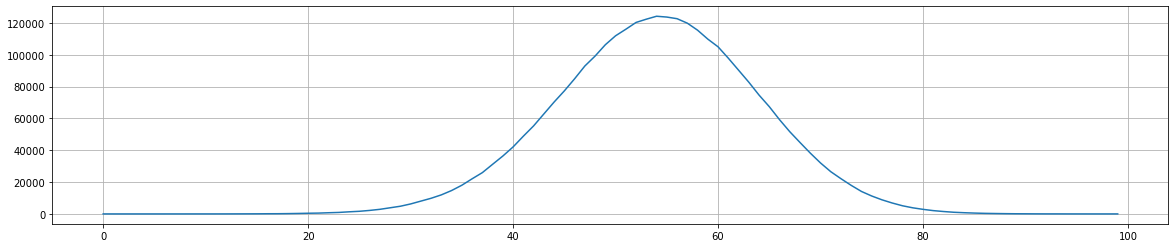

In [302]:
# K_len=[]
# for i in range(len(res_r)):
#     K_len.append(len(res_r[i]))
# pd.Series(K_len).plot()